# **Analyse Exploratoire : Building Energy Benchmarking (Seattle)**

Le dataset utilisé est [téléchargeable ici](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv).
<br><br>
La définition des variables est [disponible ici](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy).
<br><br>
*Le programme de mesure et de déclaration de la consommation d'énergie des bâtiments de Seattle (SMC 22.920) exige des propriétaires de bâtiments non résidentiels et multifamiliaux (de 20 000 pieds carrés ou plus) de suivre les performances énergétiques et de les déclarer chaque année à la ville de Seattle. Les bâtiments représentent 33 % des émissions principales de Seattle. La politique de mesure d'évaluation soutient les objectifs de Seattle visant à réduire la consommation d'énergie et les émissions de gaz à effet de serre des bâtiments existants. En 2013, la ville de Seattle a adopté un plan d'action climatique pour atteindre zéro émission nette de gaz à effet de serre d'ici 2050. La mesure, la déclaration annuelle et la divulgation des performances des bâtiments sont des éléments fondamentaux pour créer une valeur marchande plus élevée pour l'efficacité énergétique.*
<br><br>
**Ces données concernent uniquement l'année 2016.**
<br><br>
*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1)*

In [1]:
# Bibliothèques de base
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

# Utilisés lors de l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Servira pour faire l'ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Pour faire tests de normalité
from scipy.stats import shapiro

# Utilisé pour passer des données au log avant ANOVA
from sklearn.preprocessing import FunctionTransformer

# Utilisé pour savoir si le fichier excel d'export existe déjà
import os

# Je désactive le copy warning, en m'étant au préalable assuré que les traitements étaient corrects
pd.options.mode.chained_assignment = None  # default='warn'

## **Importation du dataset**

In [2]:
data_raw = pd.read_csv("2016_Building_Energy_Benchmarking.csv", sep=',')
print('Importation terminée')

Importation terminée


## **Premier aperçu du dataset**

In [3]:
print("Premières lignes : ")
display(data_raw.head())

print("Résumé des valeurs numériques : ")
display(data_raw.describe())

print("- Le dataset contient", data_raw.shape[0], "lignes et", data_raw.shape[1], "colonnes.")
print("- Il y a", data_raw.duplicated().sum(), "lignes en doubles.")

colonnes_vides = data_raw.columns[data_raw.nunique() == 0]
print("-", len(colonnes_vides), "colonnes du dataset sont entièrement vides :", colonnes_vides.tolist())

print()

data_raw.info(verbose = True)

Premières lignes : 


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

Résumé des valeurs numériques : 


OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3376.000000    3376.0   3360.000000          3376.000000   
mean    21208.991114    2016.0  98116.949107             4.439277   
std     12223.757015       0.0     18.615205             2.120625   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19990.750000    2016.0  98105.000000             3.000000   
50%     23112.000000    2016.0  98115.000000             4.000000   
75%     25994.250000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  3376.000000  3376.000000  3376.000000        3368.000000   
mean     47.624033  -122.334795  1968.573164           1.106888   
std       0.047758     0.027203    33.088156           2.108402   
min      47.499170  -122.414250  1900.000000           0.000000   
25%      47.599860  -122.350662  1948.000000           1.000000   
50%      47.618675  -122.332495  1975.000000           1.000000   
75%      47.657115  -122.319407  1997.000000           1.000000   
max      47.733870  -122.220966  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  ...  SiteEnergyUse(kBtu)  \
count     3376.000000      3.376000e+03  ...         3.371000e+03   
mean         4.709123      9.483354e+04  ...         5.403667e+06   
std          5.494465      2.188376e+05  ...         2.161063e+07   
min          0.000000      1.128500e+04  ...         0.000000e+00   
25%          2.000000      2.848700e+04  ...         9.251286e+05   
50%          4.000000      4.417500e+04  ...         1.803753e+06   
75%          5.000000      9.099200e+04  ...         4.222455e+06   
max         99.000000      9.320156e+06  ...         8.739237e+08   

       SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
count           3.370000e+03    3.367000e+03      3.367000e+03   
mean            5.276726e+06    2.745959e+05      1.086639e+06   
std             1.593879e+07    3.912173e+06      4.352478e+06   
min             0.000000e+00    0.000000e+00     -3.382680e+04   
25%             9.701822e+05    0.000000e+00      1.874229e+05   
50%             1.904452e+06    0.000000e+00      3.451299e+05   
75%             4.381429e+06    0.000000e+00      8.293178e+05   
max             4.716139e+08    1.349435e+08      1.925775e+08   

       Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  Comments  \
count       3.367000e+03        3.367000e+03      3.367000e+03       0.0   
mean        3.707612e+06        1.368505e+04      1.368505e+06       NaN   
std         1.485066e+07        6.709781e+04      6.709781e+06       NaN   
min        -1.154170e+05        0.000000e+00      0.000000e+00       NaN   
25%         6.394870e+05        0.000000e+00      0.000000e+00       NaN   
50%         1.177583e+06        3.237538e+03      3.237540e+05       NaN   
75%         2.829632e+06        1.189033e+04      1.189034e+06       NaN   
max         6.570744e+08        2.979090e+06      2.979090e+08       NaN   

       TotalGHGEmissions  GHGEmissionsIntensity  
count        3367.000000            3367.000000  
mean          119.723971               1.175916  
std           538.832227               1.821452  
min            -0.800000              -0.020000  
25%             9.495000               0.210000  
50%            33.920000               0.610000  
75%            93.940000               1.370000  
max         16870.980000              34.090000  

[8 rows x 30 columns]

- Le dataset contient 3376 lignes et 46 colonnes.
- Il y a 0 lignes en doubles.
- 1 colonnes du dataset sont entièrement vides : ['Comments']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  C

## **Fonction de représentation du niveau de remplissage du dataset**

In [4]:
def filling_level(dataset=data_raw):

    ####################################################################
    # Graphique montrant les pourcentages de vide pour chaque colonnes #
    ####################################################################

    dataset_a_utiliser = dataset

    # Si le dataset est totalement plein, pas la peine d'afficher ce graphique, qui serait totalement vide
    if dataset_a_utiliser.isna().sum().sum() != 0:

        colonnes_incompletes = dataset_a_utiliser.isna().mean()

        fig, ax = plt.subplots(figsize=(30,10))

        # Création d'une palette personnalisée
        colors = [{p<0.5: '#3A923A', 0.3<=p<=0.5: '#E1812C', p>0.5: '#C03D3E'}[True] for p in colonnes_incompletes.values.tolist()]
        sns.set_palette(sns.color_palette(colors))

        sns.barplot(x=colonnes_incompletes.index, y=colonnes_incompletes.values*100, alpha = 0.9)

        plt.xticks(rotation=90)
        ax.set_title('\nPourcentage de valeurs manquantes dans les différentes colonnes\n', fontsize='xx-large')
        ax.set_ylabel('Valeurs manquantes (%)', fontsize='x-large')

        plt.show()
    else:
        print("Ce dataset ne contient aucune valeur manquante.")

    ###########################################################
    # Diagramme en secteurs pour la répartition vide/non vide #
    ###########################################################

    # Si le dataset est totalement plein, pas la peine d'afficher ce diagramme, qui ne contiendrait qu'une seule valeur.
    if dataset_a_utiliser.isna().sum().sum() != 0:
        vide = dataset_a_utiliser.isnull().sum().sum() # Somme de la somme des NaN de chaque colonne
        plein = dataset_a_utiliser.notnull().sum().sum() # Somme de la somme des non NaN de chaque colonne

        labels = 'Plein', 'Vide'
        sizes = [plein, vide]

        colors=['#FFB2B2', '#B2B2FF']

        fig, ax = plt.subplots(figsize=(10, 10))
        plt.title("\nRemplissage du dataframe", fontsize=30)
        ax.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%', colors=colors, textprops={'color':"black", 'fontsize':25});
        plt.show()

        print("Il y a", len(colonnes_incompletes[colonnes_incompletes.values > 0.5]), "colonnes avec plus de 50 % de données manquantes.\n\n")


    ####################################################################
    # Diagramme en secteurs pour la répartition quantitatif/qualitatif #
    ####################################################################

    colonne_numeriques = dataset_a_utiliser.select_dtypes(np.number).shape[1]
    autres_colonnes = dataset_a_utiliser.shape[1] - dataset_a_utiliser.select_dtypes(np.number).shape[1]

    labels = 'Quantitatives', 'Qualitatives'
    sizes = [colonne_numeriques, autres_colonnes]

    colors=['#FFB2B2', '#B2B2FF']

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("\nRépartition du type de variable", fontsize=30)
    ax.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%', colors=colors, textprops={'color':"black", 'fontsize':25});
    plt.show()

    print("Variables quantitatives :", colonne_numeriques)
    print("Variables qualitatives :", autres_colonnes)
    print("Total des variables :", dataset_a_utiliser.shape[1])

## **Représentation du remplissage du dataset**

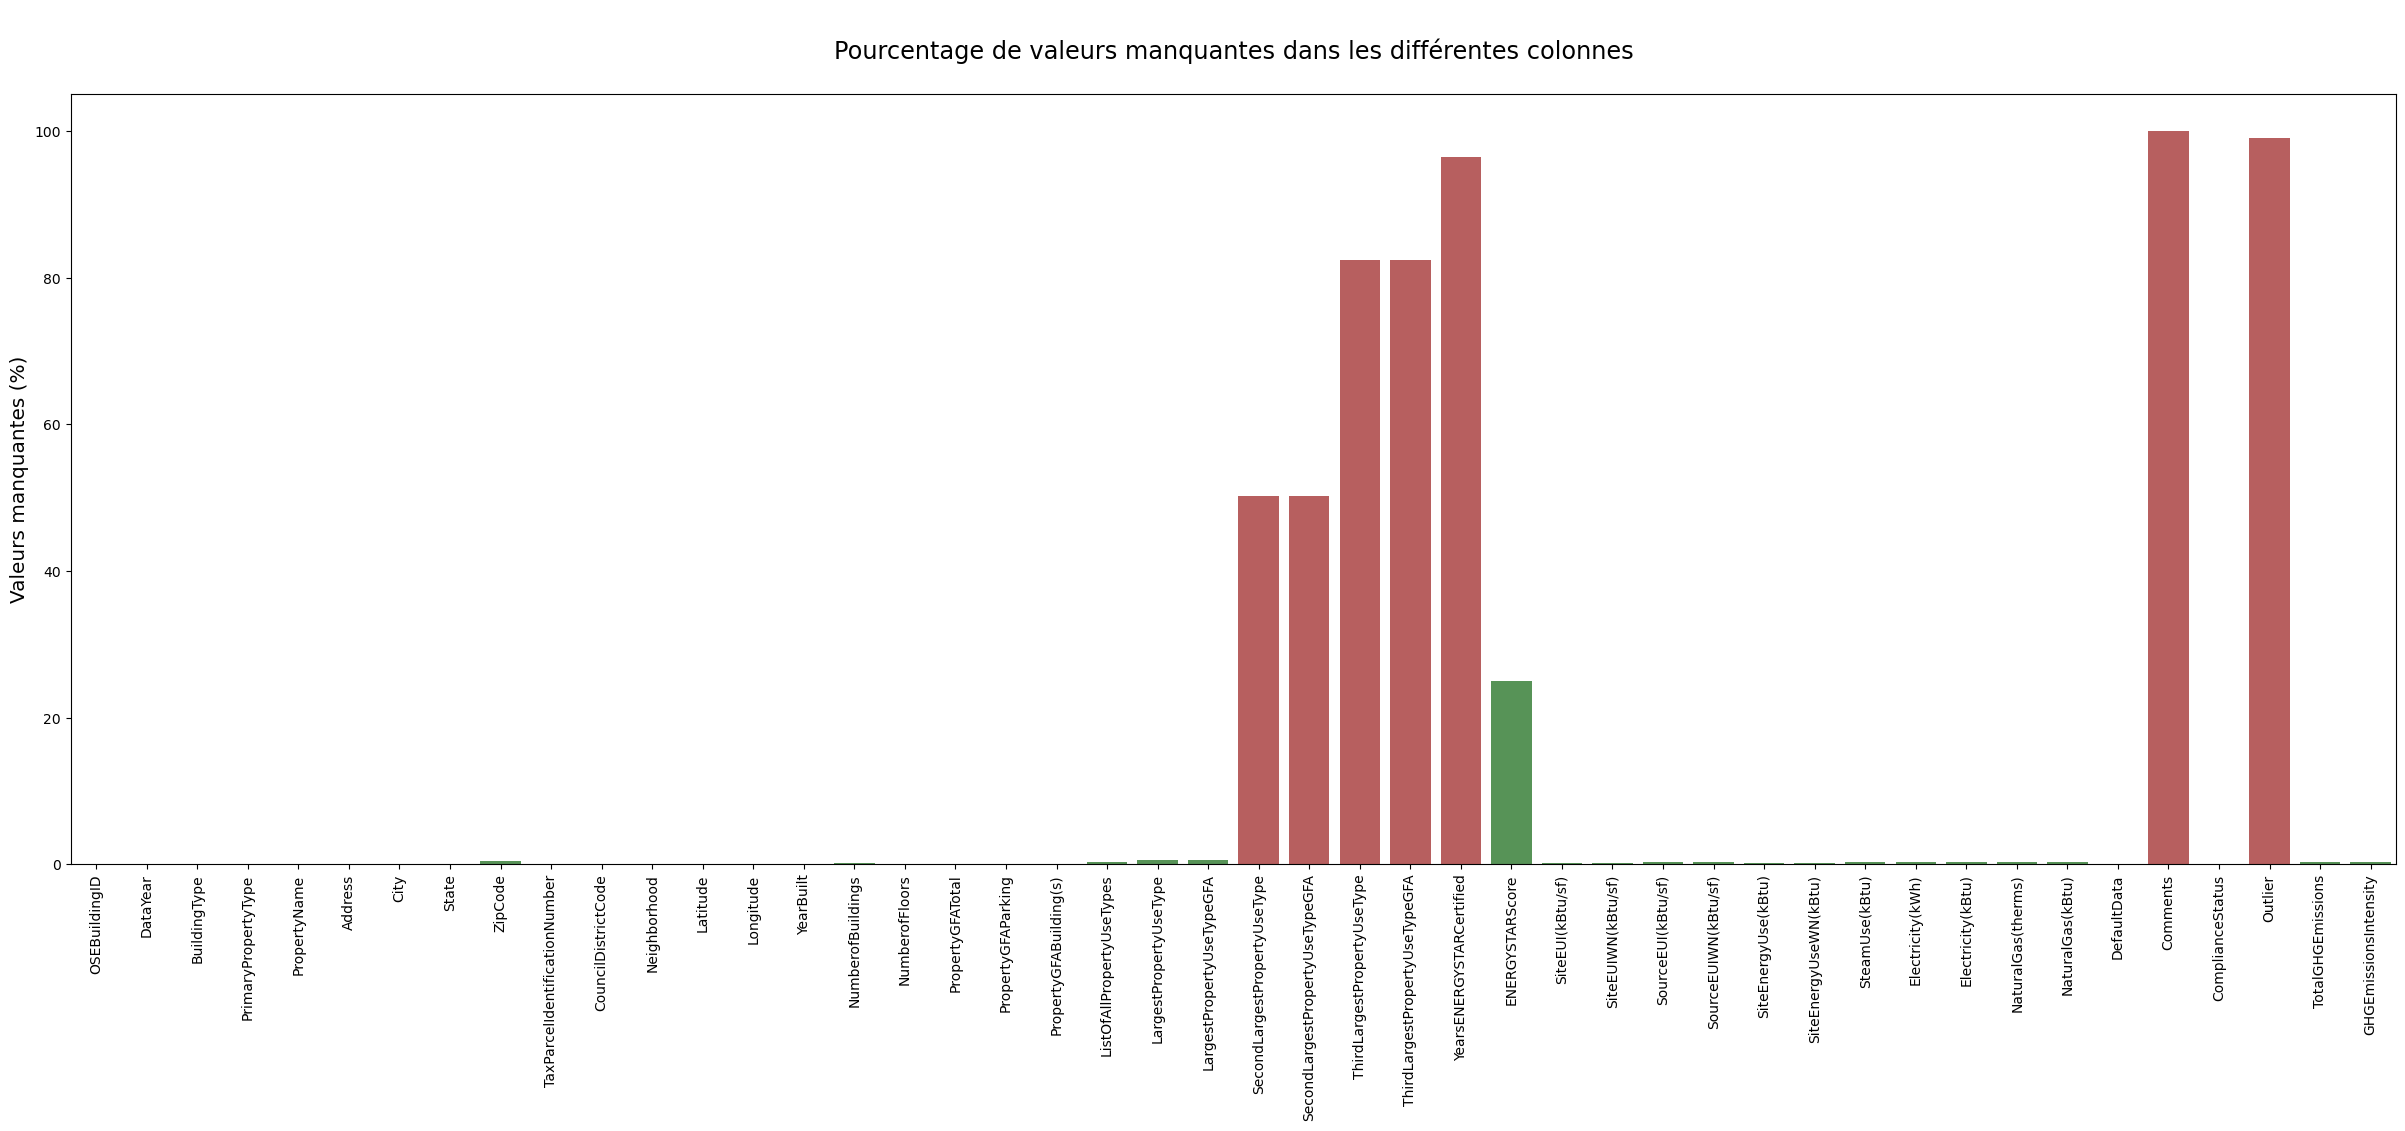

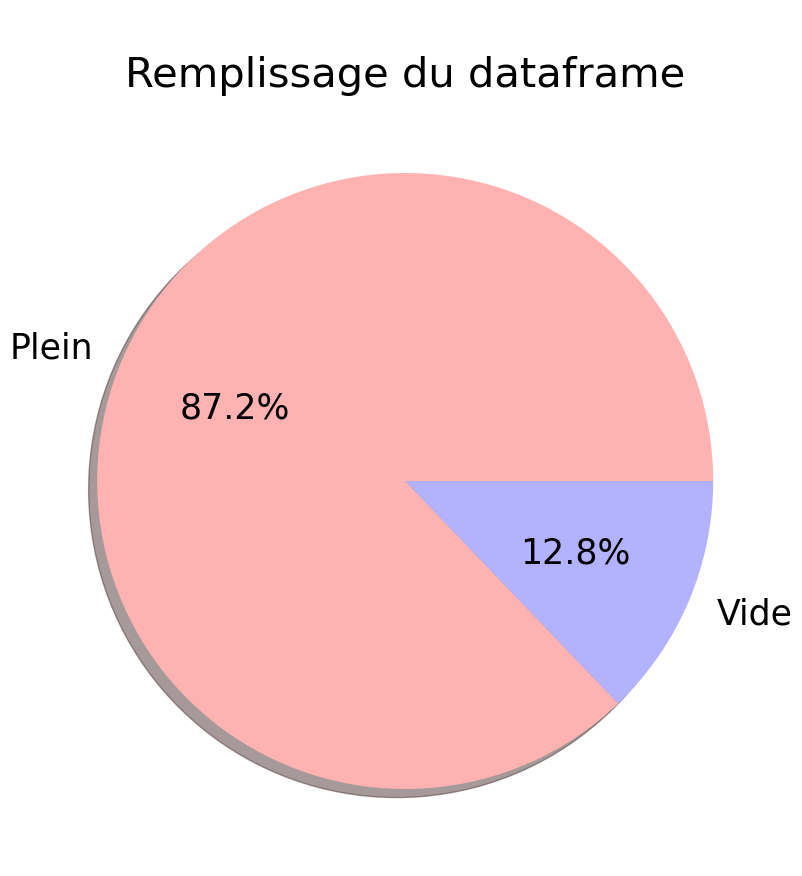

Il y a 7 colonnes avec plus de 50 % de données manquantes.




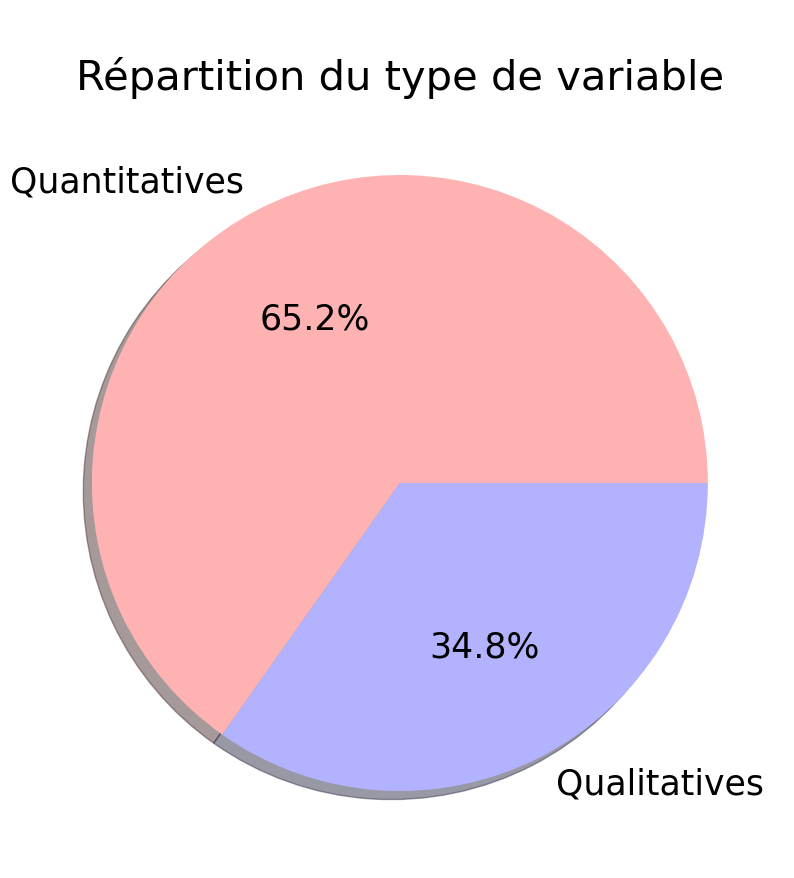

Variables quantitatives : 30
Variables qualitatives : 16
Total des variables : 46


In [5]:
filling_level(dataset=data_raw)

# **Nettoyage du dataset**

### **Traitement de la variable *OSEBuildingID***

In [6]:
print("Il y a", data_raw['OSEBuildingID'].isnull().sum(), "valeurs nulles dans la colonne OSEBuildingID.")

# Suppression des lignes où 'OSEBuildingID' est NaN
if data_raw['OSEBuildingID'].isnull().sum() > 0:
    data_raw = data_raw[data_raw['OSEBuildingID'].notna()]
    print("Valeurs nulles supprimées.")

print("Il y a", data_raw['OSEBuildingID'].duplicated().sum(), "doubles dans la colonne OSEBuildingID")

Il y a 0 valeurs nulles dans la colonne OSEBuildingID.
Il y a 0 doubles dans la colonne OSEBuildingID


### **Sélection des bâtiments non résidentiels uniquement**

Comme demandé dans les consignes du projet.<br>
Autrement dit, je supprime les lignes dont à variable *BuildingType* est *Multifamily MR (5-9)*, *Multifamily LR (1-4)* ou *Multifamily HR (10+)*.

In [7]:
print("Nombre d'entrées avant suppression des bâtiments résidentiels :", data_raw.shape[0])

data_raw = data_raw.loc[(data_raw['BuildingType'] != 'Multifamily MR (5-9)') & (data_raw['BuildingType'] != 'Multifamily LR (1-4)') & (data_raw['BuildingType'] != 'Multifamily HR (10+)')]

print("Nombre d'entrées après suppression des bâtiments résidentiels :", data_raw.shape[0])

Nombre d'entrées avant suppression des bâtiments résidentiels : 3376
Nombre d'entrées après suppression des bâtiments résidentiels : 1668


### **Traitement des bâtiments qui n'ont pas satisfait les exigences de mesure**

Je me base sur la variable *ComplianceStatus* et ne conserve que les entrées *"Compliant"*.

In [8]:
print("Nombre d'entrées avant suppression des bâtiments non Compliant :", data_raw.shape[0])

data_raw = data_raw.loc[data_raw['ComplianceStatus'] == "Compliant"]

print("Nombre d'entrées après suppression des bâtiments non Compliant :", data_raw.shape[0])

Nombre d'entrées avant suppression des bâtiments non Compliant : 1668
Nombre d'entrées après suppression des bâtiments non Compliant : 1548


### **Sélection des colonnes qui nous intéressent**

In [9]:
colonnes_a_garder = [
                    'BuildingType',
                    'PrimaryPropertyType',
                    'Neighborhood',
                    'YearBuilt',
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'ENERGYSTARScore',
                    'SiteEnergyUseWN(kBtu)',
                    'TotalGHGEmissions'
                    ]
print("Variables conservées :", colonnes_a_garder)

colonnes_non_gardees = [x for x in data_raw.columns if x not in colonnes_a_garder]
print("Variables non conservées :", colonnes_non_gardees)

print("Nombre de variables avant traiement :", data_raw.shape[1])
data_clean = data_raw[colonnes_a_garder]
print("Nombre de variables après traiement :", data_clean.shape[1])




Variables conservées : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
Variables non conservées : ['OSEBuildingID', 'DataYear', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'PropertyGFATotal', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']
Nomb

### **Traitement du type des variables**

In [10]:
print("Type des différentes variables :")
data_clean.dtypes

Type des différentes variables :


BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
ENERGYSTARScore           float64
SiteEnergyUseWN(kBtu)     float64
TotalGHGEmissions         float64
dtype: object

*NumberofBuildings* et *ENERGYSTARScore* sont des variables quantitatives discrètes.<br>
Je vais passer leur type en *Int64*

In [11]:
data_clean = data_clean.astype({'NumberofBuildings': 'Int64', 'ENERGYSTARScore': 'Int64'})

Pas de problème pour les autres variables.

### **Valeurs nulles**

In [12]:
data_clean.isnull().sum()

BuildingType                0
PrimaryPropertyType         0
Neighborhood                0
YearBuilt                   0
NumberofBuildings           0
NumberofFloors              0
PropertyGFAParking          0
PropertyGFABuilding(s)      0
ENERGYSTARScore           551
SiteEnergyUseWN(kBtu)       1
TotalGHGEmissions           0
dtype: int64

- Je supprime les entrées où *SiteEnergyUseWN(kBtu)* est vide car c'est une de nos variables cibles.

In [13]:
print("Nombre d'entrées avant suppression des valeurs nulles dans SiteEnergyUseWN(kBtu) :", data_clean.shape[0])

data_clean = data_clean.loc[data_clean['SiteEnergyUseWN(kBtu)'].isnull() == False]

print("Nombre d'entrées après suppression des bâtiments résidentiels :", data_clean.shape[0])

Nombre d'entrées avant suppression des valeurs nulles dans SiteEnergyUseWN(kBtu) : 1548
Nombre d'entrées après suppression des bâtiments résidentiels : 1547


- Pour la variable *ENERGYSTARScore*, il y a trop de données manquantes (environ 30 %), je vais traitrer ça après.

### **Valeurs aberrantes**

- *'Low-Rise Multifamily'* (variable *PrimaryPropertyType*) : je supprime les entrées concernées, car on est sensé ne pas avoir de bâtiments résidentiels.

In [14]:
print("Nombre d'entrées avant suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) :", data_clean.shape[0])

data_clean = data_clean.loc[data_clean['PrimaryPropertyType'] != 'Low-Rise Multifamily']

print("Nombre d'entrées après suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) :", data_clean.shape[0])

Nombre d'entrées avant suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) : 1547
Nombre d'entrées après suppression des valeurs 'Low-Rise Multifamily' dans PrimaryPropertyType (data_clean) : 1545


- *Neighborhood* : j'uniformise

In [15]:
data_clean['Neighborhood'] = data_clean['Neighborhood'].str.upper()
data_clean['Neighborhood'].loc[data_clean['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS'] = 'DELRIDGE'

- *NumberofBuildings* : quand c'est égal à 0, je présume que ça n'a pas été renseigné car il n'y avait qu'un bâtiment. Donc je change la valeur à 1.<br>
Il y a également des valeurs assez élevées, mais il s'agit de campus : atypique, mais pas aberrant.

In [16]:
data_clean['NumberofBuildings'].loc[data_clean['NumberofBuildings'] == 0] = 1

- *SiteEnergyUseWN(kBtu)* : quand c'est égal à 0, c'est aberrant, je supprime les entrées concernées.

In [17]:
data_clean = data_clean.loc[data_clean['SiteEnergyUseWN(kBtu)'] != 0]

- *SiteEnergyUseWN(kBtu)*, valeurs extrêmes : un nombre très réduit d'entrées perturbe beaucoup les données, je décide de les supprimer.

In [18]:
data_clean = data_clean.loc[data_clean['SiteEnergyUseWN(kBtu)'] < 1.15e8]

- *NumberofFloors* : je supprime les valeurs supérieures à 90 et je mets les valeurs égales à 0 à 1.

In [19]:
data_clean = data_clean.loc[data_clean['NumberofFloors'] < 90]
data_clean['NumberofFloors'].loc[data_clean['NumberofFloors'] == 0] = 1


- Valeurs négatives :

In [20]:
data_clean.min()

BuildingType                           Campus
PrimaryPropertyType       Distribution Center
Neighborhood                          BALLARD
YearBuilt                                1900
NumberofBuildings                           1
NumberofFloors                              1
PropertyGFAParking                          0
PropertyGFABuilding(s)                   3636
ENERGYSTARScore                             1
SiteEnergyUseWN(kBtu)             58114.19922
TotalGHGEmissions                        -0.8
dtype: object

Je supprime les valeurs <= 0 pour *TotalGHGEmissions*

In [21]:
print("Nombre d'entrées avant suppression des valeurs négatives ou nulles dans 'TotalGHGEmissions' :", data_clean.shape[0])

data_clean = data_clean.loc[data_clean['TotalGHGEmissions'] > 0]

print("Nombre d'entrées après suppression des valeurs négatives ou nulles dans 'TotalGHGEmissions' :", data_clean.shape[0])

Nombre d'entrées avant suppression des valeurs négatives ou nulles dans 'TotalGHGEmissions' : 1526
Nombre d'entrées après suppression des valeurs négatives ou nulles dans 'TotalGHGEmissions' : 1524


- *BuildingType* : j'uniformise. Il n'y a qu'une seule valeur *"Nonresidential WA"*, je la change en *"NonResidential"*

In [22]:
data_clean['BuildingType'].loc[data_clean['BuildingType'] == 'Nonresidential WA'] = 'NonResidential'

### **Nom de la variable SiteEnergyUseWN(kBtu)**

Je renomme en enlevant les parenthèses, car ça causera des soucis plus tard avec l'ANOVA.

In [23]:
data_clean.rename(columns={"SiteEnergyUseWN(kBtu)": "SiteEnergyUseWN_kBtu"}, inplace=True)

### **Cas de la variable *ENERGYSTARScore***

Pour la variable *ENERGYSTARScore*, puisqu'il y a trop de données manquantes (environ 30 %) pour pouvoir les imputer correctement, je vais séparer en deux datasets : <br>
- un avec *ENERGYSTARScore* où je supprime toutes les entrées nulles pour cette variable
- un où je supprime la variable *ENERGYSTARScore*

In [24]:
data_clean_score = data_clean.loc[data_clean['ENERGYSTARScore'].isnull() == False]
print("Création du dataset 'data_clean_score'. Nombre d'entrées dans ce dataset :", data_clean_score.shape[0])

data_clean = data_clean.drop(columns=['ENERGYSTARScore'])
print("Variable 'ENERGYSTARScore' supprimée du dataset 'data_clean'.")

Création du dataset 'data_clean_score'. Nombre d'entrées dans ce dataset : 979
Variable 'ENERGYSTARScore' supprimée du dataset 'data_clean'.


### **Représentation du remplissage du dataset après nettoyage**

Ce dataset ne contient aucune valeur manquante.


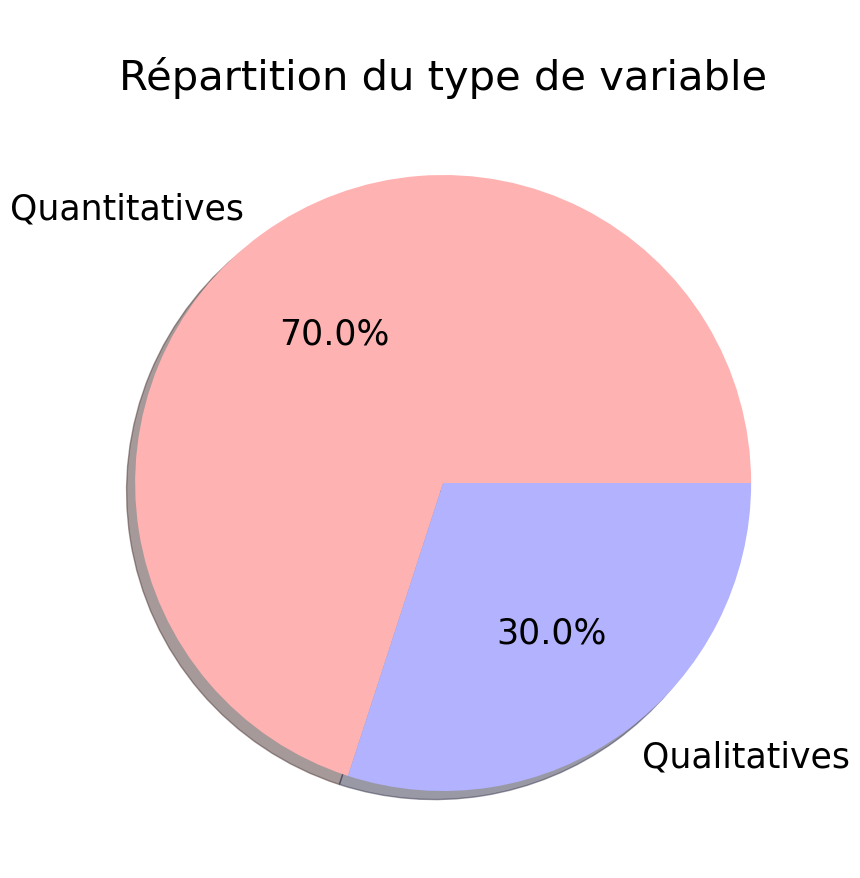

Variables quantitatives : 7
Variables qualitatives : 3
Total des variables : 10


In [25]:
filling_level(dataset=data_clean)

# **Exploration du dataset**

### **Matrice de corrélation (variables quantitatives)**

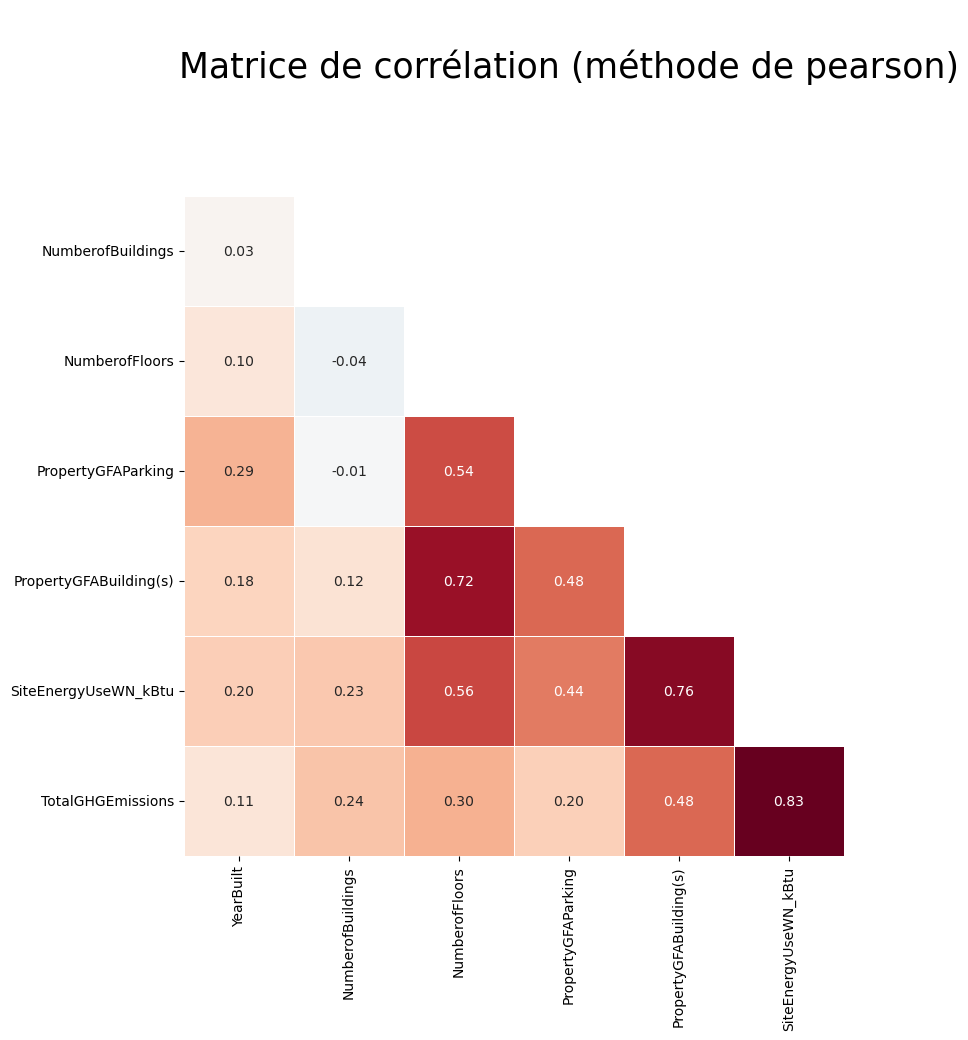

In [26]:
correlation = data_clean.corr(numeric_only = True, method="pearson")
mask = np.triu(np.ones_like(correlation, dtype=bool), 0)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(correlation, mask=mask, cbar = False, center=0, cmap='RdBu_r', annot=True, annot_kws={"size": 10}, fmt='.2f', square=True, linewidths=0.5).set_title('\nMatrice de corrélation (méthode de pearson)', fontsize=25)

# Je masque la première étiquette de y
ax.yaxis.get_major_ticks()[0].set_visible(False)
# Je masque la dernière étiquette de x
ax.xaxis.get_major_ticks()[-1].set_visible(False)

plt.show()

### **Distribution des variables numériques**

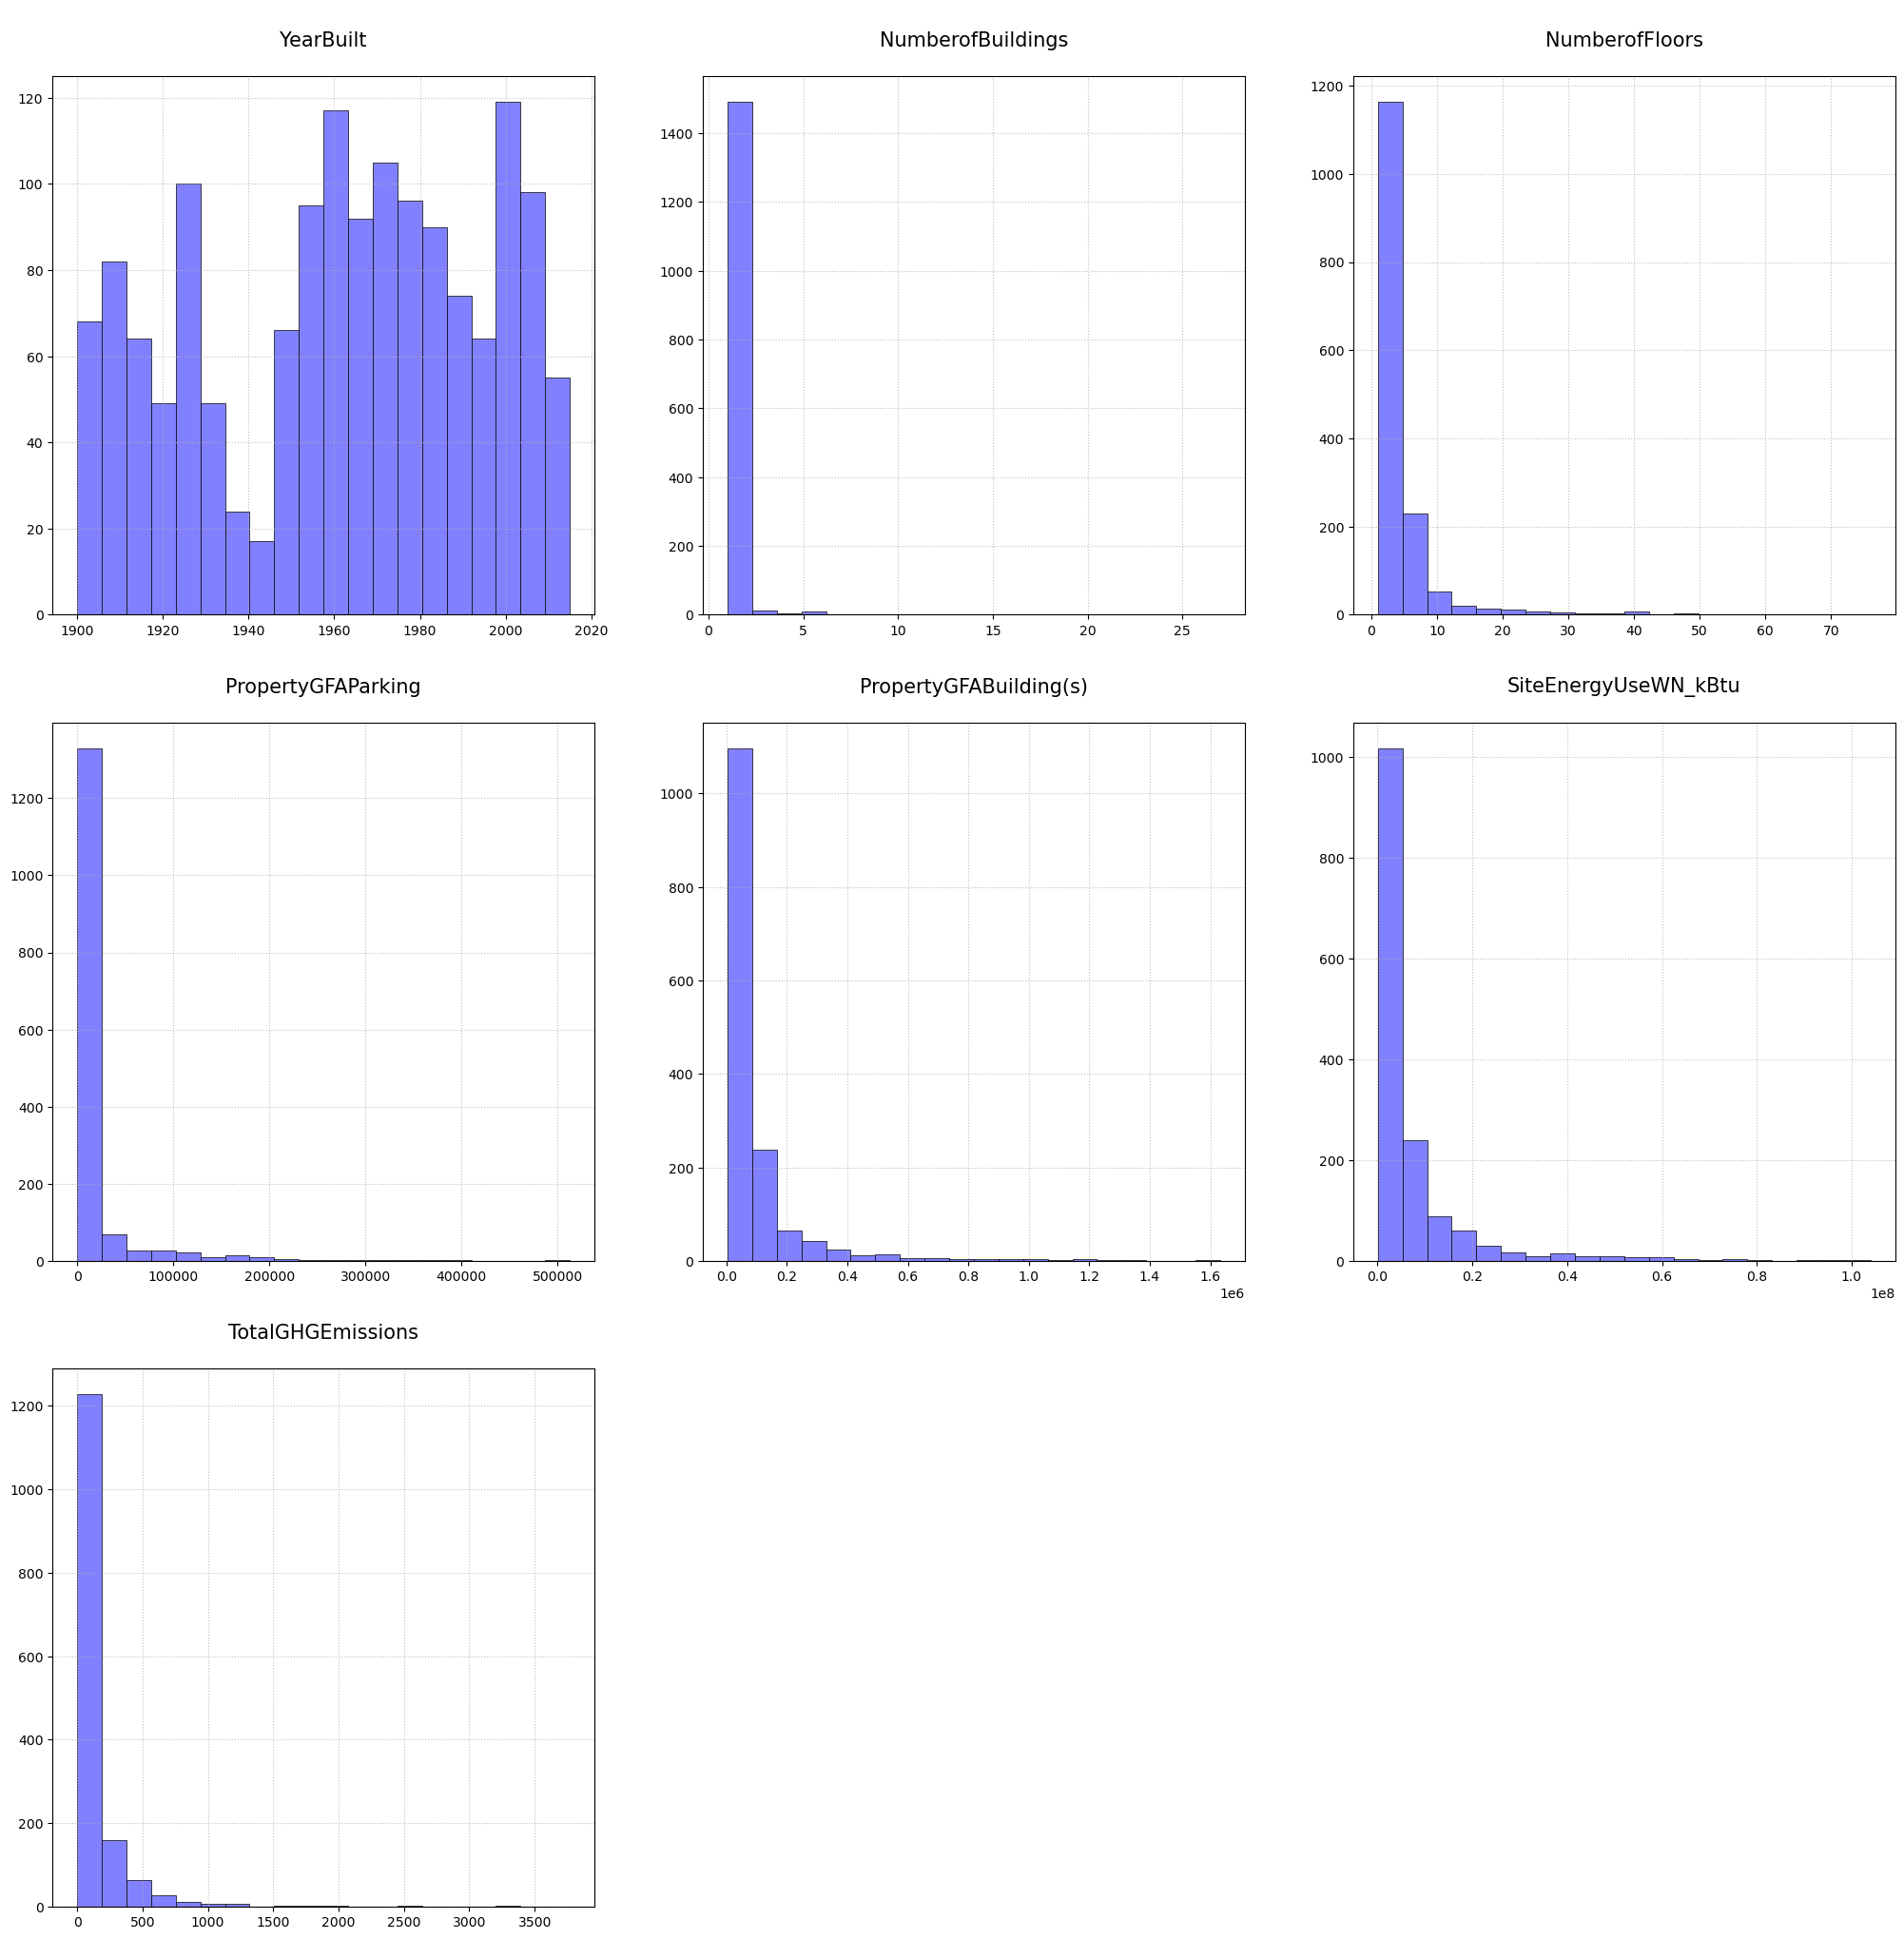

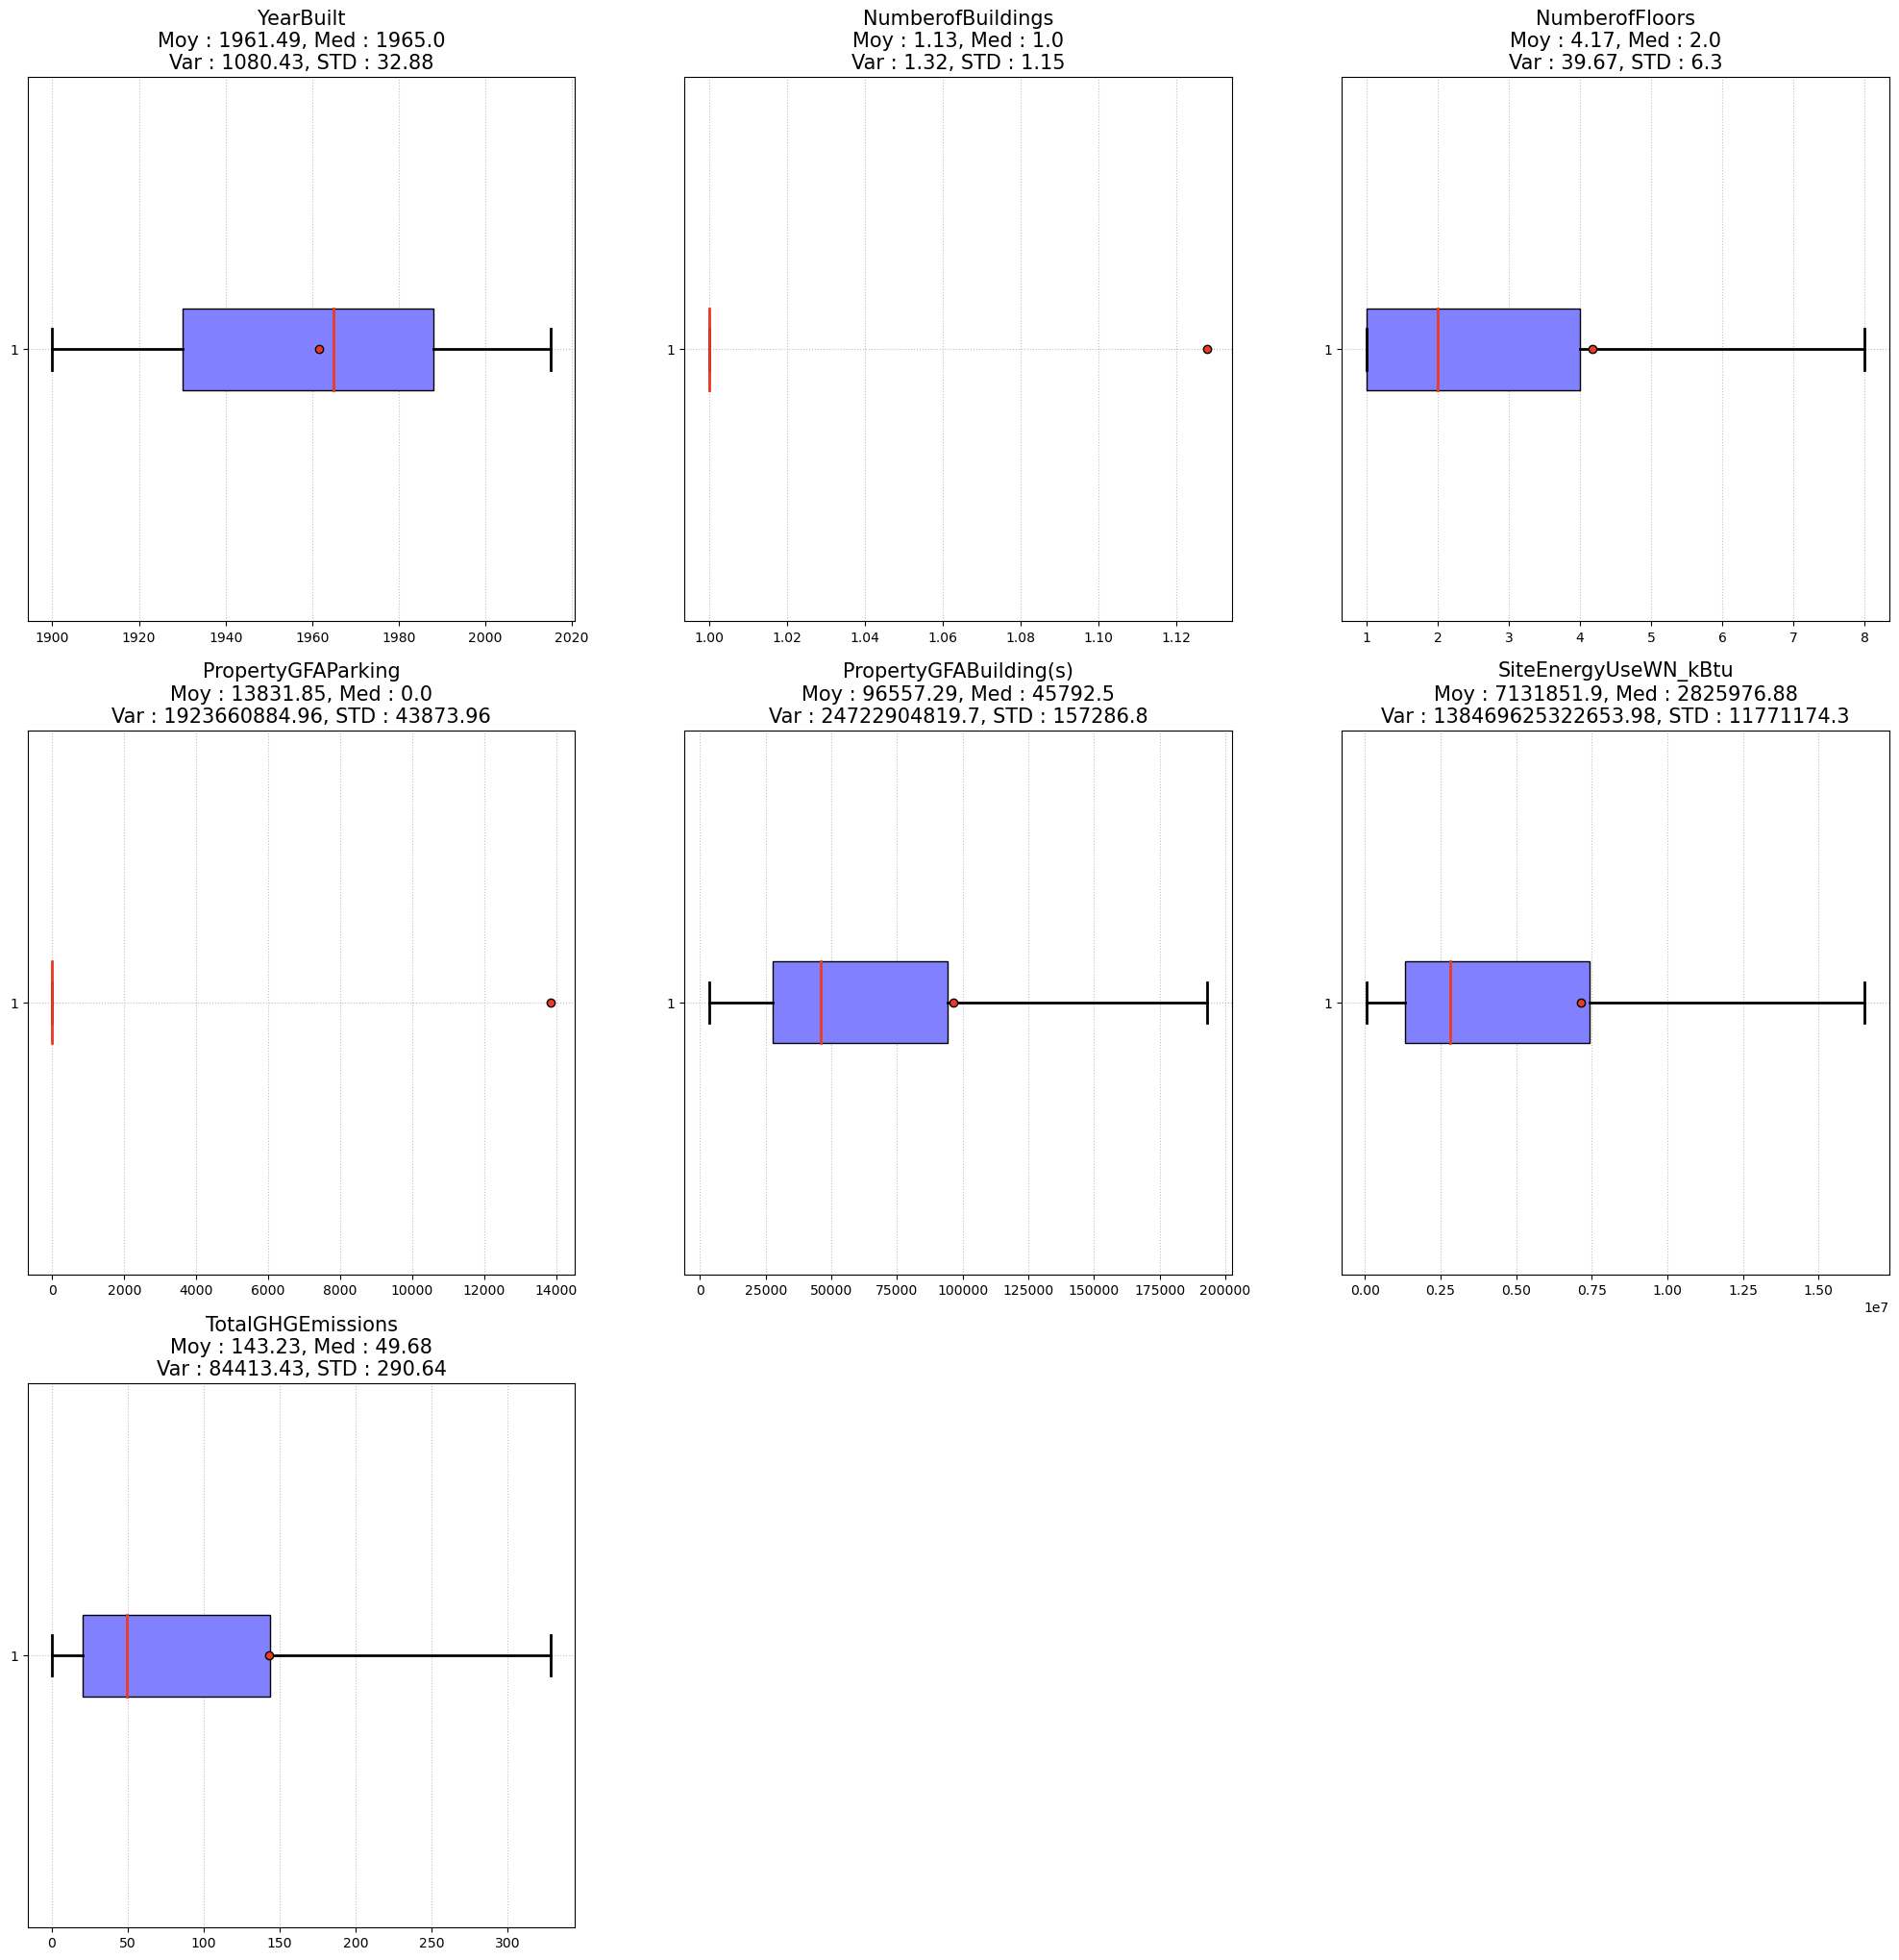

In [27]:
colonnes_numeriques = data_clean.select_dtypes(include=np.number).columns

# Histogramme : 

fig = plt.figure(figsize=(25, 25))
figu = 1
for i in colonnes_numeriques: 

    data = data_clean[[i]]

    ax = fig.add_subplot(3,3, (figu))

    mean = round(data.mean()[0], 2)
    median = round(data.median()[0], 2)
    var = round(data.var(ddof=0)[0], 2)
    std = round(data.std()[0], 2)

    h = ax.hist(data, color = "#8181FF", linewidth=0.5, edgecolor='black', bins=20)

    ax.grid(alpha = 0.8, ls=':')
    ax.set_title(f"\n{data.columns[0]}\n", fontsize=15)
    
    figu += 1


# Boîte à moustaches :

param_box_plot =  {
            'patch_artist': True,
            'boxprops': dict(linestyle='-', linewidth=1, color='black', facecolor='#8181FF'),
            'capprops': dict(color='black', linewidth=2),
            'flierprops': dict(color='#8181FF', markeredgecolor='black', markeredgewidth=0.5, markerfacecolor='#8181FF', markersize=15, marker='.', alpha=.1),
            'medianprops': dict(linestyle='-', linewidth=2, color='#ED3B23'),
            'meanprops': dict(marker='o', markeredgecolor='black', markeredgewidth=1, markerfacecolor='#ED3B23'),
            'whiskerprops': dict(color='black', linewidth=2)
                    }

fig = plt.figure(figsize=(25, 25))
figu = 1
for i in colonnes_numeriques: 

    data = data_clean[[i]]

    ax = fig.add_subplot(3,3, (figu))

    mean = round(data.mean()[0], 2)
    median = round(data.median()[0], 2)
    var = round(data.var(ddof=0)[0], 2)
    std = round(data.std()[0], 2)

    h = ax.boxplot(data, vert=False, showfliers=False, showmeans=True, **param_box_plot)

    ax.grid(alpha = 0.8, ls=':')
    ax.set_title(f"{data.columns[0]}\nMoy : {mean}, Med : {median}\nVar : {var}, STD : {std}", fontsize=15)
    
    figu += 1


### Émission de CO2 en fonction de la consomation d'énergie

Je ne représente que les valeurs inférieures au quartile supérieur (Q3) pour *SiteEnergyUseWN_kBtu* car les valeurs extrèmes réduisent la visibilité.

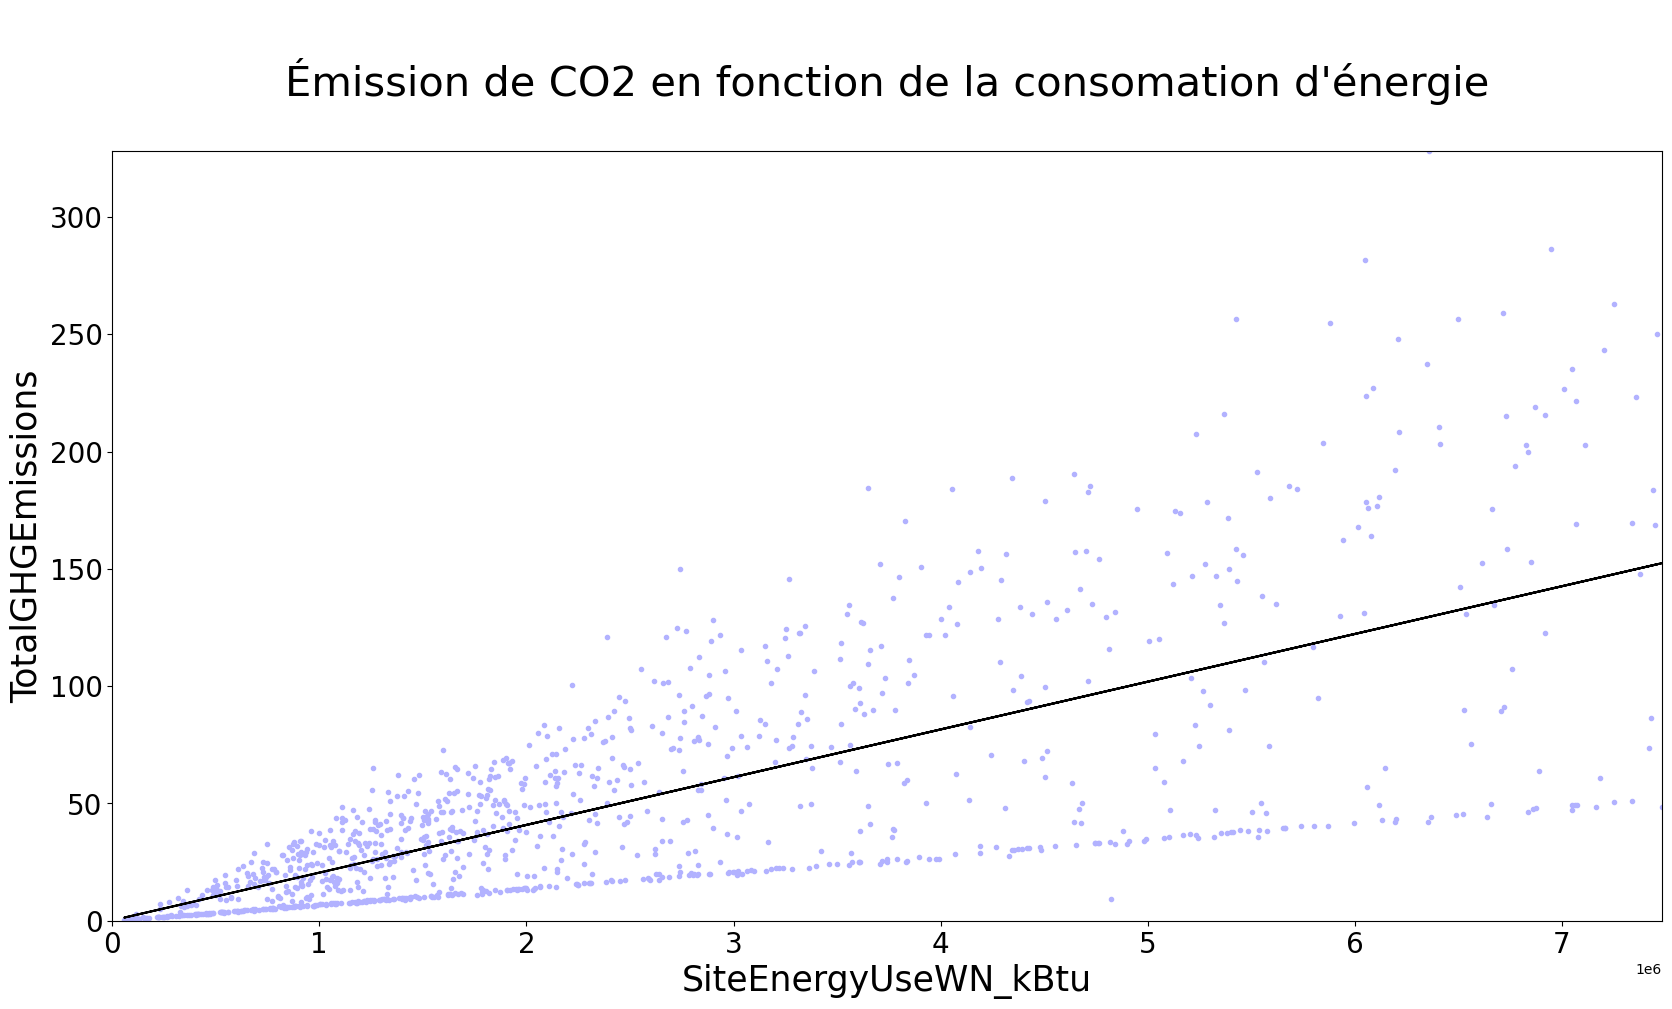

In [28]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
x = data_clean['SiteEnergyUseWN_kBtu'].loc[data_clean['SiteEnergyUseWN_kBtu'] < 0.75e07].values
y = data_clean['TotalGHGEmissions'].loc[data_clean.loc[data_clean['SiteEnergyUseWN_kBtu'] < 0.75e07].index].values

# Calcul de la regression linéaire dont la droite sera affichée
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

# Tracé des points de données
plt.plot(x, y, ".", color = "#B2B2FF", alpha=1)
# Tracé de la droite de régression linéaire
plt.plot(x, poly1d_fn(x), '-', color = "black")
ax.set_xlabel('SiteEnergyUseWN_kBtu')
ax.set_ylabel('TotalGHGEmissions')
plt.title(f"\nÉmission de CO2 en fonction de la consomation d'énergie\n", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(f"SiteEnergyUseWN_kBtu", fontsize=25)
plt.ylabel(f"TotalGHGEmissions", fontsize=25)
ax.margins(x=0, y=0)
ax.set_xlim([0, x.max()])
ax.set_ylim([0, y.max()])
plt.show()

### Consommation d'énergie en fonction de la surface des bâtiments

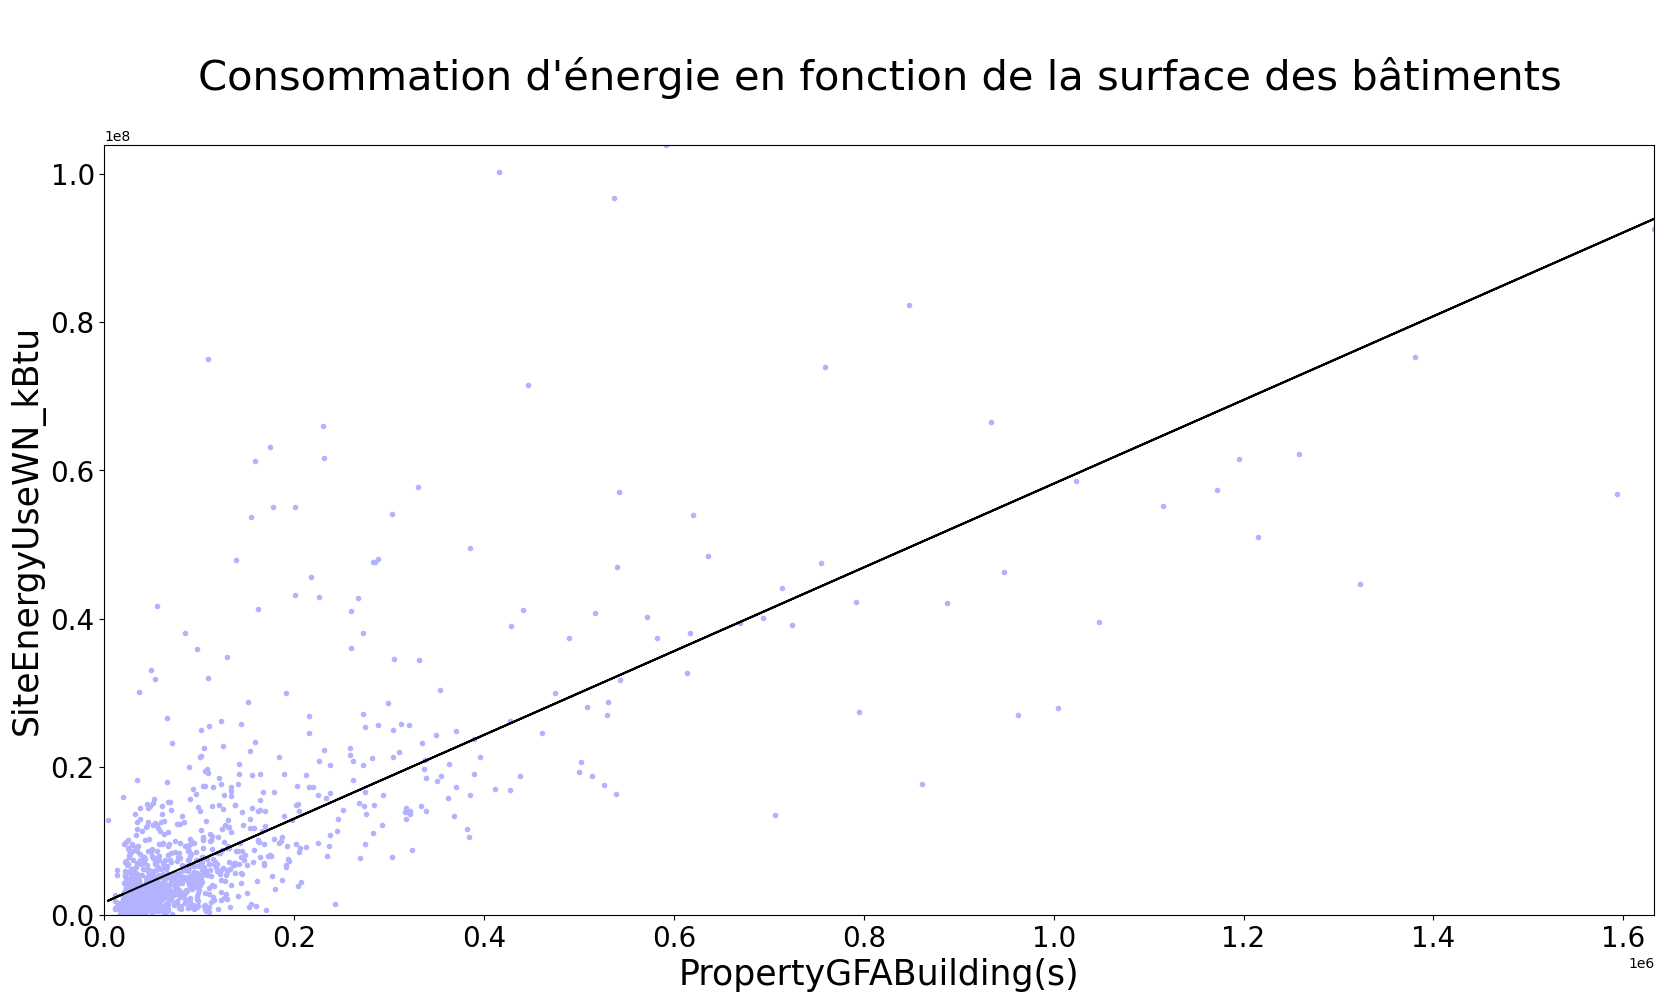

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
variable_x = 'PropertyGFABuilding(s)'
variable_y = 'SiteEnergyUseWN_kBtu'
x = data_clean[variable_x]
y = data_clean[variable_y]

# Calcul de la regression linéaire dont la droite sera affichée
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef)

# Tracé des points de données
plt.plot(x, y, ".", color = "#B2B2FF", alpha=1)
# Tracé de la droite de régression linéaire
plt.plot(x, poly1d_fn(x), '-', color = "black")
ax.set_xlabel(variable_x)
ax.set_ylabel(variable_y)
plt.title(f"\nConsommation d'énergie en fonction de la surface des bâtiments\n", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(variable_x, fontsize=25)
plt.ylabel(variable_y, fontsize=25)
ax.margins(x=0, y=0)
ax.set_xlim([0, x.max()])
ax.set_ylim([0, y.max()])
plt.show()

### **Consommations d'énergie et émissions de CO2 en fonction des variables catégorielles**

##############################
BuildingType :
##############################


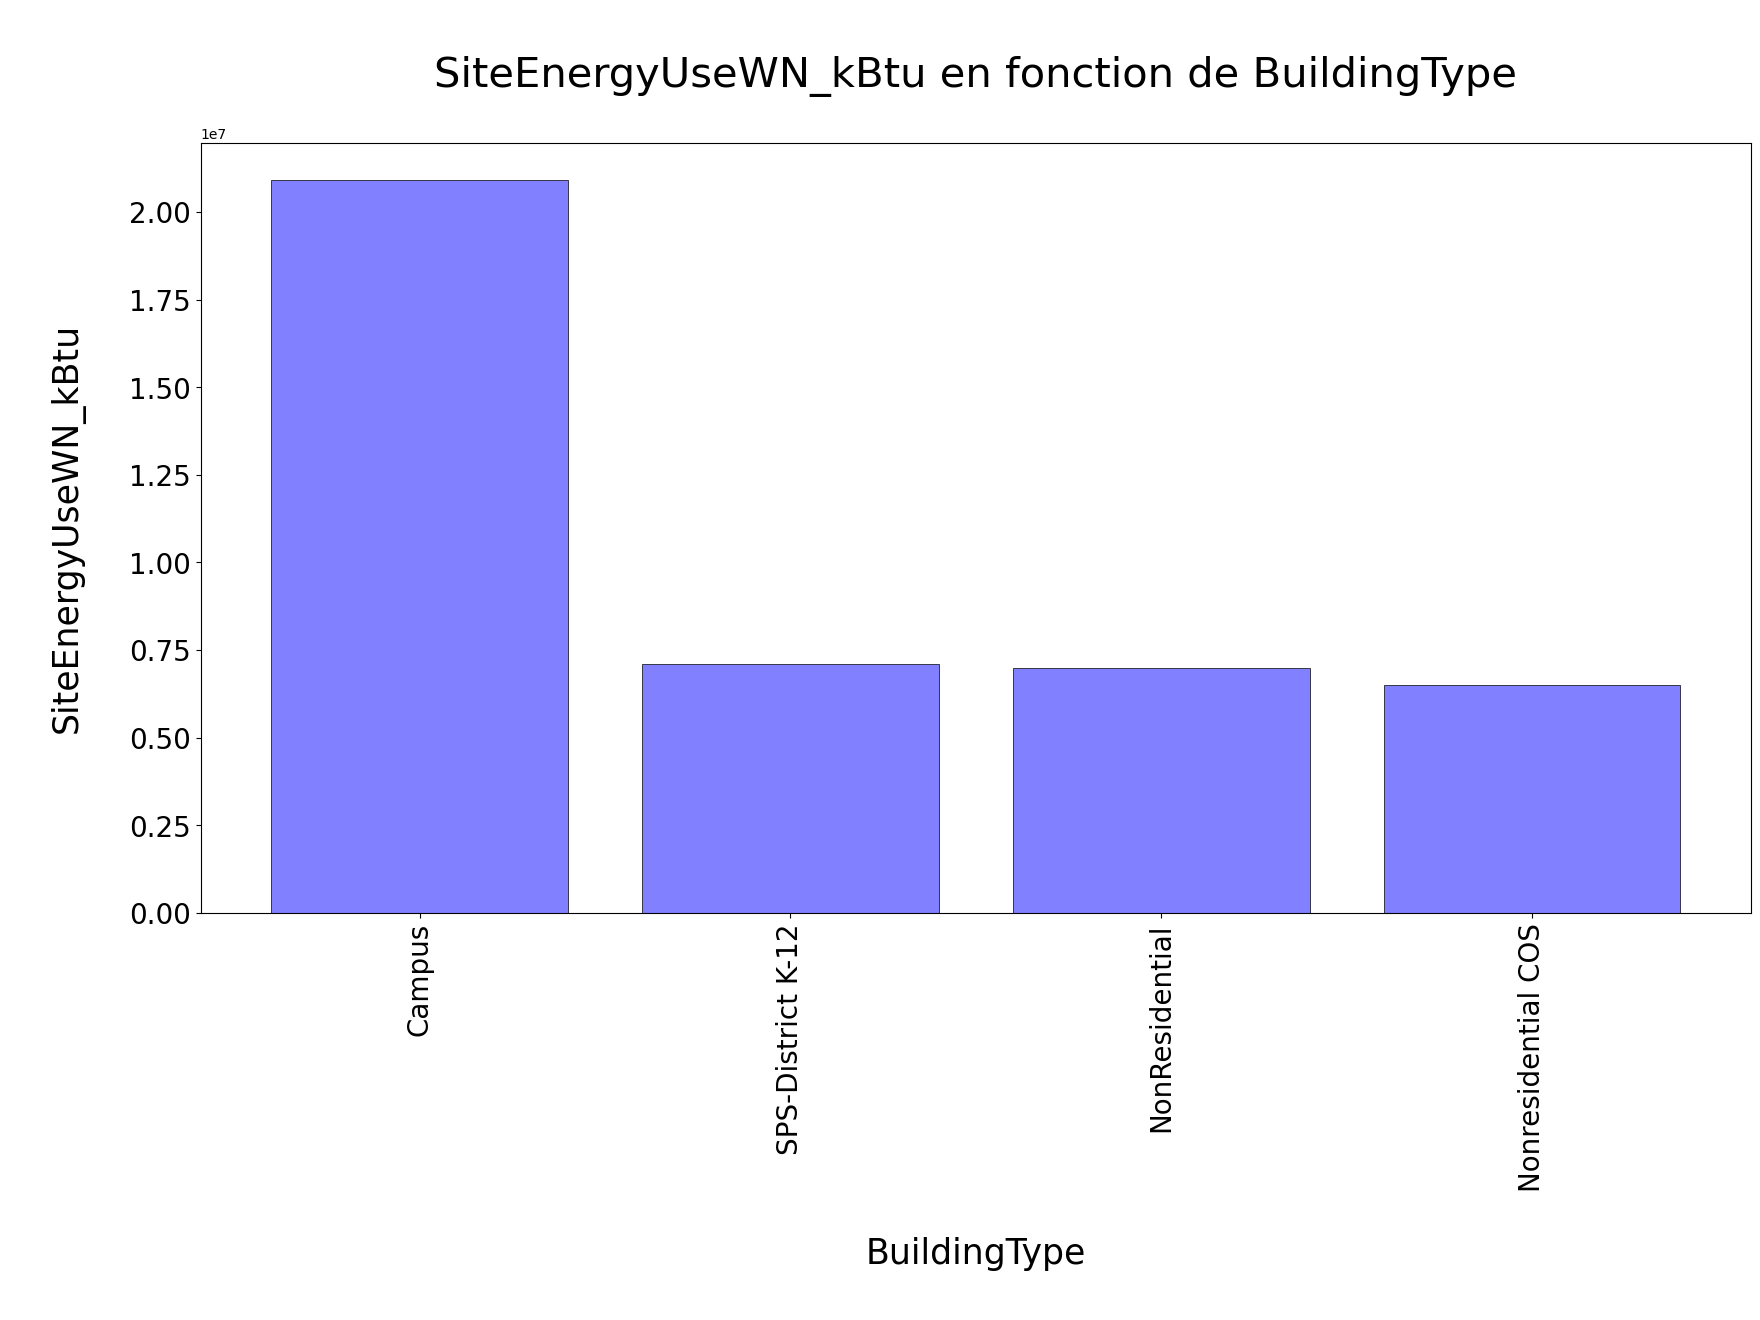

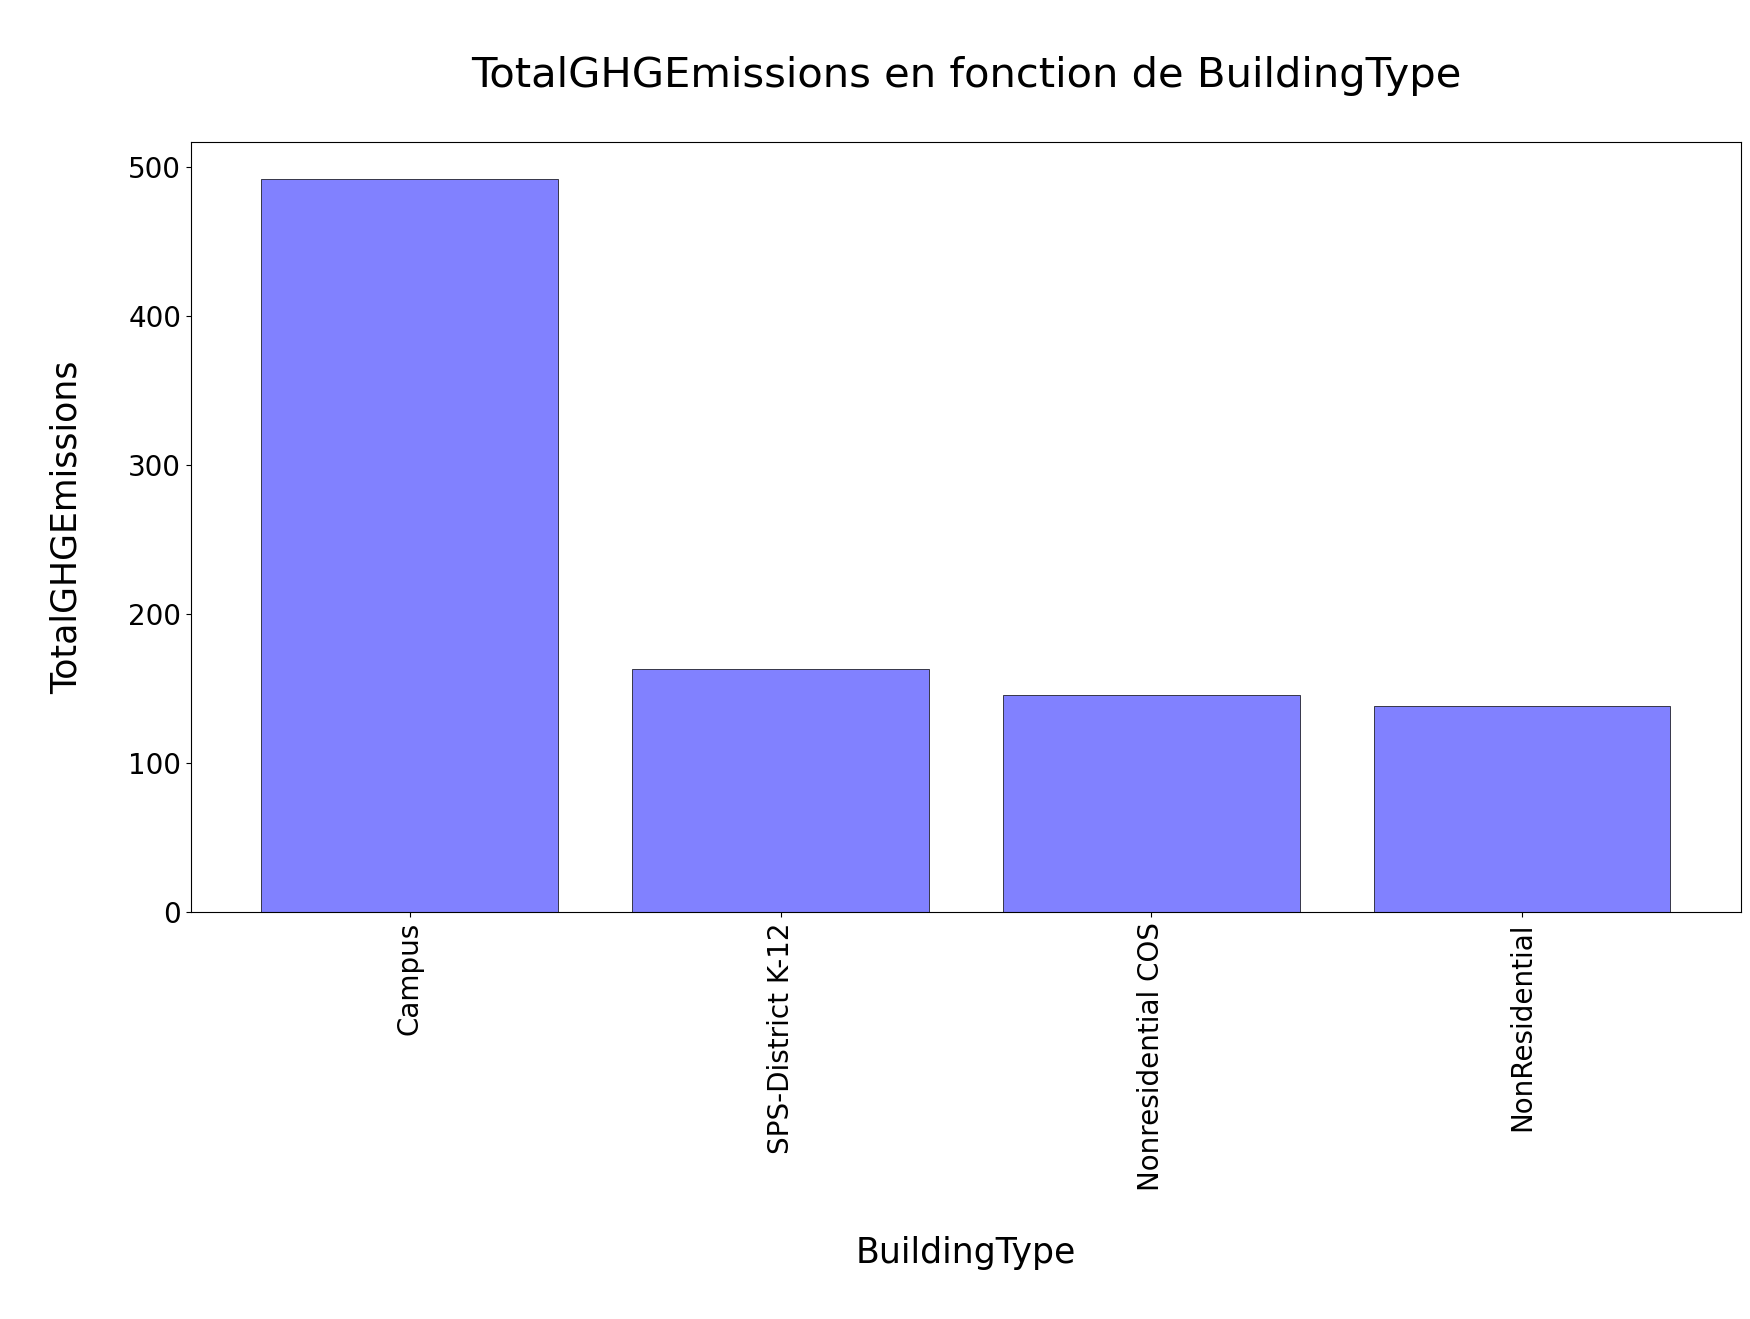

##############################
PrimaryPropertyType :
##############################


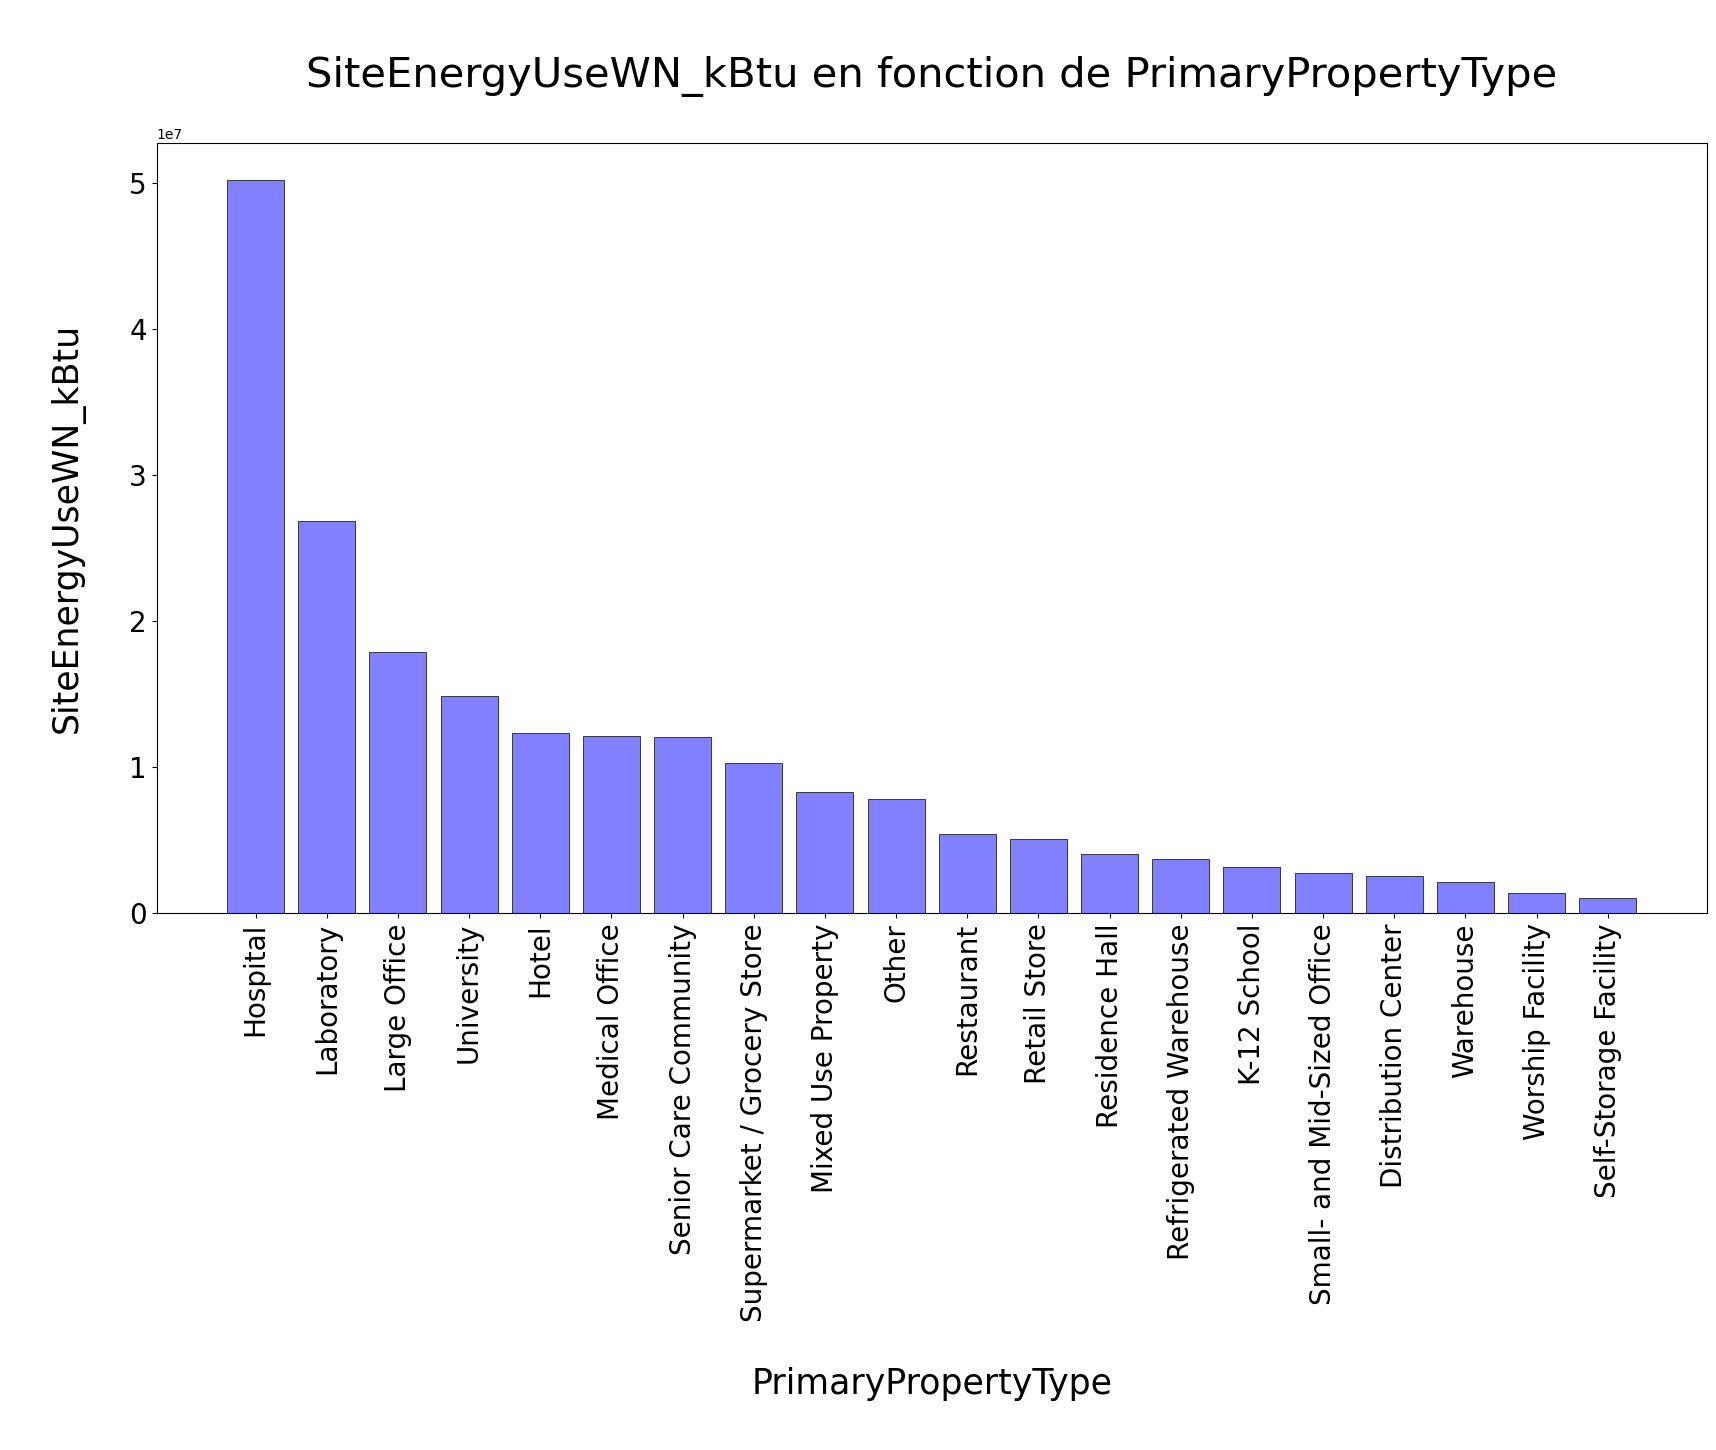

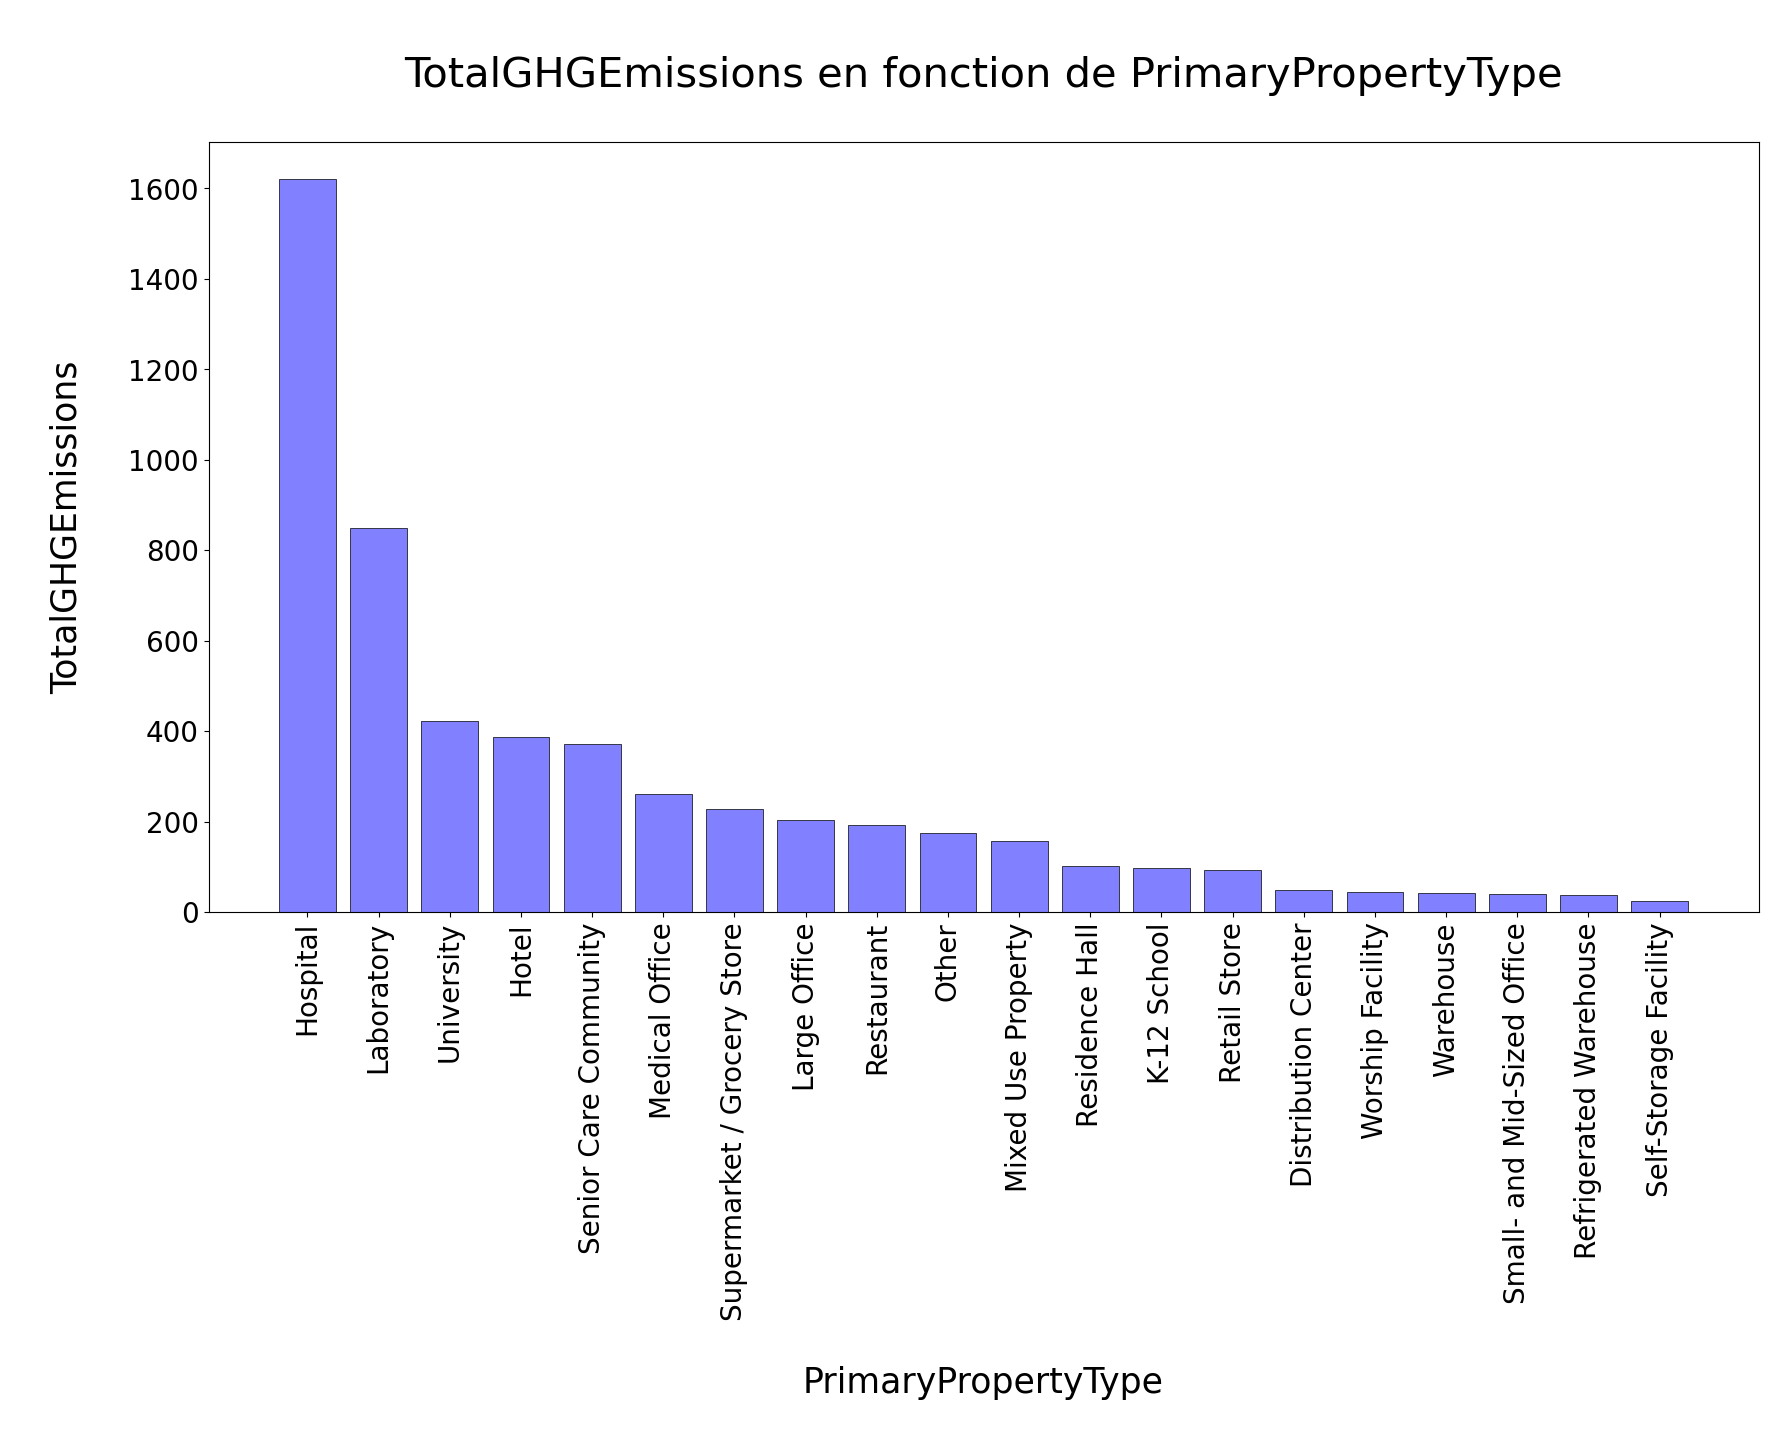

##############################
Neighborhood :
##############################


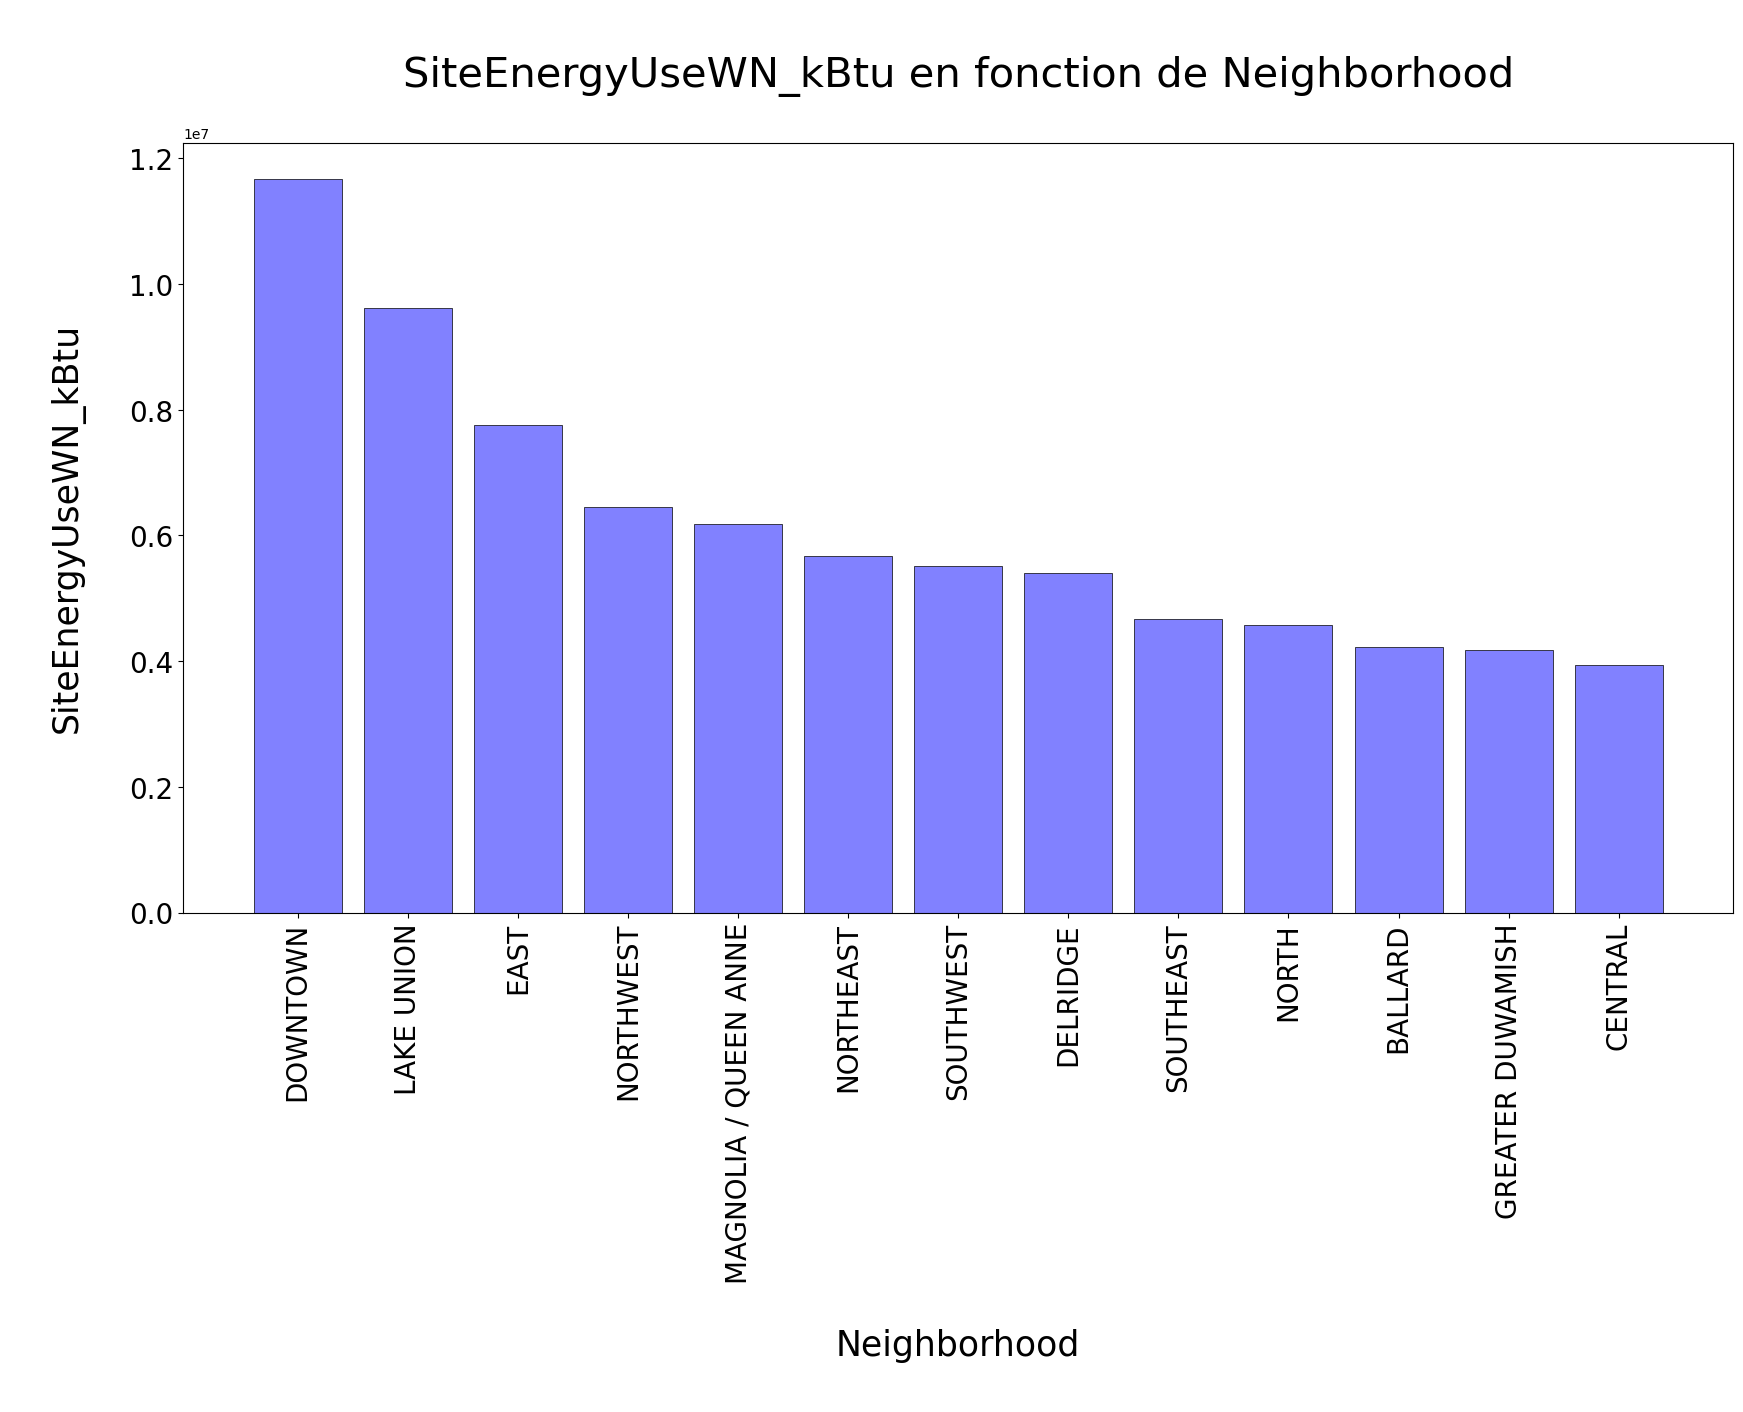

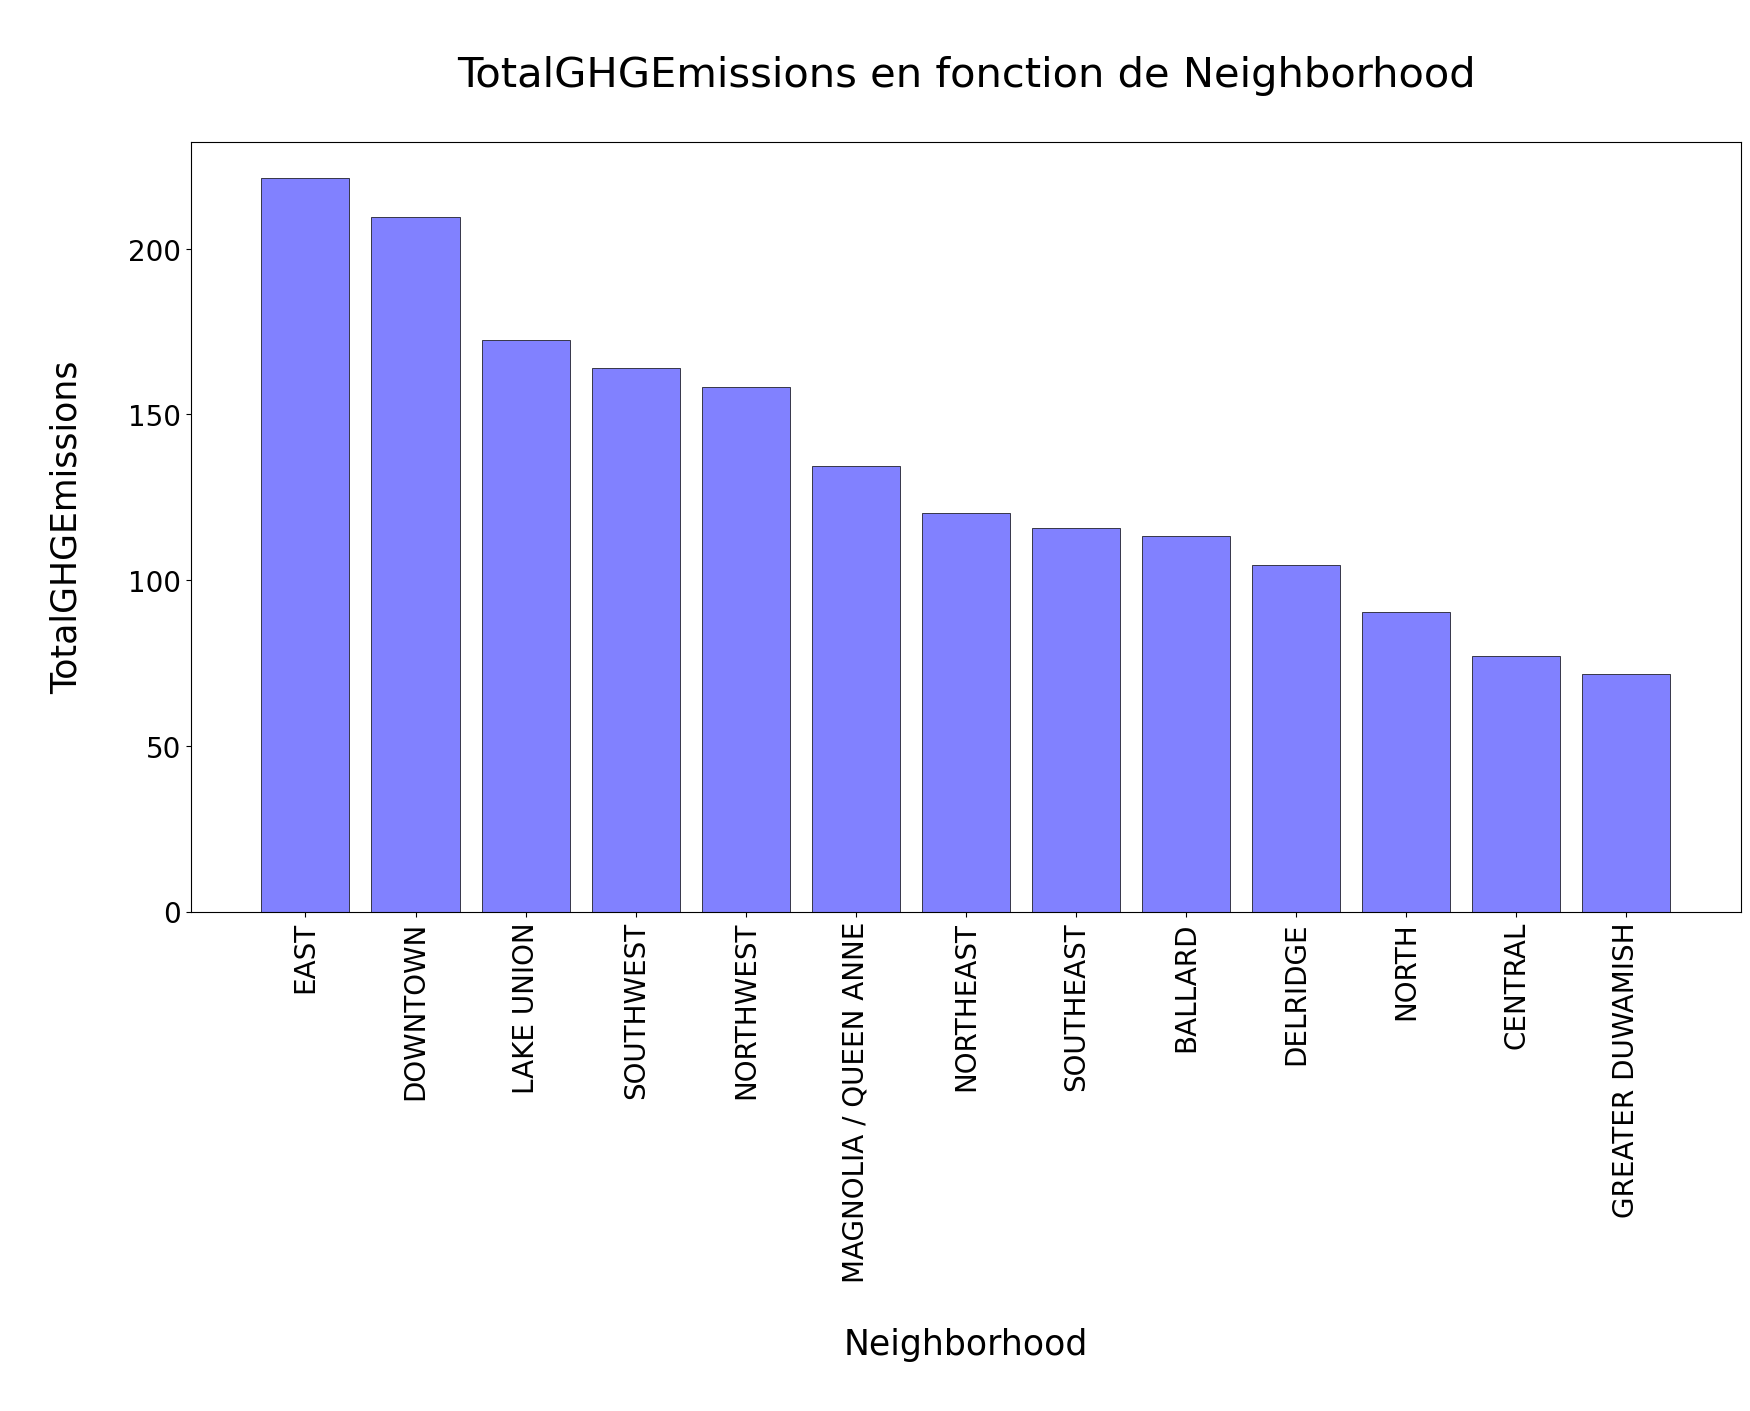

In [30]:
categories = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
conso_emissions = ['SiteEnergyUseWN_kBtu', 'TotalGHGEmissions']

for i in categories:
    print("#"*30)
    print(i, ":")
    print("#"*30)
    for j in conso_emissions:

        data = data_clean.groupby(i)[j].mean().sort_values(ascending=False).values
        types = data_clean.groupby(i)[j].mean().sort_values(ascending=False).index

        plt.figure(figsize=(20,10))
        plt.bar(types, data, color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8, align='center') # data.sort_values().index, data.sort_values().values
        plt.title(f"\n{j} en fonction de {i}\n", fontsize=30)
        plt.xticks(fontsize=20, rotation=90)
        plt.yticks(fontsize=20)
        plt.ylabel(f"\n{j}\n", fontsize=25)
        plt.xlabel(f"\n{i}\n", fontsize=25)
        plt.show()

# Possible sinon de faire directement .plot.bar() après groupby().mean().sort_values()

### ***ENERGYSTARScore* en fonction des variables catégorielles**

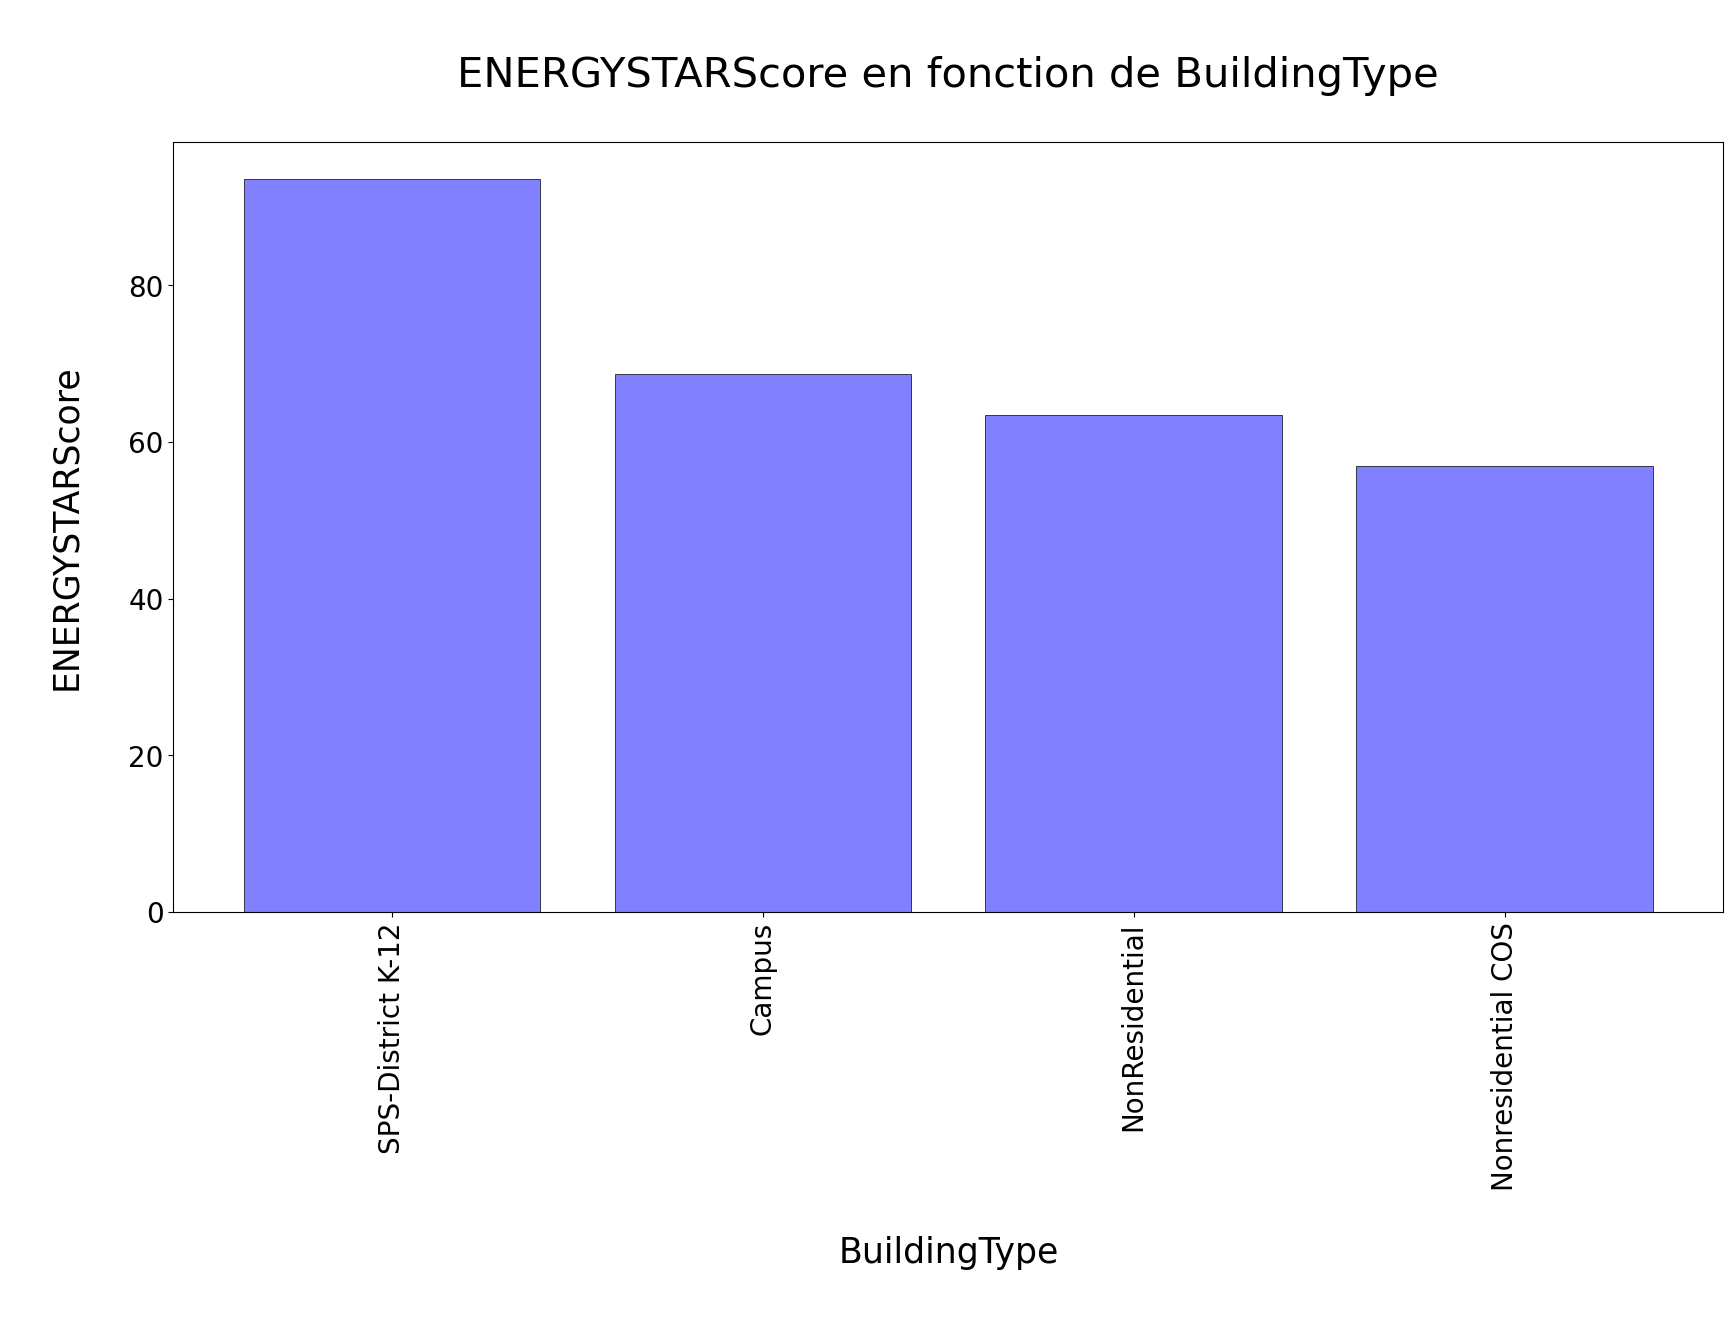

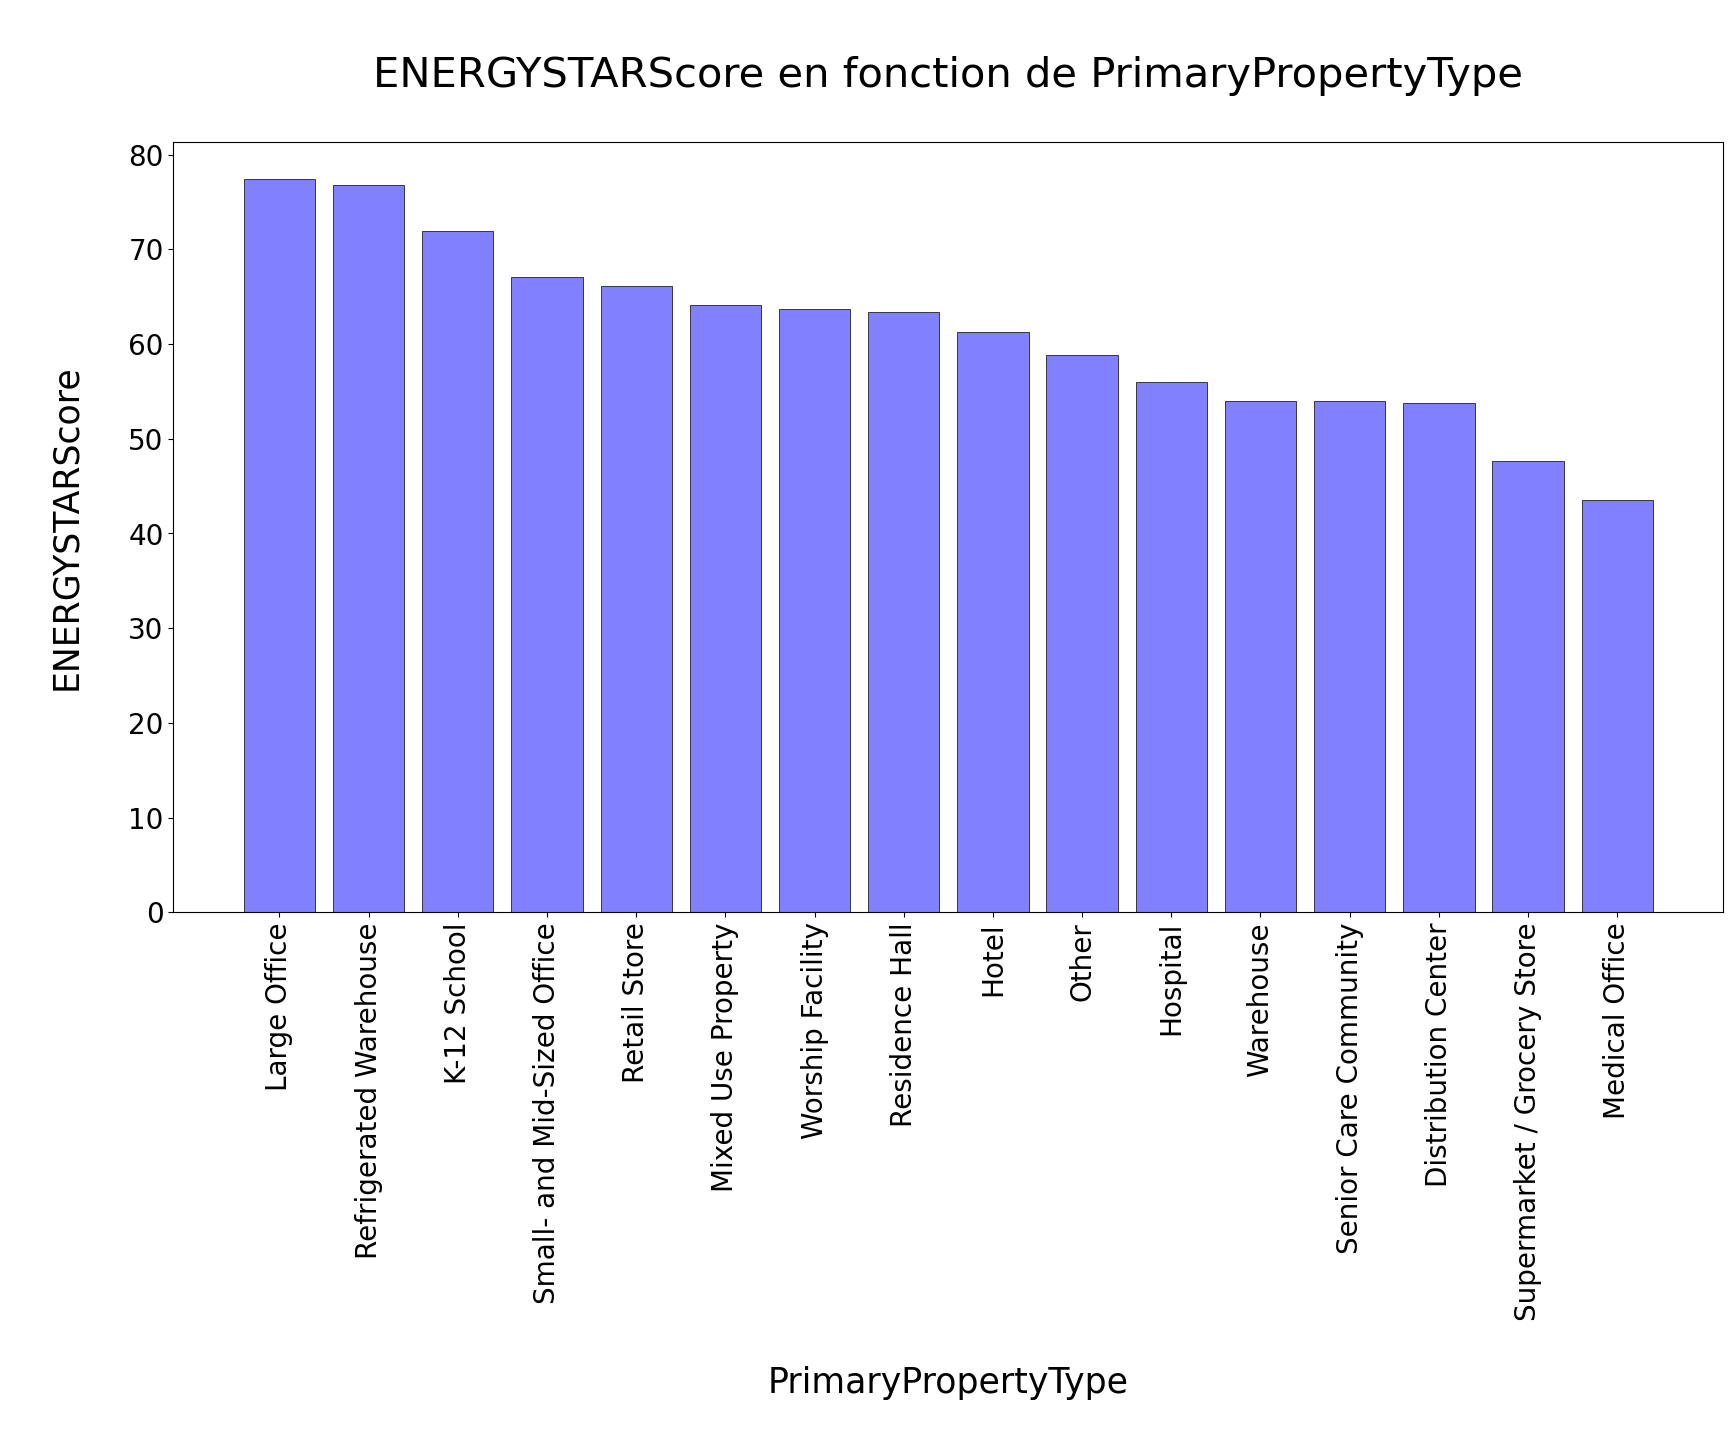

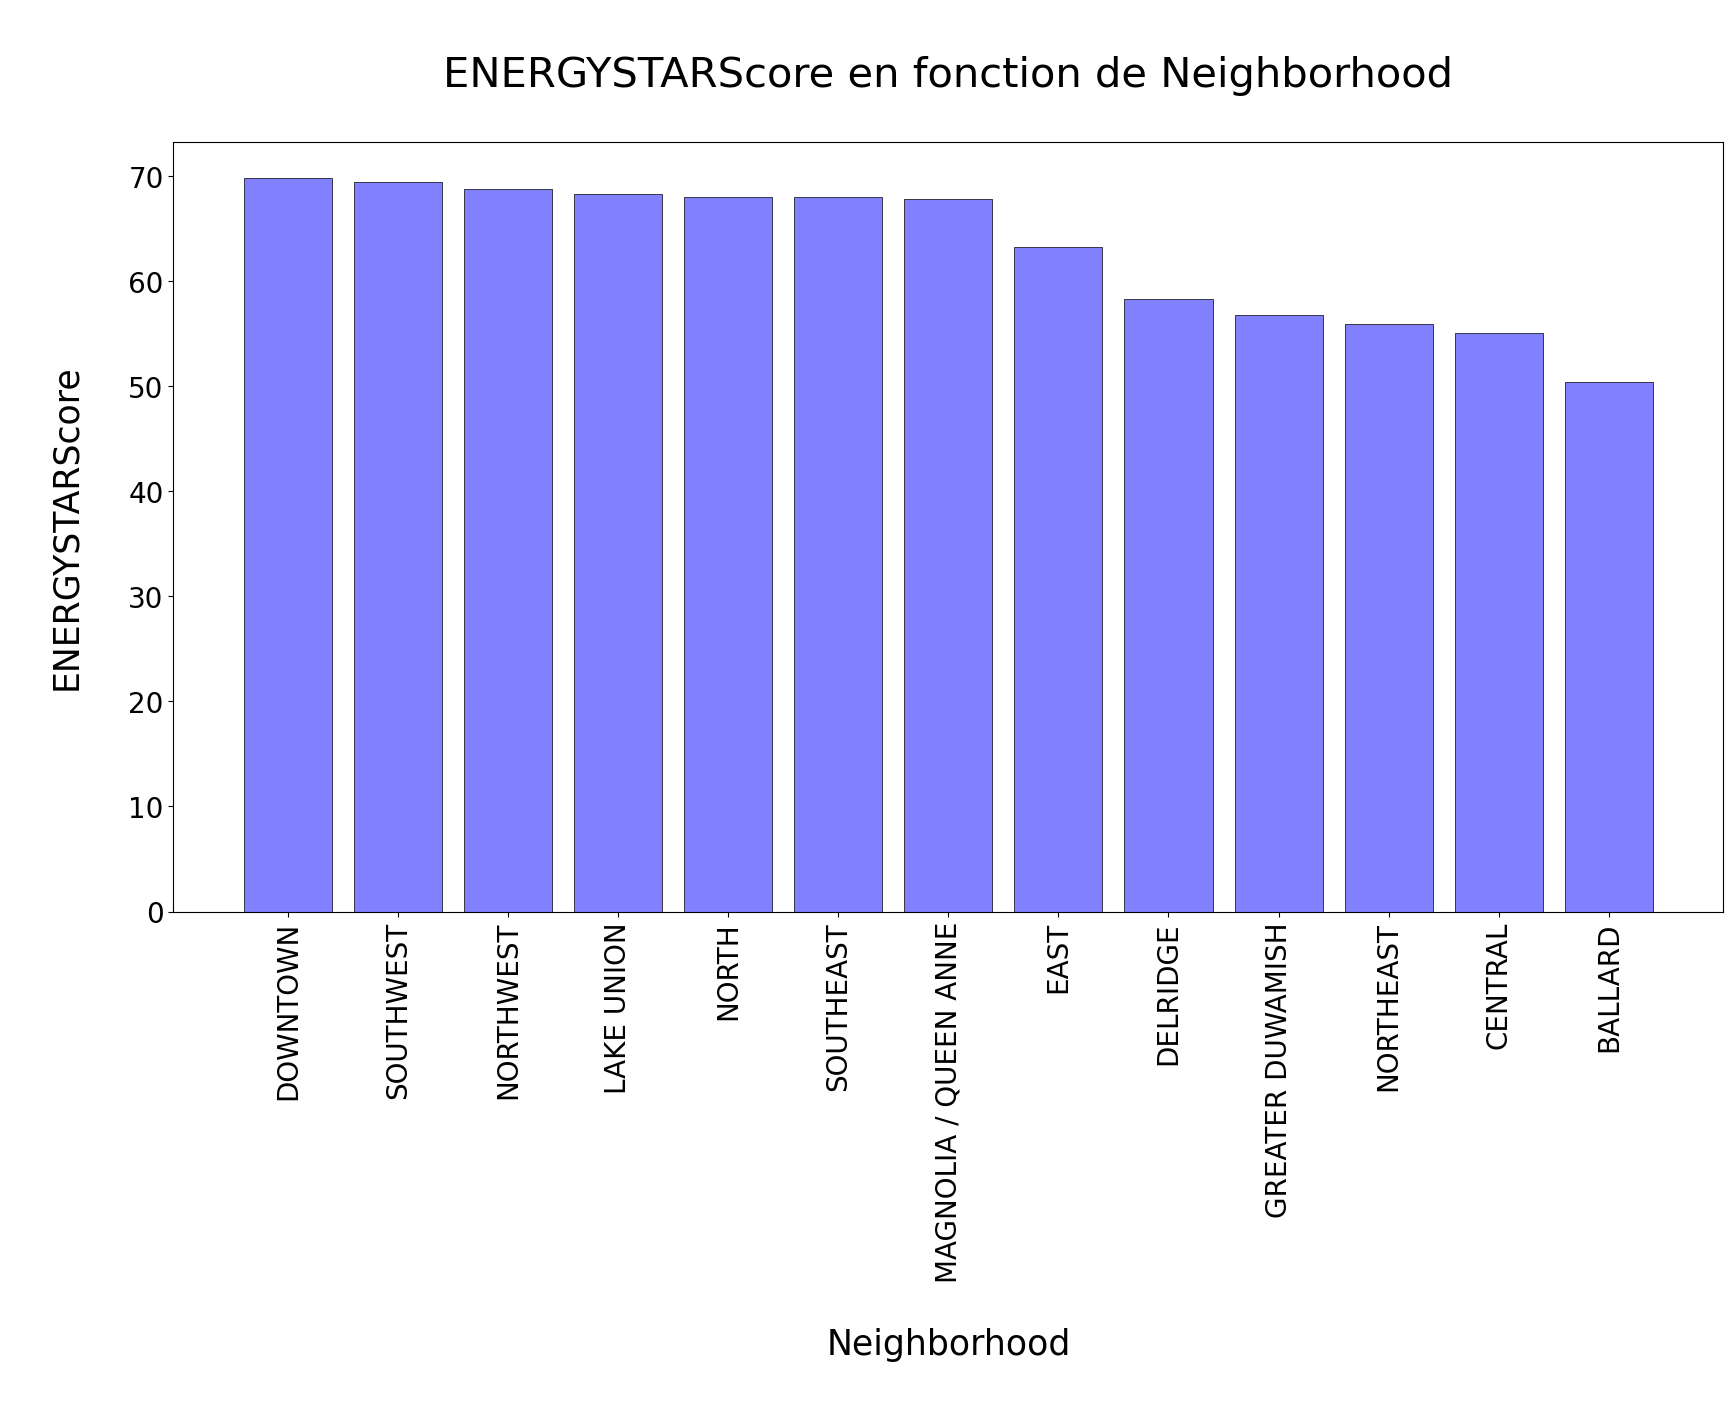

In [31]:
categories = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

for i in categories:

    data = data_clean_score.groupby(i)['ENERGYSTARScore'].mean().sort_values(ascending=False).values
    types = data_clean_score.groupby(i)['ENERGYSTARScore'].mean().sort_values(ascending=False).index

    plt.figure(figsize=(20,10))
    plt.bar(types, data, color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
    plt.title(f"\nENERGYSTARScore en fonction de {i}\n", fontsize=30)
    plt.xticks(fontsize=20, rotation=90)
    plt.yticks(fontsize=20)
    plt.ylabel(f"\nENERGYSTARScore\n", fontsize=25)
    plt.xlabel(f"\n{i}\n", fontsize=25)
    plt.show()

    # Possible sinon de faire directement .plot.bar() après groupby().mean().sort_values()

### **Répartition des bâtiments en fonction de l'année de construction**

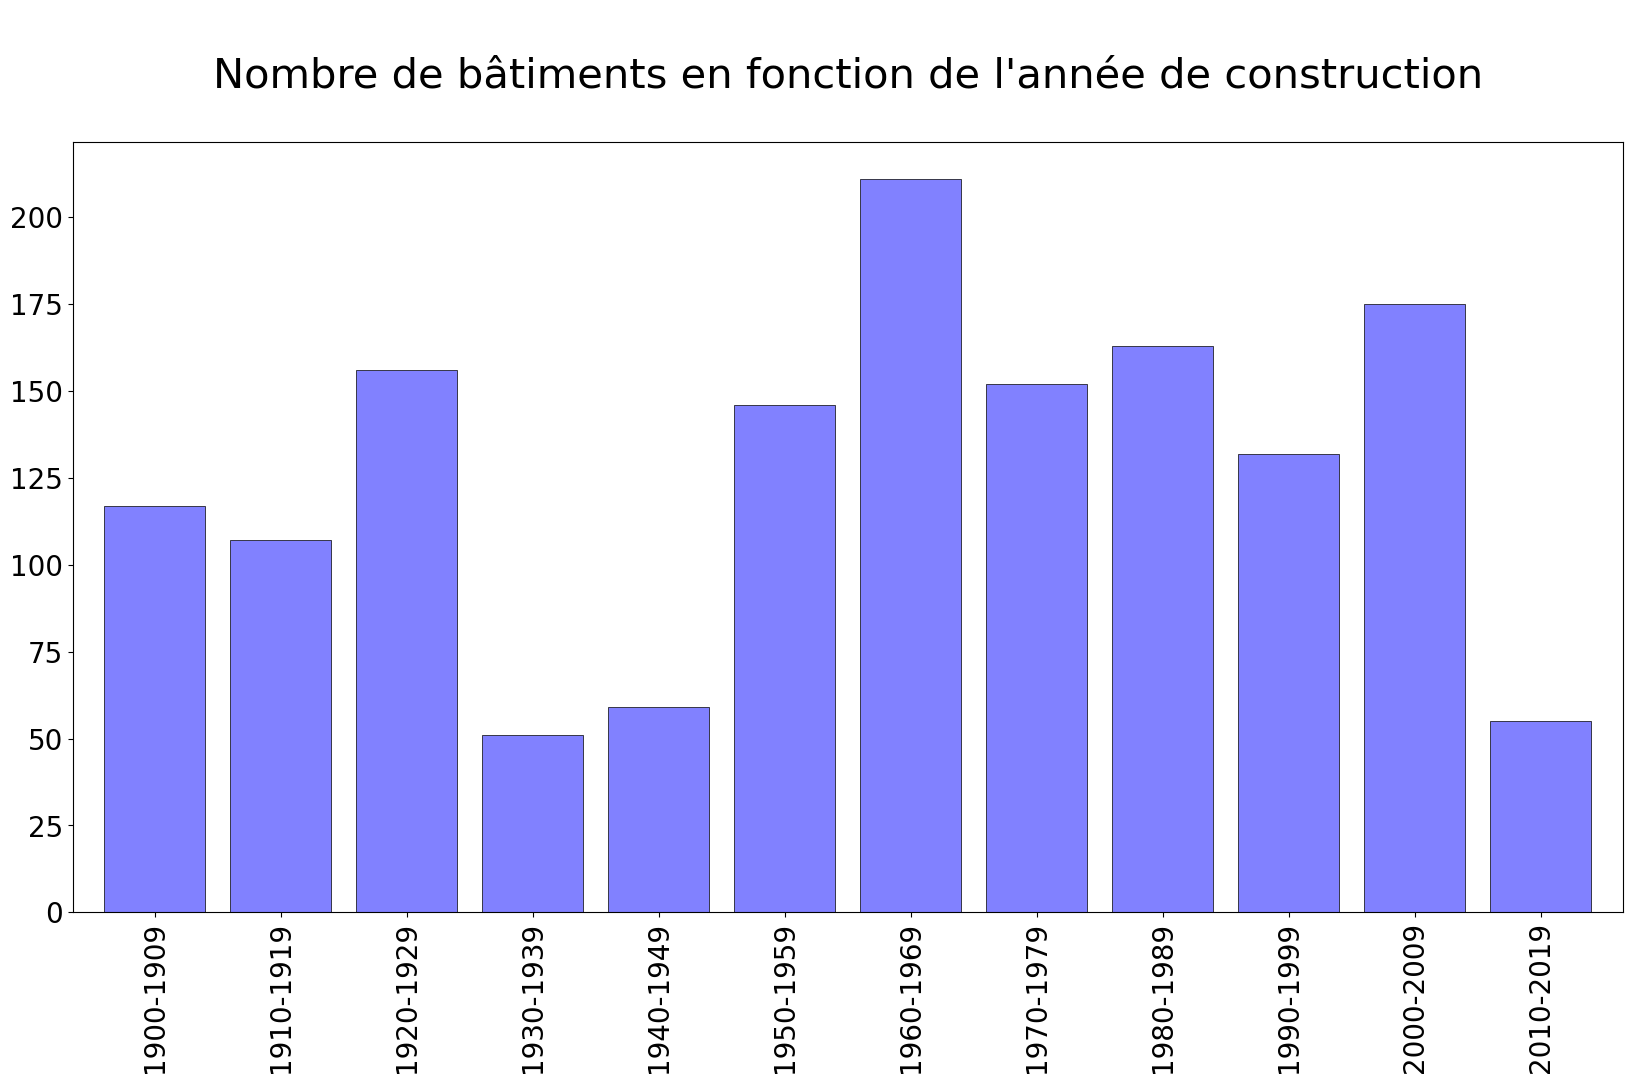

In [32]:
bins = []
for i in range(data_clean['YearBuilt'].min(), data_clean['YearBuilt'].max()+10, 10):
    bins.append(i-1)

labels = []
for i in range(data_clean['YearBuilt'].min(), data_clean['YearBuilt'].max(), 10):
    labels.append(f'{i}-{i+9}')

annees = pd.cut(data_clean['YearBuilt'], bins=bins, labels=labels)

plt.figure(figsize=(20,10))

annees.groupby(annees).count().plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)

plt.title(f"\nNombre de bâtiments en fonction de l'année de construction\n", fontsize=30)
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.ylabel("", fontsize=25)
plt.xlabel("", fontsize=25)
plt.show()

### Consommation d'énergie et émissions de CO2 en fonction de l'année de construction

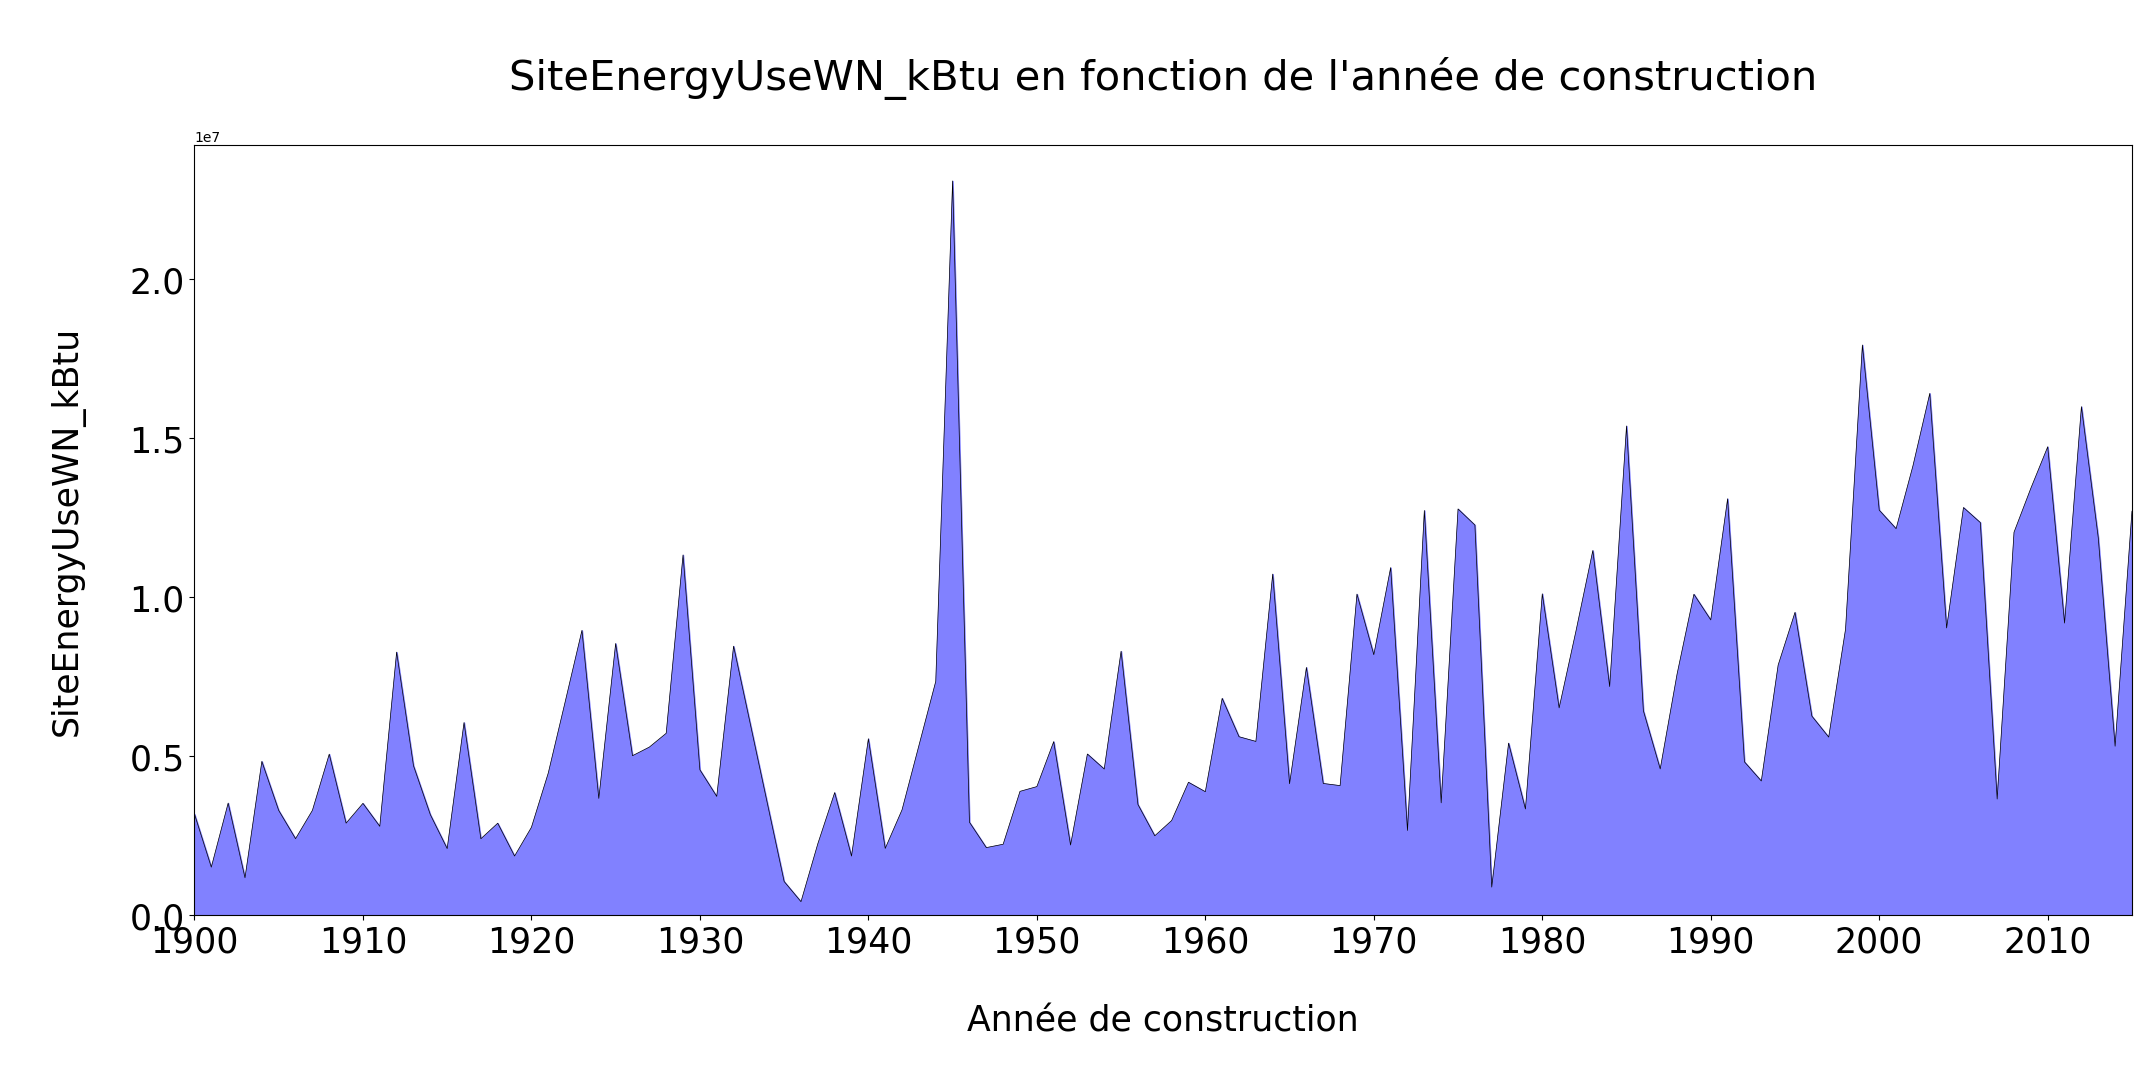

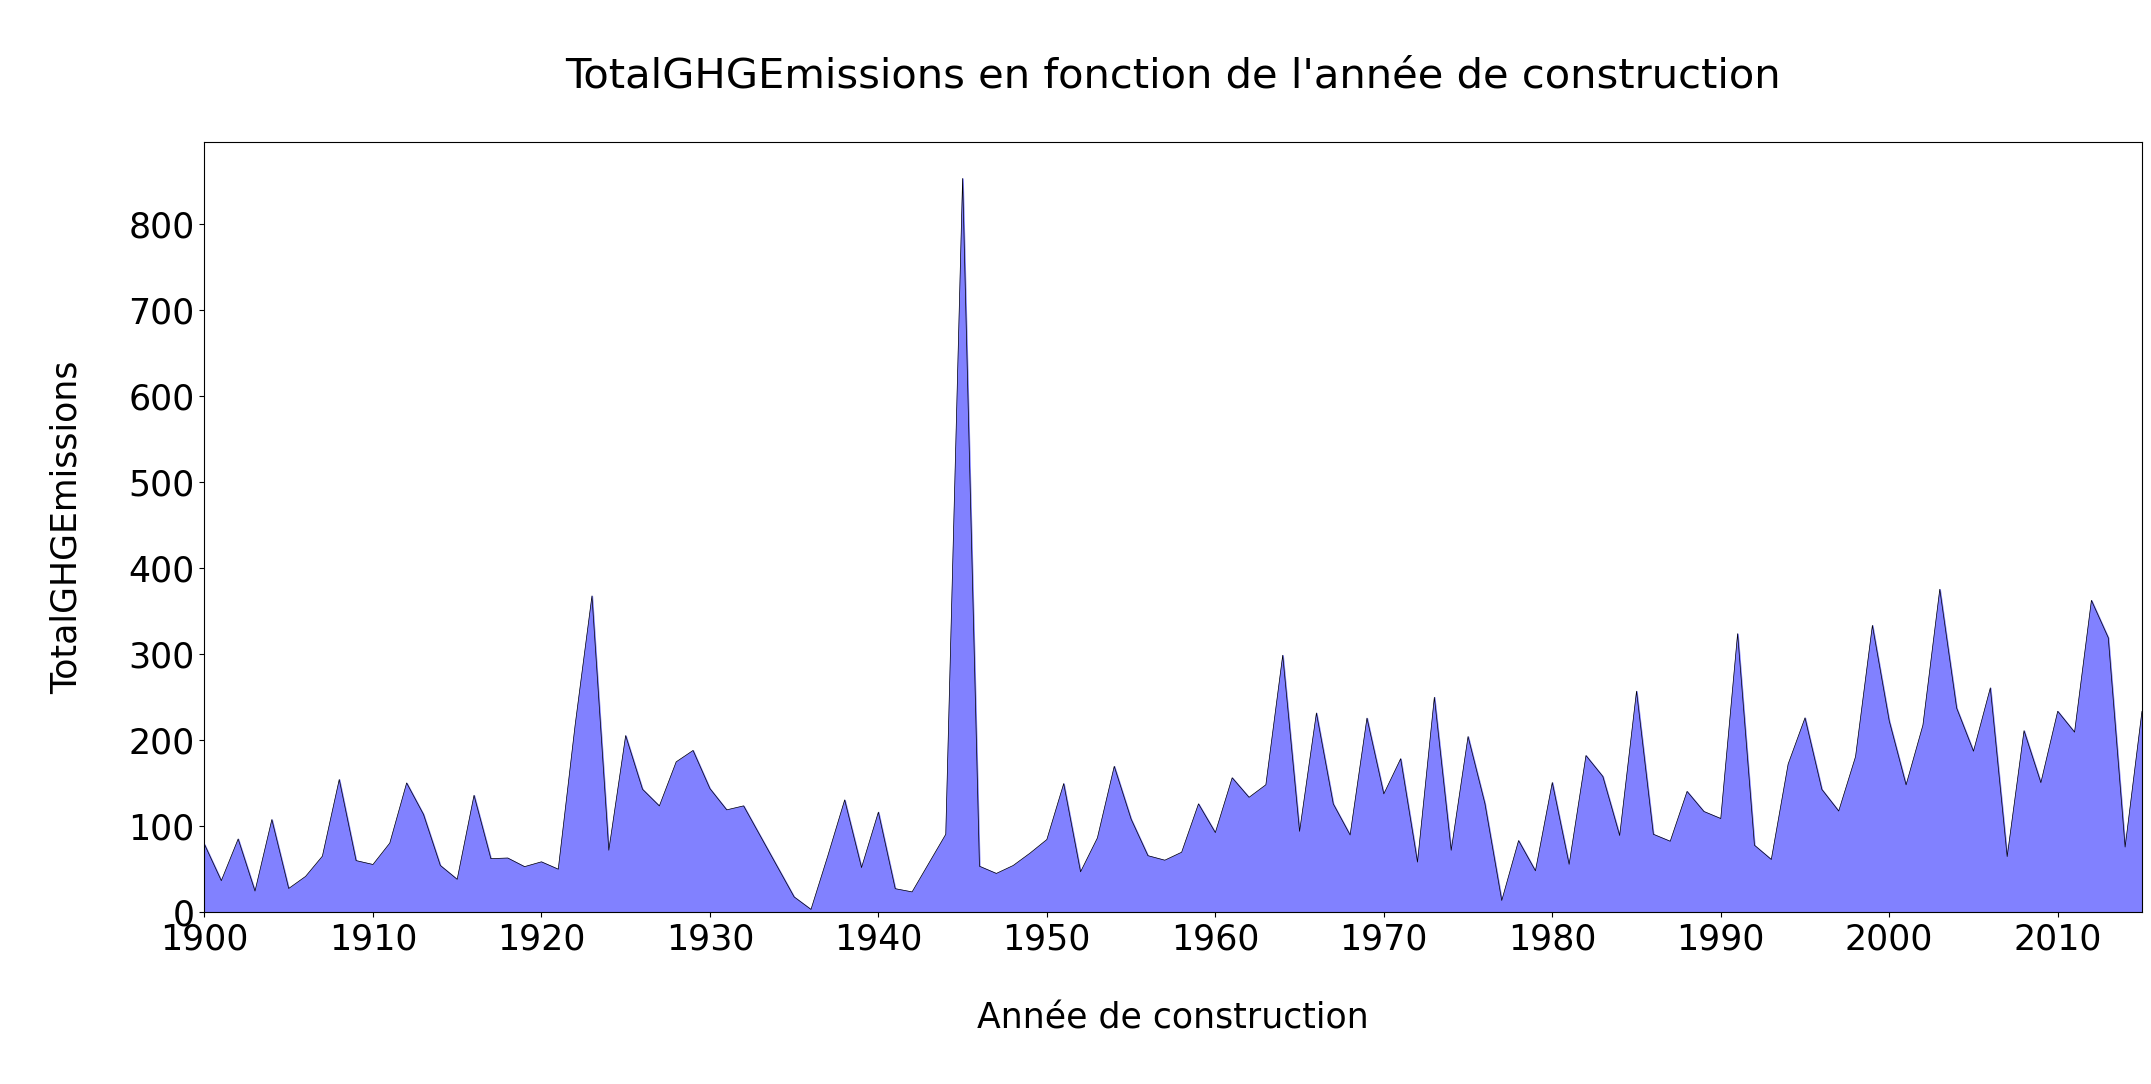

In [33]:
for i in ['SiteEnergyUseWN_kBtu', 'TotalGHGEmissions']:

    plt.figure(figsize=(25, 10))

    ax = sns.lineplot(x='YearBuilt', y=i, data=data_clean, linewidth=0.5, color='black', errorbar=None) # errorbar='sd'

    ax.set_title(f"\n{i} en fonction de l'année de construction\n", fontsize=30)
    ax.set_xlabel("\nAnnée de construction\n", fontsize=25)
    ax.set_ylabel(f"\n{i}\n", fontsize=25)
    ax.tick_params(labelsize=25)
    ax.set_xlim(data_clean['YearBuilt'].min(), data_clean['YearBuilt'].max())
    # Pour paramétrer la fréquence des labels sur x
    plt.xticks(np.arange(data_clean['YearBuilt'].min(), data_clean['YearBuilt'].max(), 10))
    # Juste limite inférieure pour y, pour que 0 soit bien collé en bas
    ax.set_ylim(0)

    # Pour remplir sous la ligne
    l1 = ax.lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    ax.fill_between(x1, y1, color="#8181FF", alpha=1)

    plt.show()

### Consommation d'énergie et émissions de CO2 en fonction de *NumberofFloors*

Les graphiques ne sont pas très parlant pour les autres variables *NumberofBuildings*, *PropertyGFAParking* et *PropertyGFABuilding(s)*.

##############################
NumberofFloors :
##############################


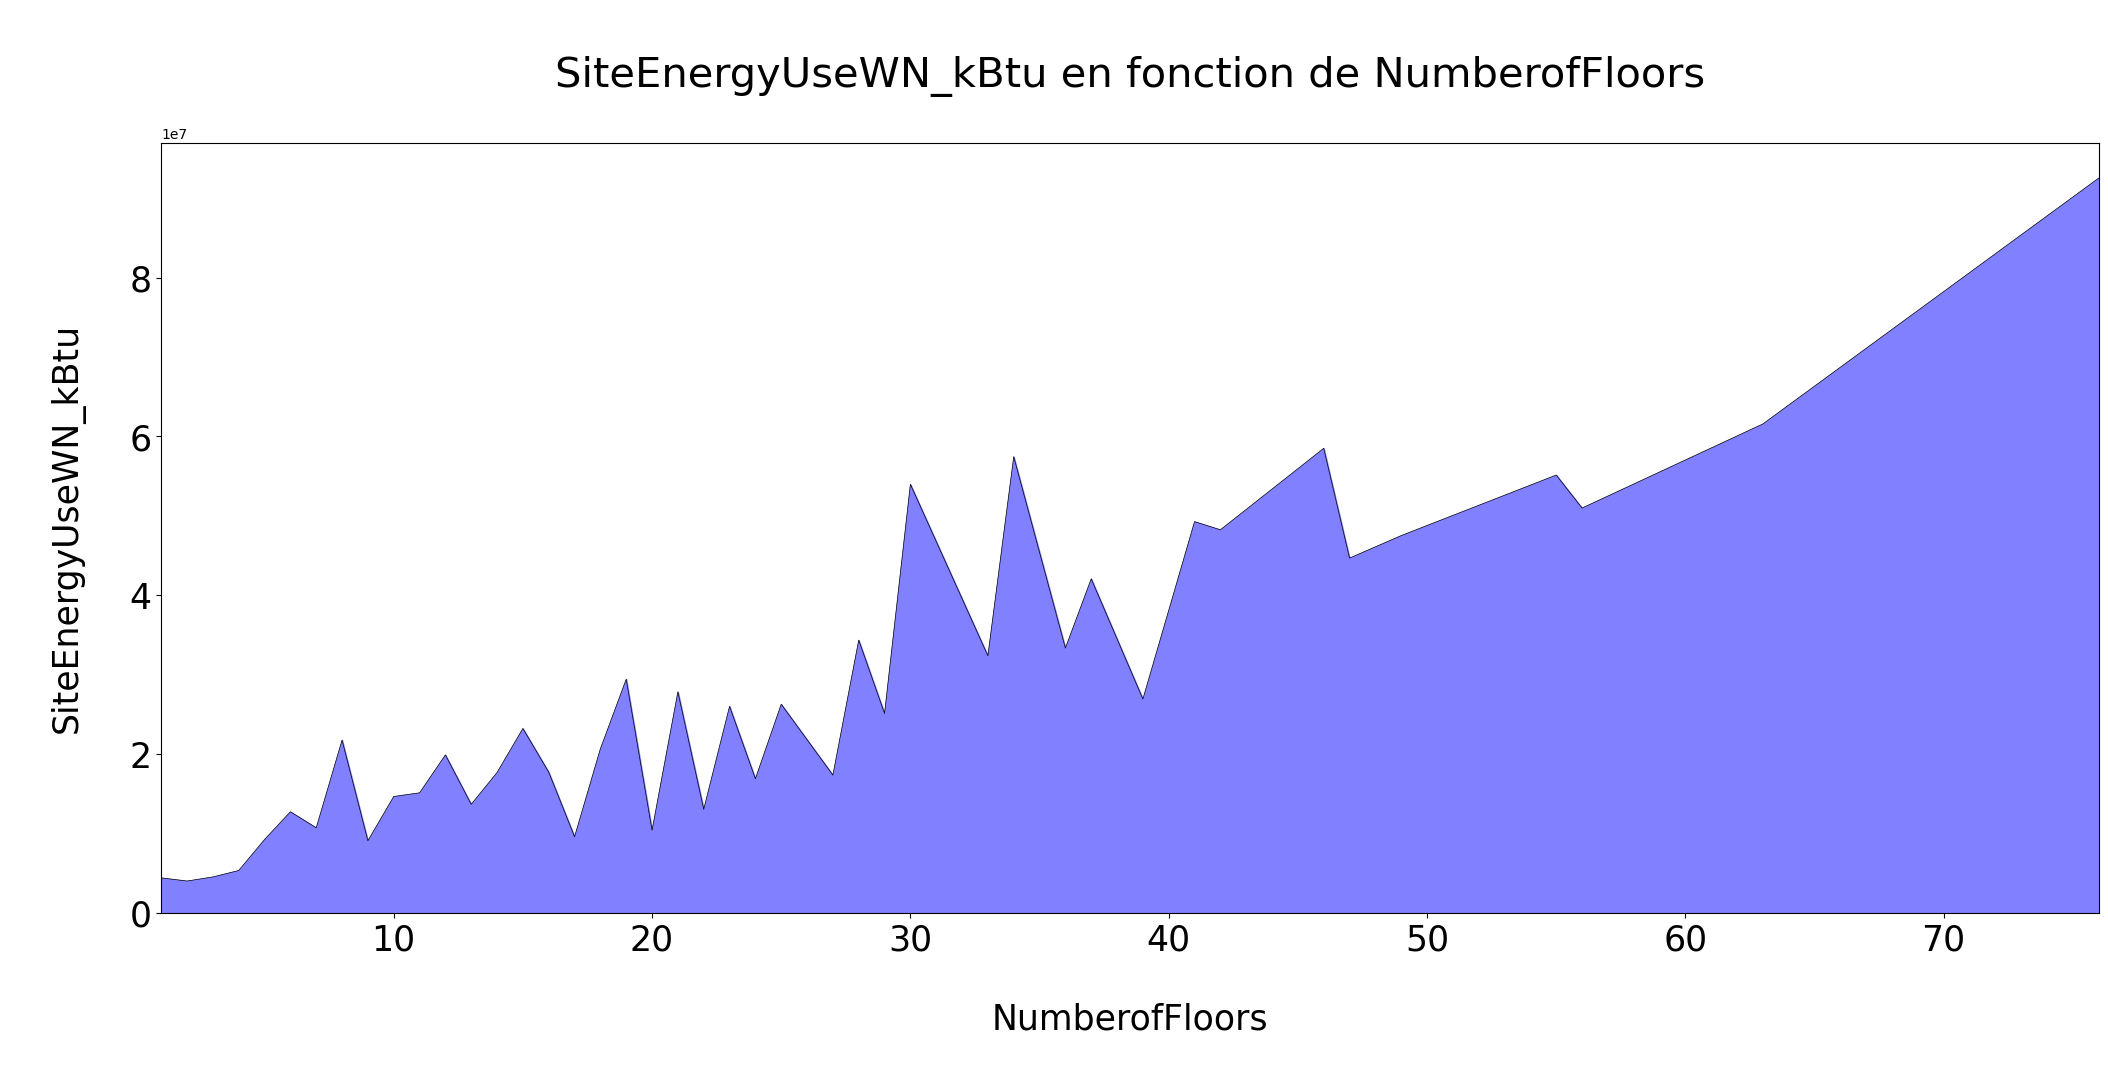

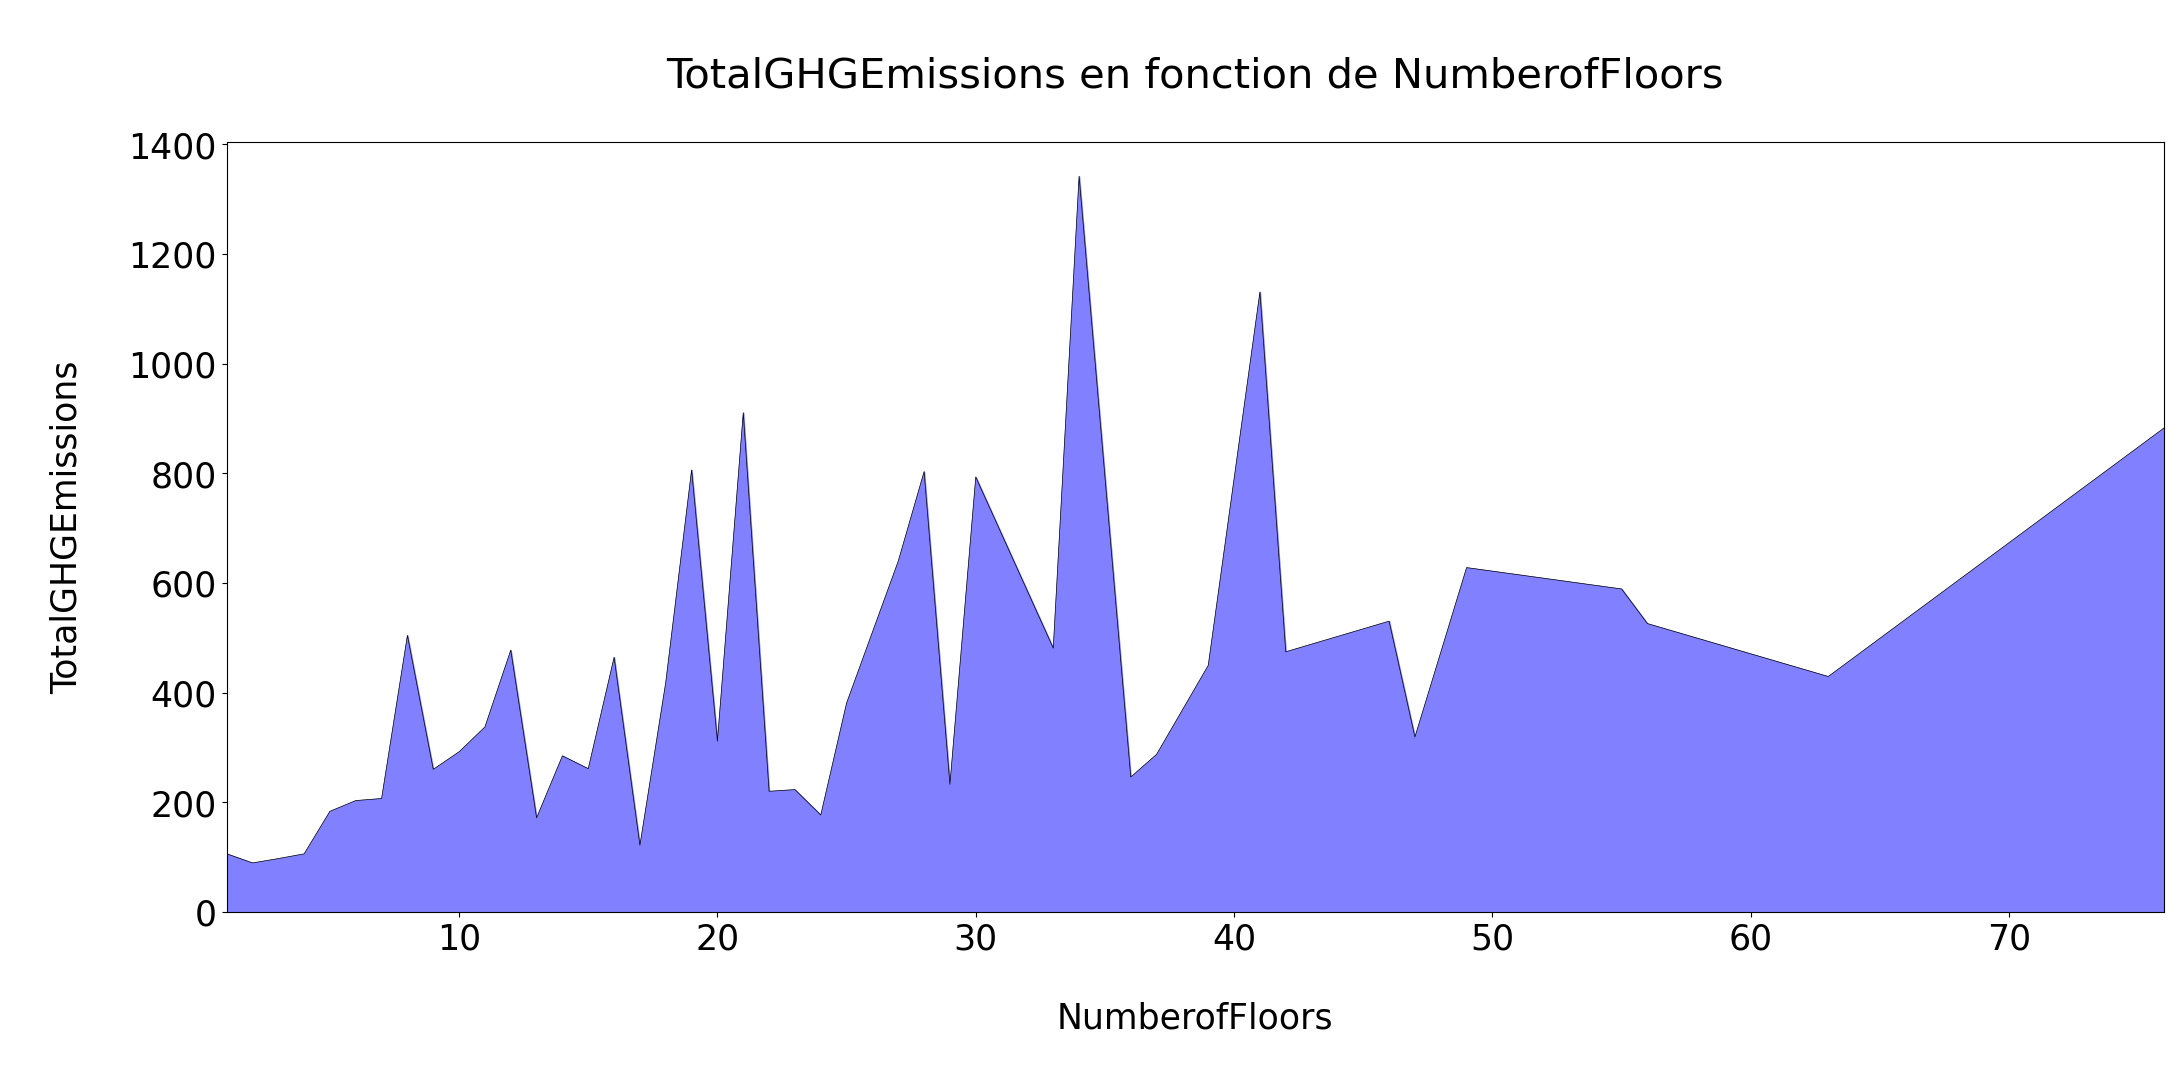

In [34]:
for j in ['NumberofFloors']:
       
       print("#"*30)
       print(j, ":")
       print("#"*30)

       for i in ['SiteEnergyUseWN_kBtu', 'TotalGHGEmissions']:

              plt.figure(figsize=(25, 10))

              ax = sns.lineplot(x=j, y=i, data=data_clean, linewidth=0.5, color='black', errorbar=None) # errorbar='sd'

              ax.set_title(f"\n{i} en fonction de {j}\n", fontsize=30)
              ax.set_xlabel(f"\n{j}\n", fontsize=25)
              ax.set_ylabel(f"\n{i}\n", fontsize=25)
              ax.tick_params(labelsize=25)
              ax.set_xlim(data_clean[j].min(), data_clean[j].max())
              # Pour paramétrer la fréquence des labels sur x
              #plt.xticks(np.arange(data_clean[j].min(), data_clean[j].max(), 10))
              # Juste limite inférieure pour y, pour que 0 soit bien collé en bas
              ax.set_ylim(0)

              # Pour remplir sous la ligne
              l1 = ax.lines[0]
              x1 = l1.get_xydata()[:, 0]
              y1 = l1.get_xydata()[:, 1]
              ax.fill_between(x1, y1, color="#8181FF", alpha=1)

              plt.show()

## **Analyse en composantes principales (ACP)**

### **Fonction de réalisation de l'ACP**

In [35]:
def acp_complete(composantes=3, variables=None, **kwargs):
    
    # Je mets ces variables en global, car elles pourront être utilisées par d'autres fonctions
    global pca
    global features
    global X_scaled
    global n_components
    
    ################## Récupération des données ##################

    # Variables qu'on va utiliser pour l'ACP
    a_garder_pour_acp = variables

    # Valeurs prises par les variables, retourne un numpy array
    X = data_clean[a_garder_pour_acp].values

    # On récupère le nom de chaque variable
    features = data_clean[a_garder_pour_acp].columns

    # On récupère le nom des index, on aurait pu aussi récupérer les valeurs d'une variable (ex nom des produits)
    # Pas nécessaire ici, la colonne nom a été retirée,
    # et de toute façon il y a beaucoup trop de valeur, ça serait illisible
    # names = data_clean[a_garder_pour_acp].index


    ################## Scaling des données ##################

    # On instancie le scaler
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    # On espère avoir une moyenne à 0 et un écart type à 1
    idx = ["mean", "std"]
    print("Moyennes et écarts types après scaling des données (objectifs moyenne à 0 et écart type à 1) : ")
    display(pd.DataFrame(X_scaled).describe().round(2).loc[idx, :])

    ################## Réalisation de l'ACP ##################

    # On choisit le nombre de composantes sur lequel on veut travailler : 
    n_components = composantes

    # Instancie notre ACP :
    pca = PCA(n_components=n_components)

    # On l'entraine sur les données scalées : 
    pca.fit(X_scaled)

    # Variance captée par chaque nouvelle composante
    print("-"*50)
    print(f"Nombre de composantes choisies : {n_components}\n")
    print("Variances captées par les composantes :\n")
    for i in range(n_components):
        print(f"Composante n°{i+1} : {round(pca.explained_variance_ratio_[i]*100, 2)} %")

    print(f"\nEnsembles, ces {n_components} composantes captent {(pca.explained_variance_ratio_*100).round(2).sum():.2f} % de la variance.")
    print("-"*50)

    ################## Tracé de l'ébouli des valeurs propres ##################

    # On met les variances captées par les composantes dans une variable (*100 pour convertir en %)
    scree = (pca.explained_variance_ratio_*100).round(2)
    # On crée une variable avec la somme cumulée de ces variances captées
    scree_cum = scree.cumsum().round()
    # On crée une liste du nombre de composantes
    x_list = list(range(1, n_components+1))

    # Tracé de l'éboulis des valeurs propres
    plt.figure(figsize=(10,10))
    plt.bar(x_list, scree, color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
    plt.plot(x_list, scree_cum,c="red",marker='o')
    plt.xlabel("\nRang de l'axe d'inertie\n", fontsize=25)
    plt.ylabel("\nPourcentage d'inertie\n", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(np.arange(min(x_list), max(x_list)+1, 1)) # Pour que les xticks n'affichent que nos numéros de composantes
    plt.title("\nÉboulis des valeurs propres\n", fontsize=30)
    plt.show(block=False)

    ################## Représentation des composantes ##################

    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = features
    pcs.index = [f"F{i}" for i in x_list]
    print("-"*50)
    print("\nComposantes de l'ACP :\n")
    # .T pour transposer et mettre les axes d'inertie en colonne
    display(pcs.T)

    # Représentation du tableau sous forme d'une heatmap
    fig, ax = plt.subplots(figsize=(20, 15))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f", annot_kws={"size": 20});
    plt.title("\nComposantes de l'ACP\n", fontsize=30)
    plt.xlabel("\nComposantes\n", fontsize=25)
    plt.ylabel("\nVariables\n", fontsize=25)
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)
    plt.show()



### **Variables à tester pour l'ACP**

Je vais prendre les variables structurelles numériques (sauf l'année): *NumberofBuildings*, *NumberofFloors*, *PropertyGFAParking*, *PropertyGFABuilding(s)*

In [36]:
variables_a_tester = [
                      'NumberofBuildings',
                      'NumberofFloors',
                      'PropertyGFAParking',
                      'PropertyGFABuilding(s)'
                     ]

### **Réalisation de l'ACP**

Moyennes et écarts types après scaling des données (objectifs moyenne à 0 et écart type à 1) : 


0    1    2    3
mean -0.0 -0.0  0.0 -0.0
std   1.0  1.0  1.0  1.0

--------------------------------------------------
Nombre de composantes choisies : 4

Variances captées par les composantes :

Composante n°1 : 54.23 %
Composante n°2 : 25.5 %
Composante n°3 : 13.78 %
Composante n°4 : 6.49 %

Ensembles, ces 4 composantes captent 100.00 % de la variance.
--------------------------------------------------


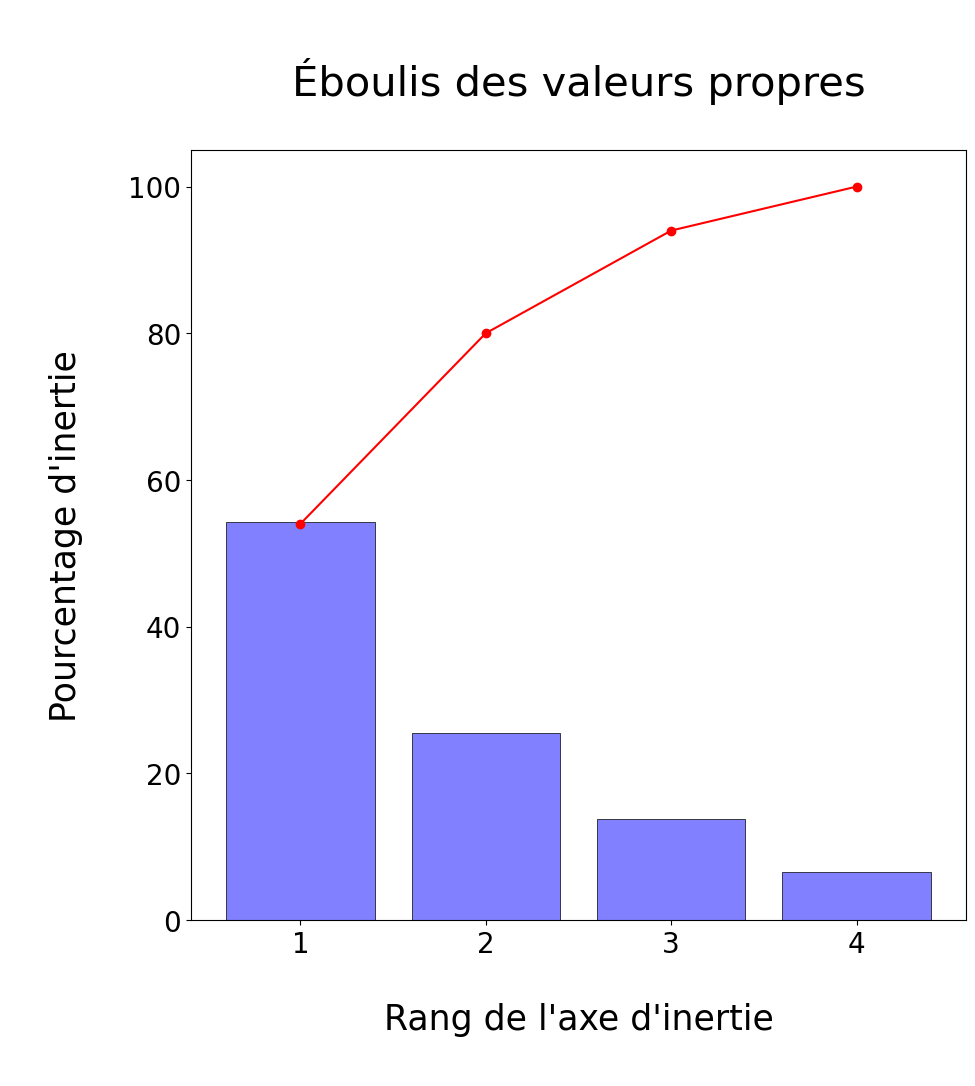

--------------------------------------------------

Composantes de l'ACP :



F1        F2        F3        F4
NumberofBuildings       0.034058  0.982843  0.110419 -0.143765
NumberofFloors          0.608310 -0.093055 -0.305430 -0.726645
PropertyGFAParking      0.525780 -0.097852  0.839034  0.100017
PropertyGFABuilding(s)  0.593595  0.125644 -0.436512  0.664316

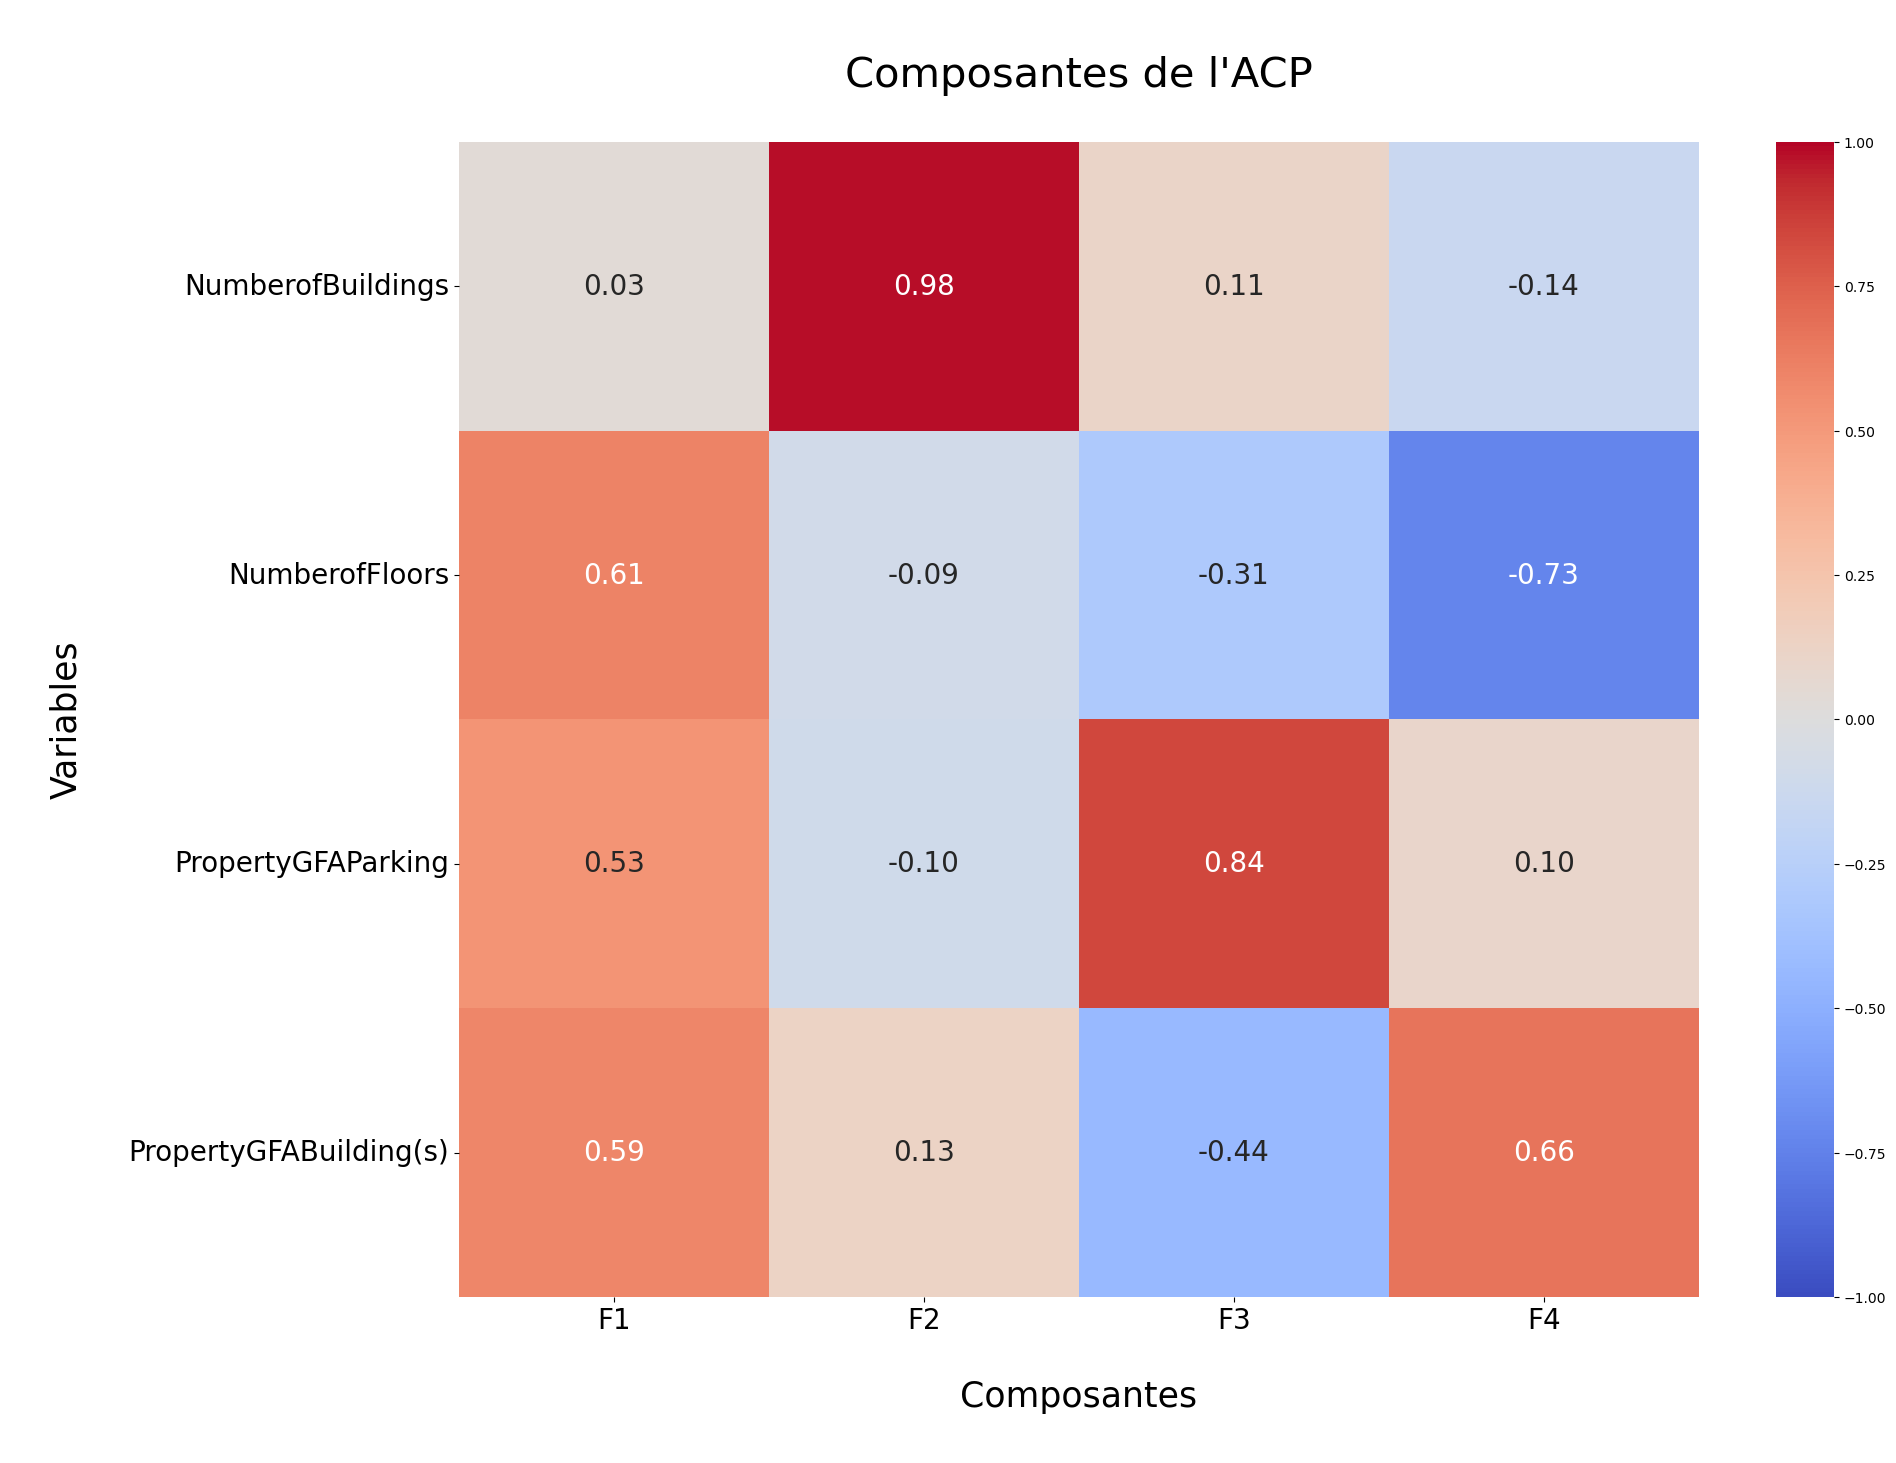

In [37]:
acp_complete(composantes=4, variables=variables_a_tester)

### **Fonction pour les cercles des corrélations**

In [38]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(20, 20))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.03,
                head_length=0.03,
                width=0.007,
                color="#8181FF"
                )

        # Les labels
        plt.text(pca.components_[x, i] + 0.03,
                 pca.components_[y, i] + 0.03,
                 features[i],
                 fontsize=20
                 )

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('\nF{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize=25)
    plt.ylabel('\nF{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)), fontsize=25)

    plt.title("\nCercle des corrélations (F{} et F{})\n".format(x+1, y+1), fontsize=30)

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), color="#8181FF")  # ajout d'un cercle unitaire pour l'échelle

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

### **Tracé des cercles des corrélations**

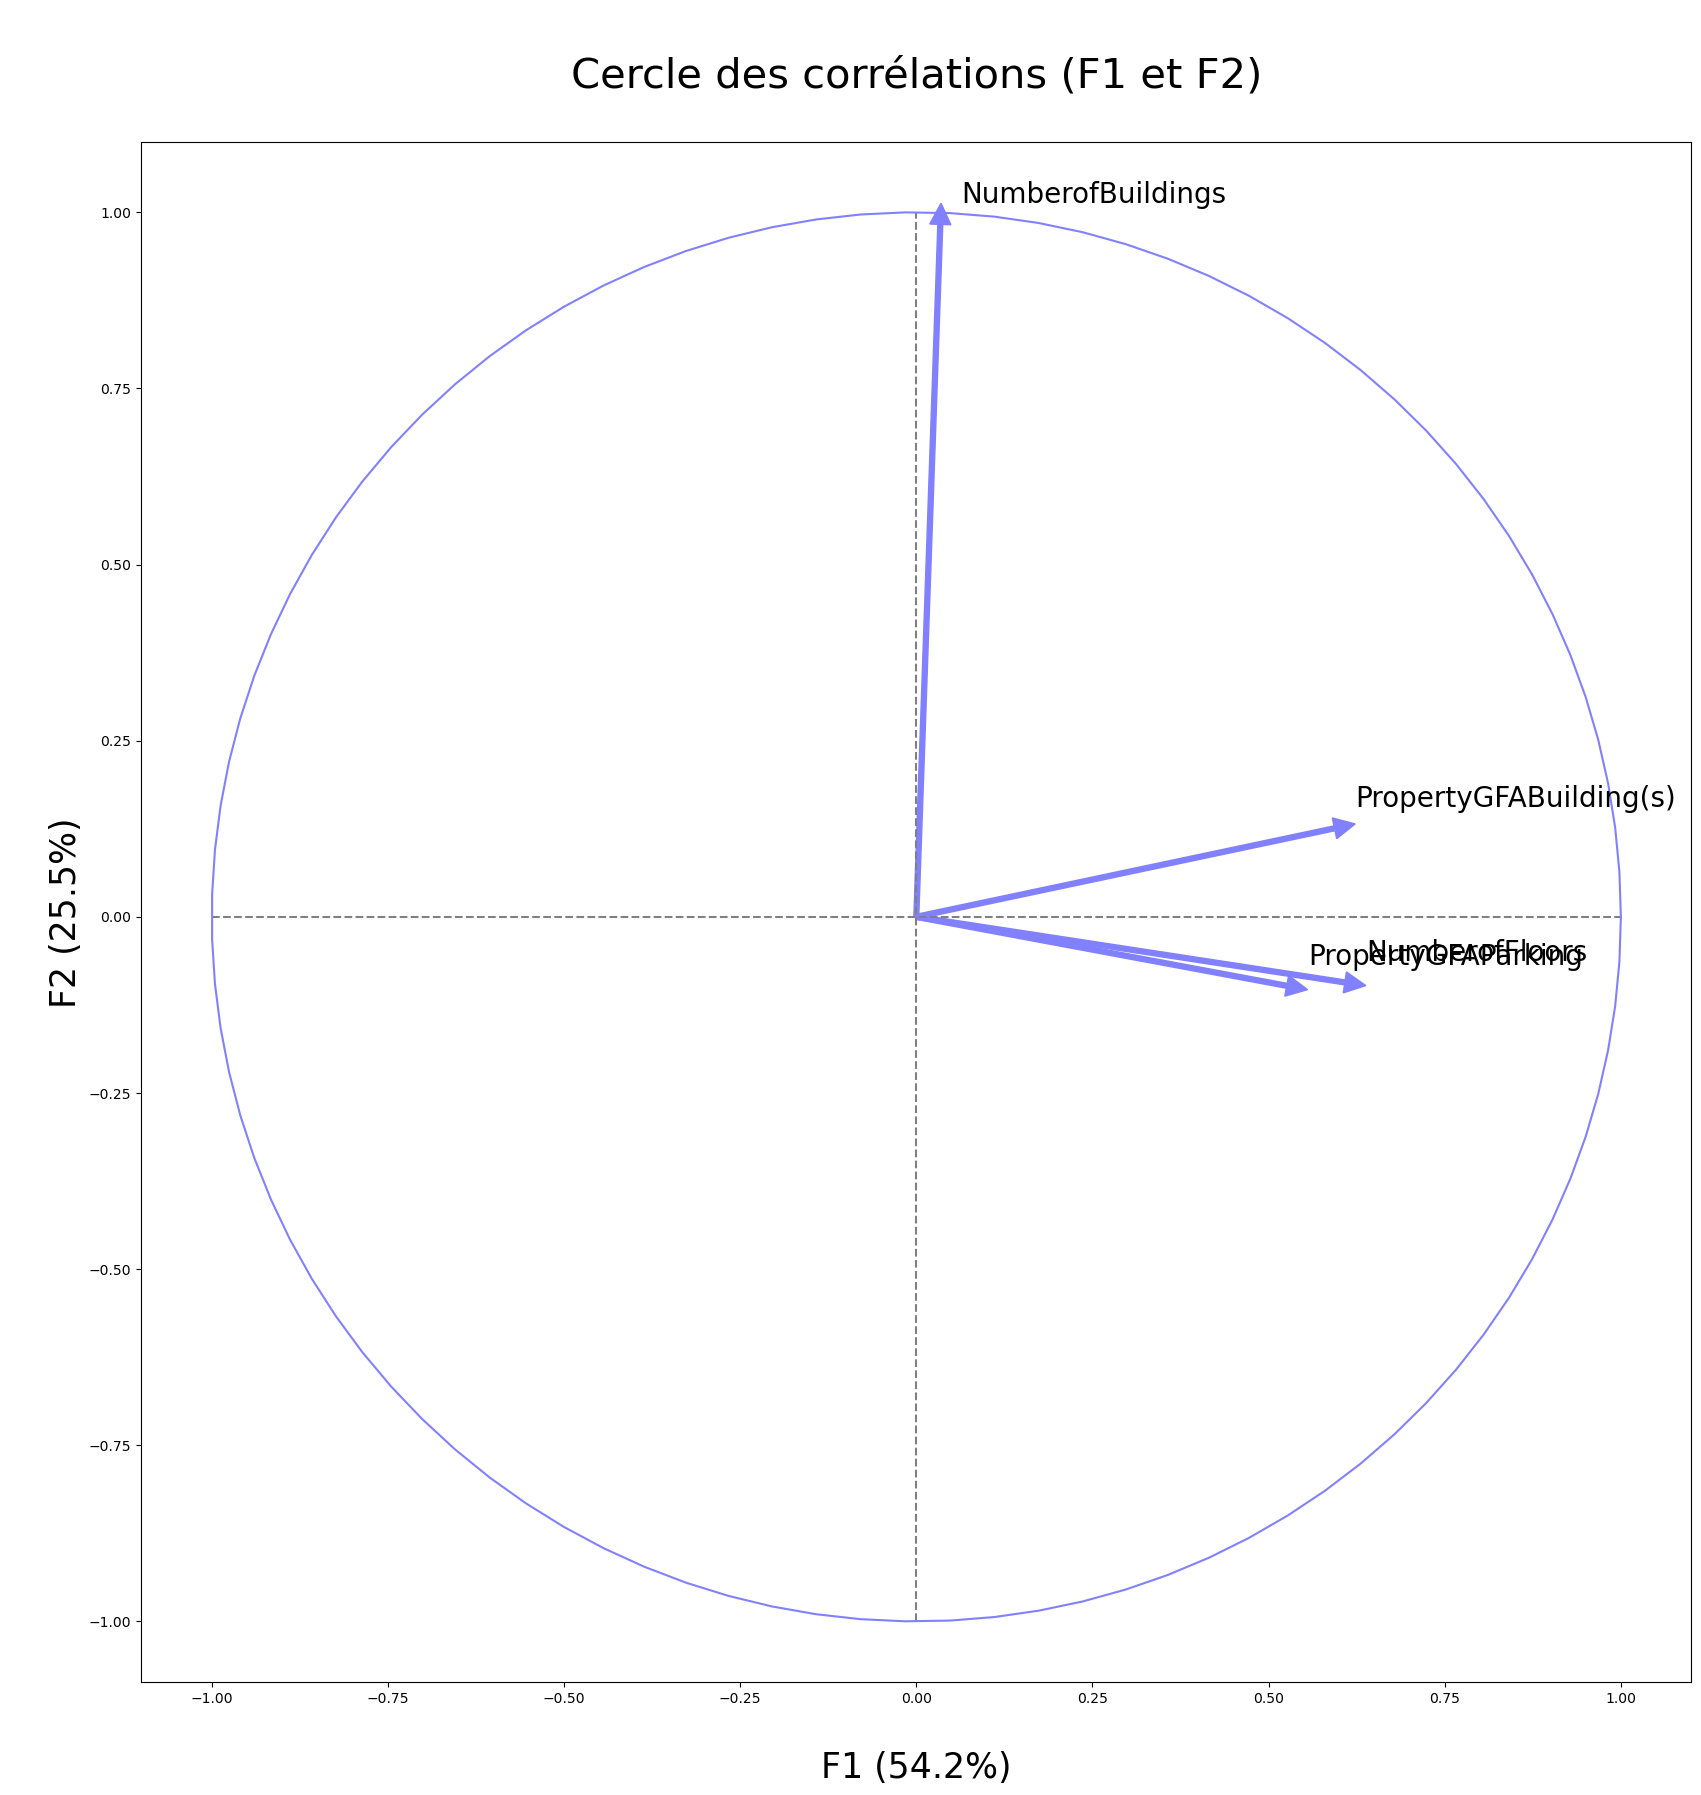

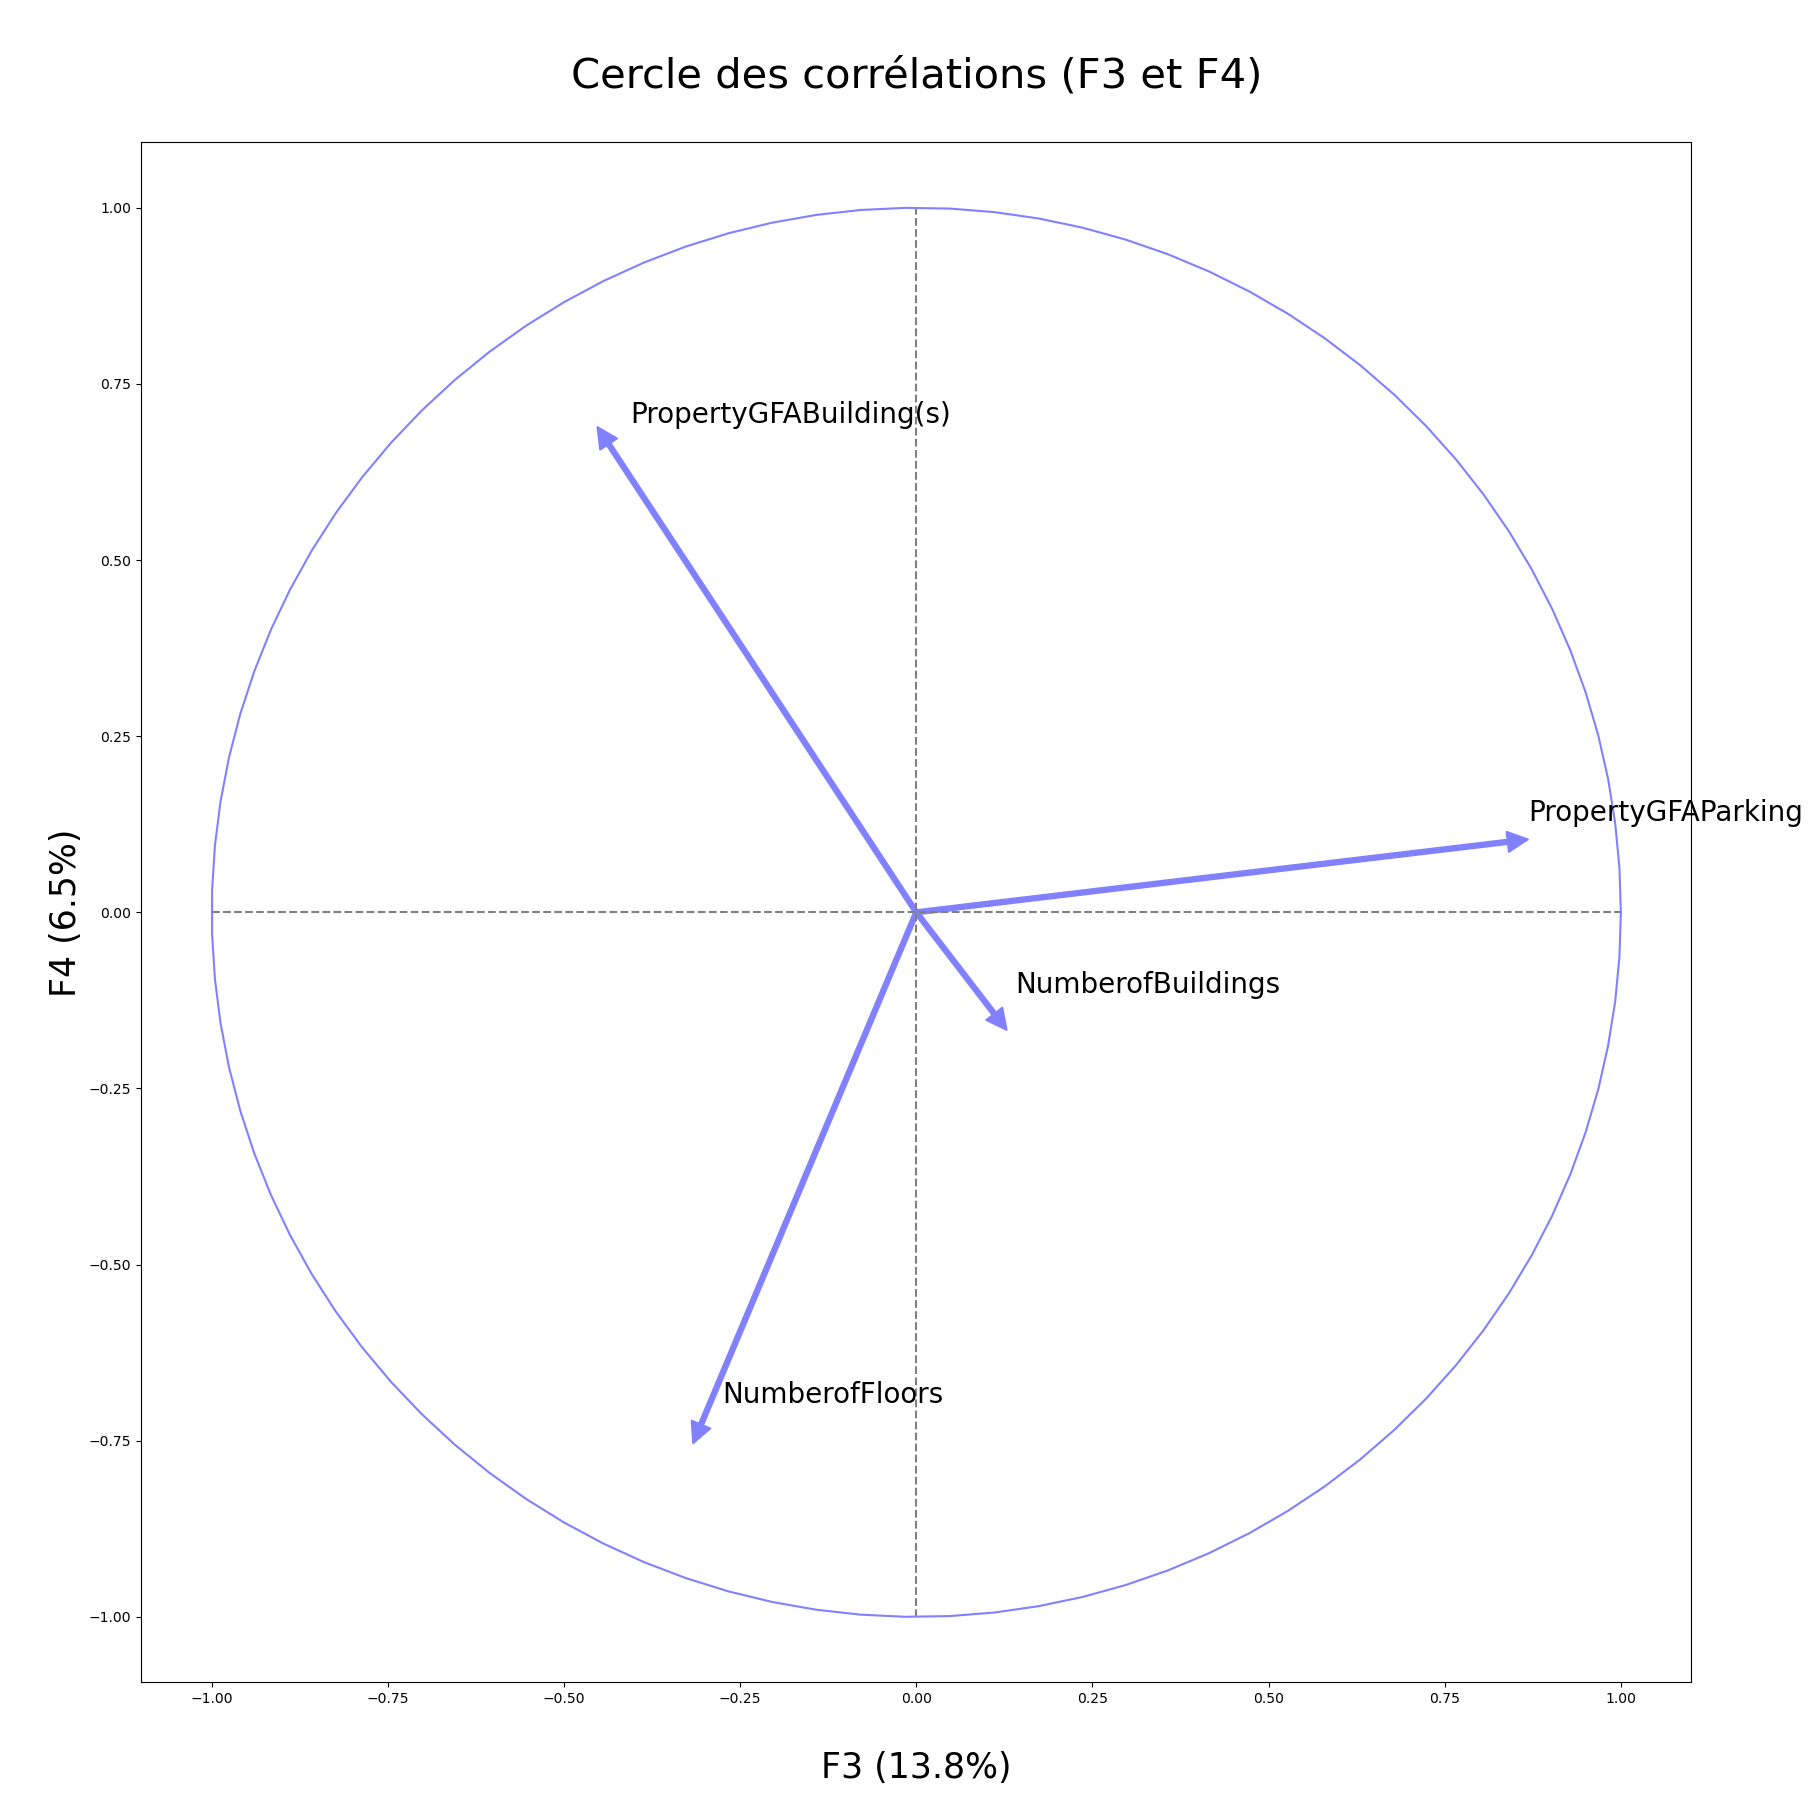

In [39]:
plans = []
a = 0

if n_components%2 == 0:
    plan_iter = n_components
else:
    plan_iter = n_components-1 

for i in range(int(plan_iter/2)):
    plans.append([a+i, a+1+i])
    a +=1

for i in plans:
    x_y = i
    correlation_graph(pca, x_y, features)

## **Analyse de la variance (ANOVA)**

Je vais faire des ANOVA avec les variables catégorielles suivantes : *BuildingType*, *PrimaryPropertyType*, *Neighborhood*, *YearBuilt*.

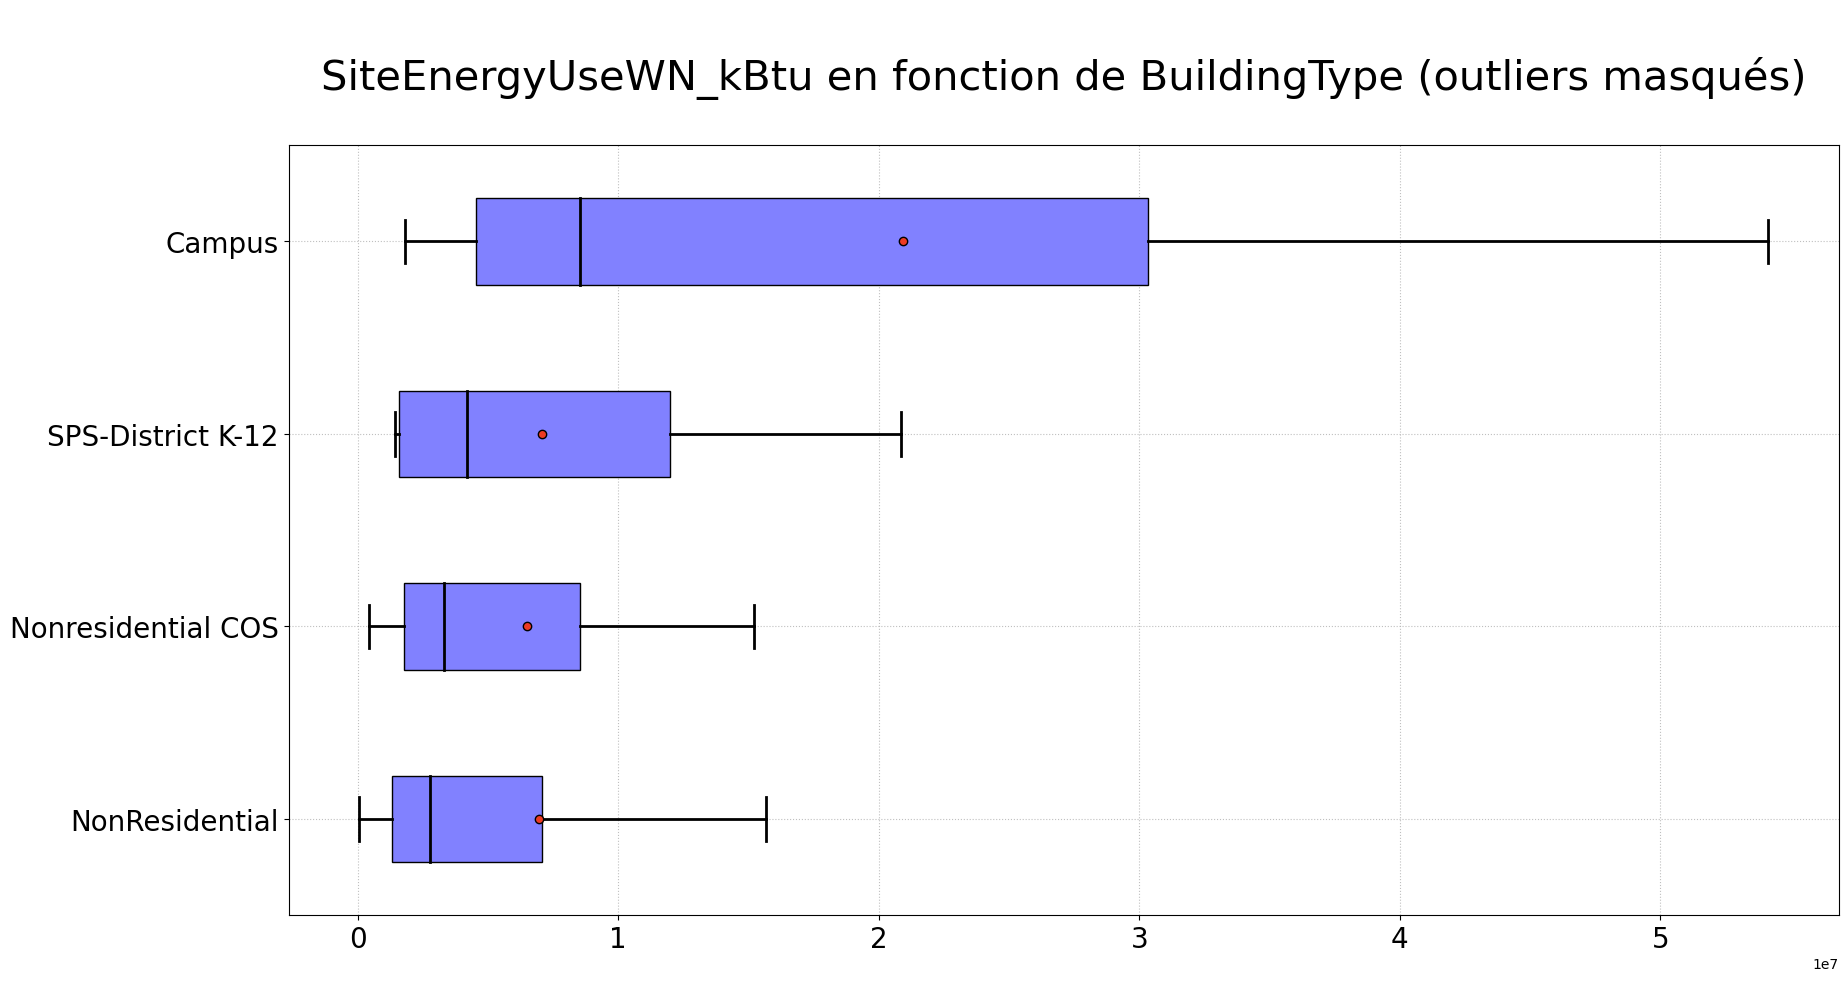

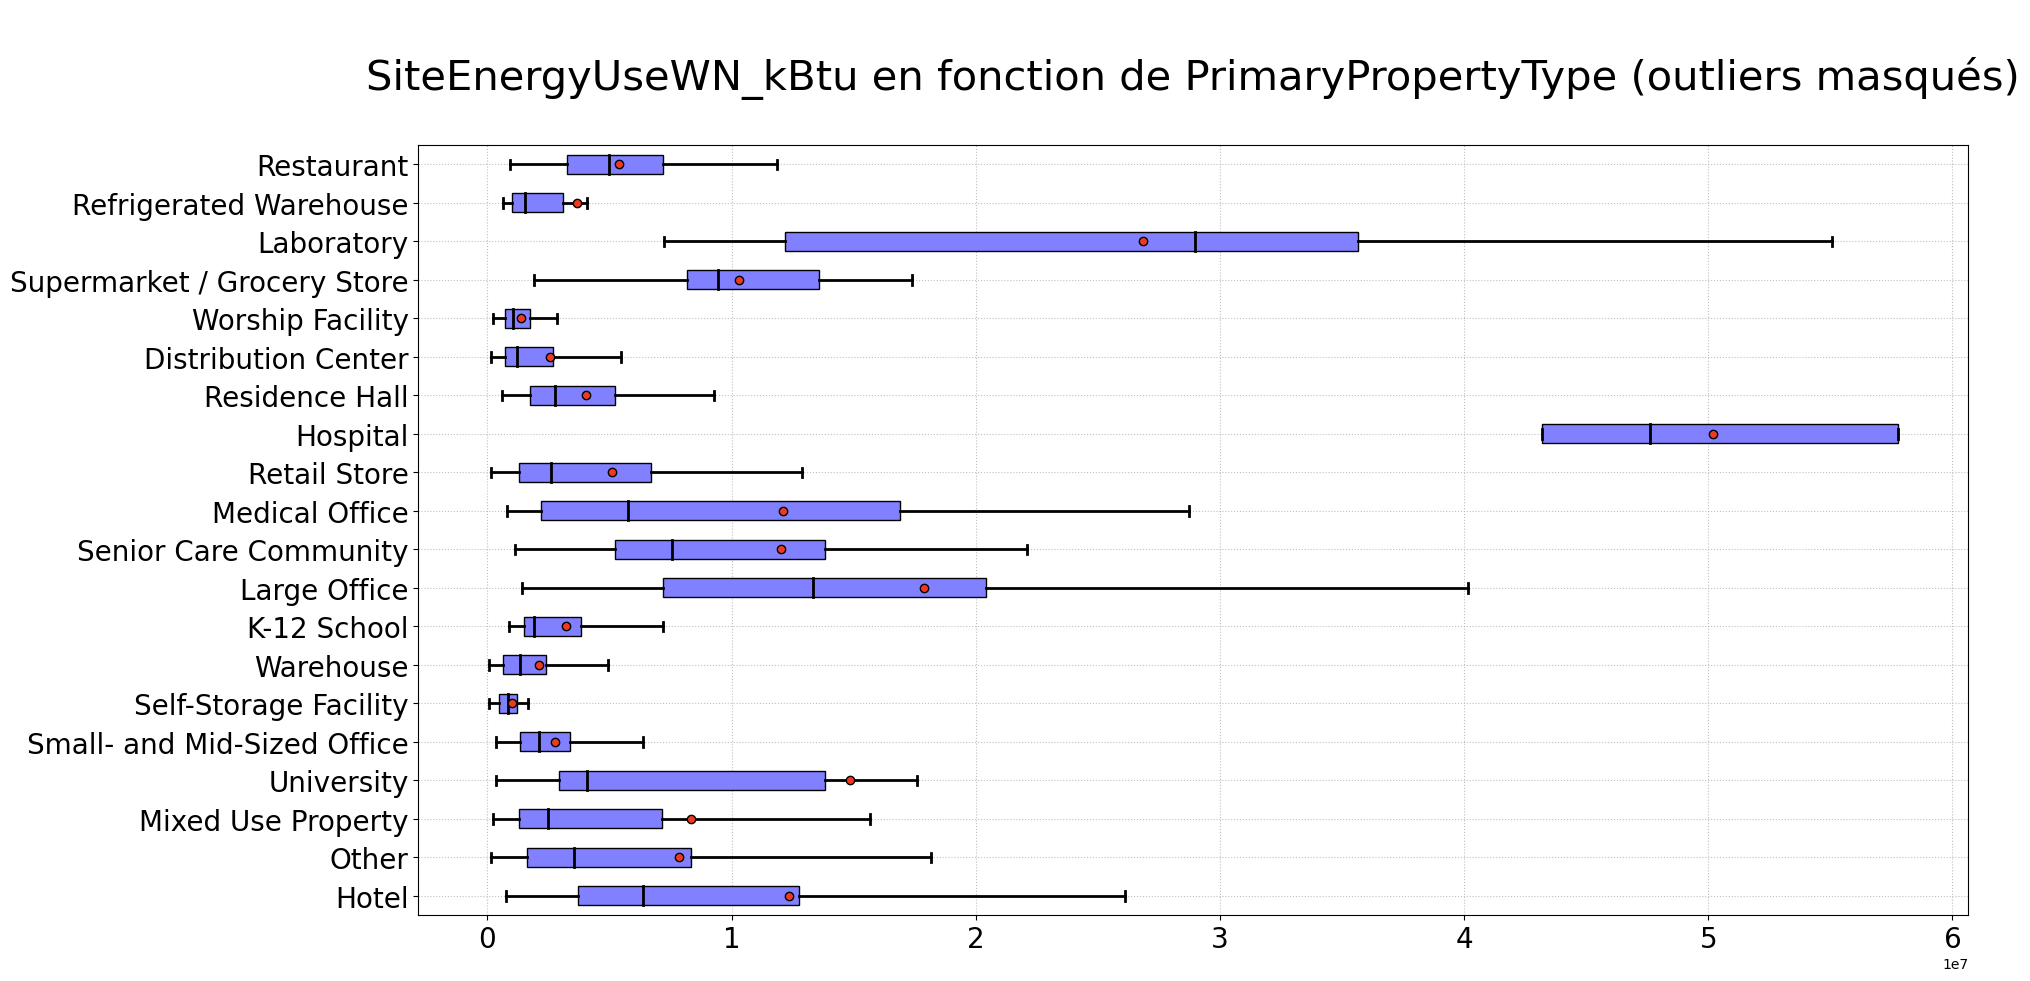

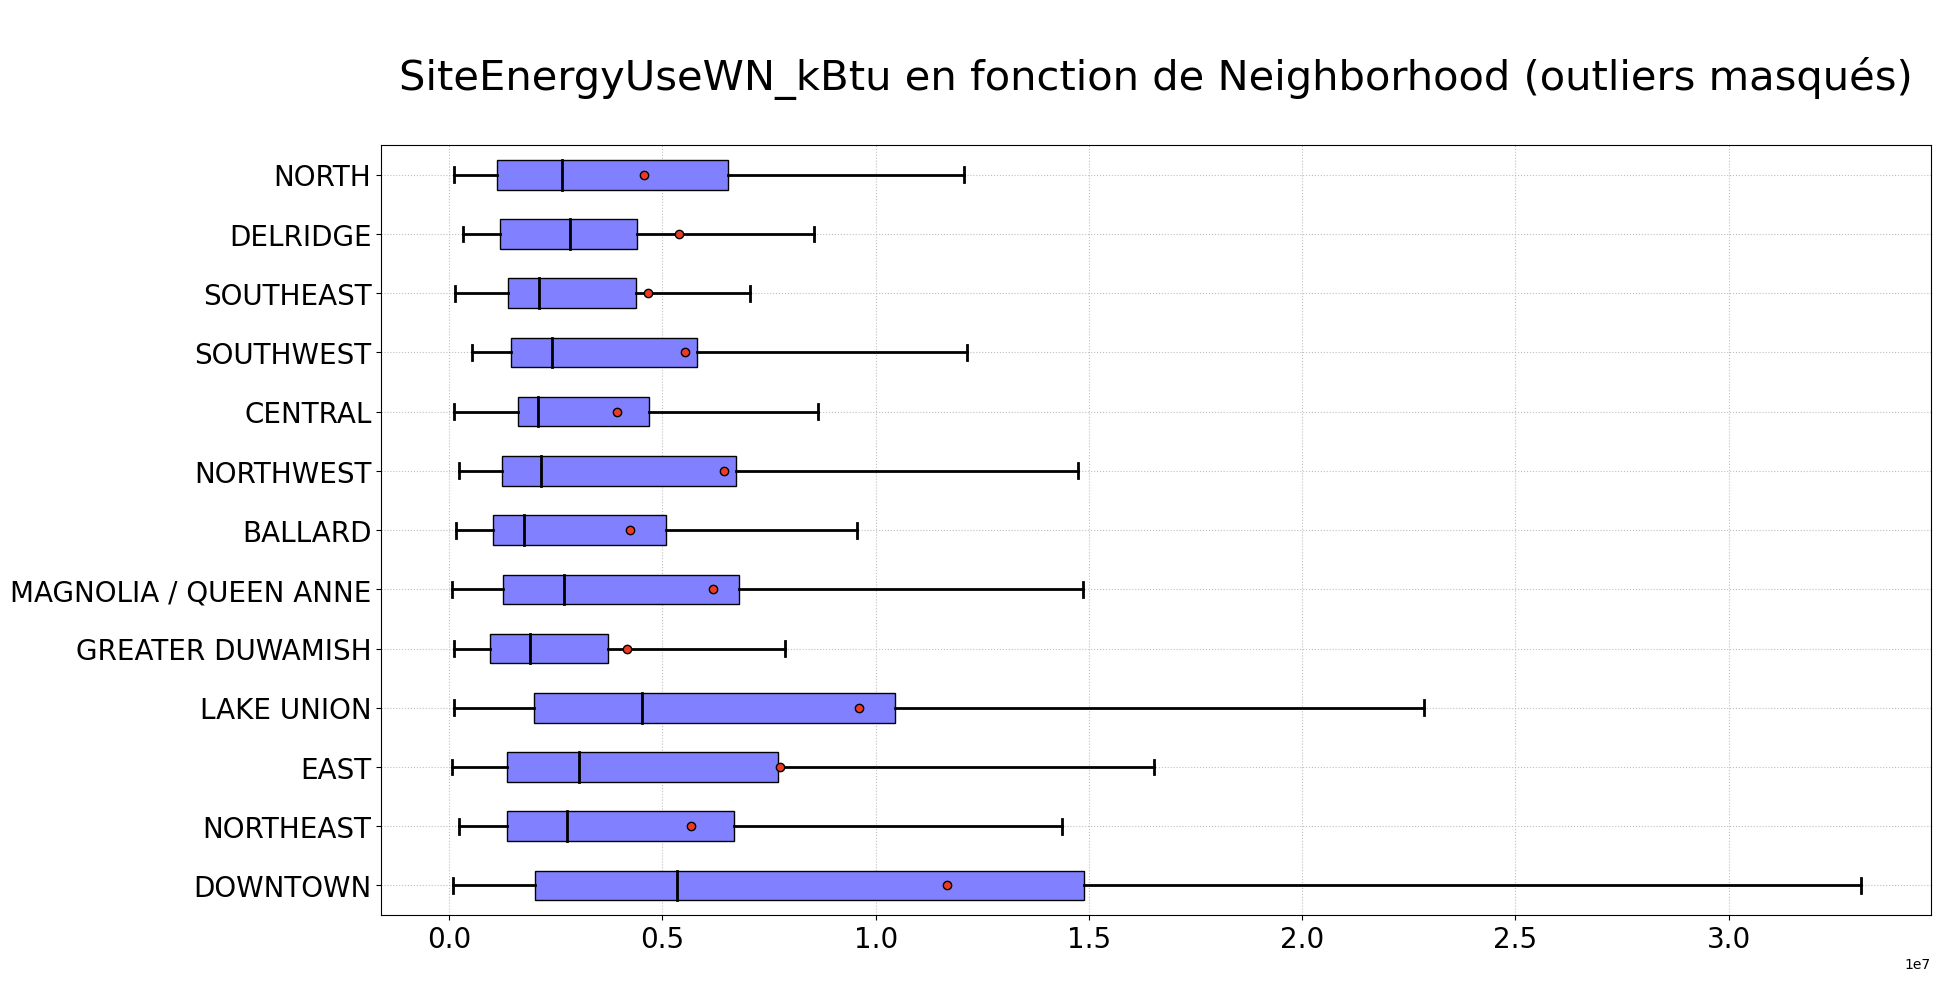

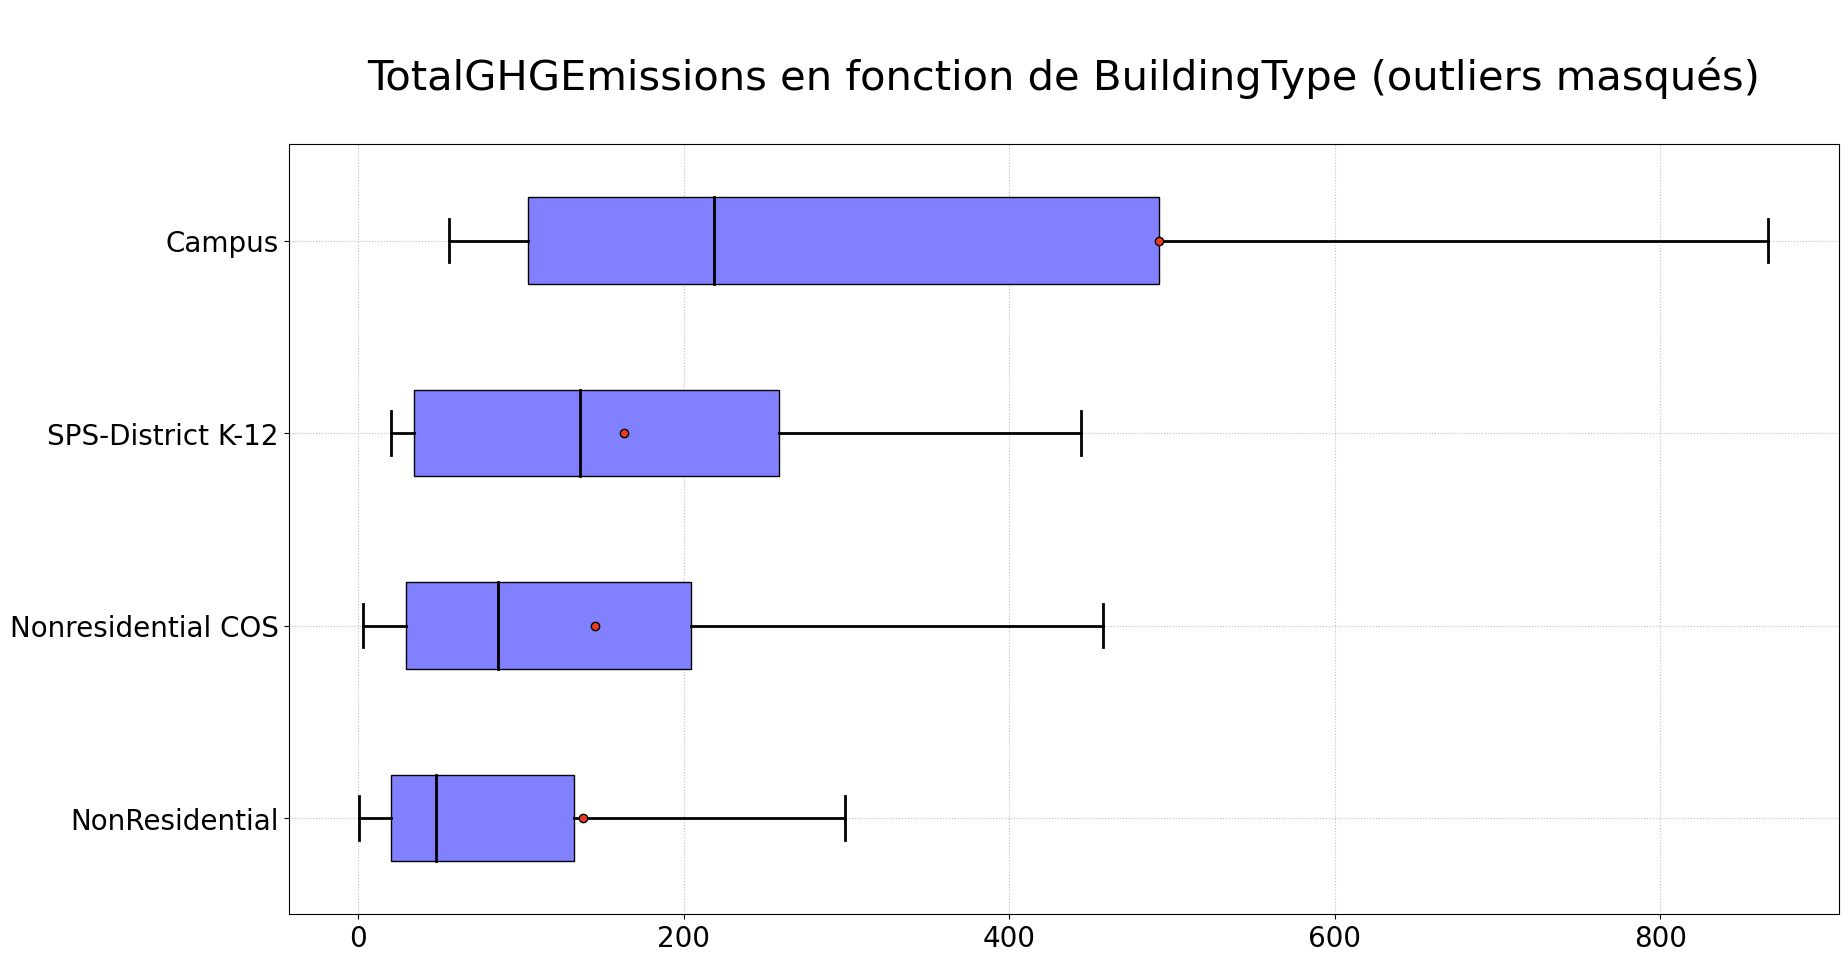

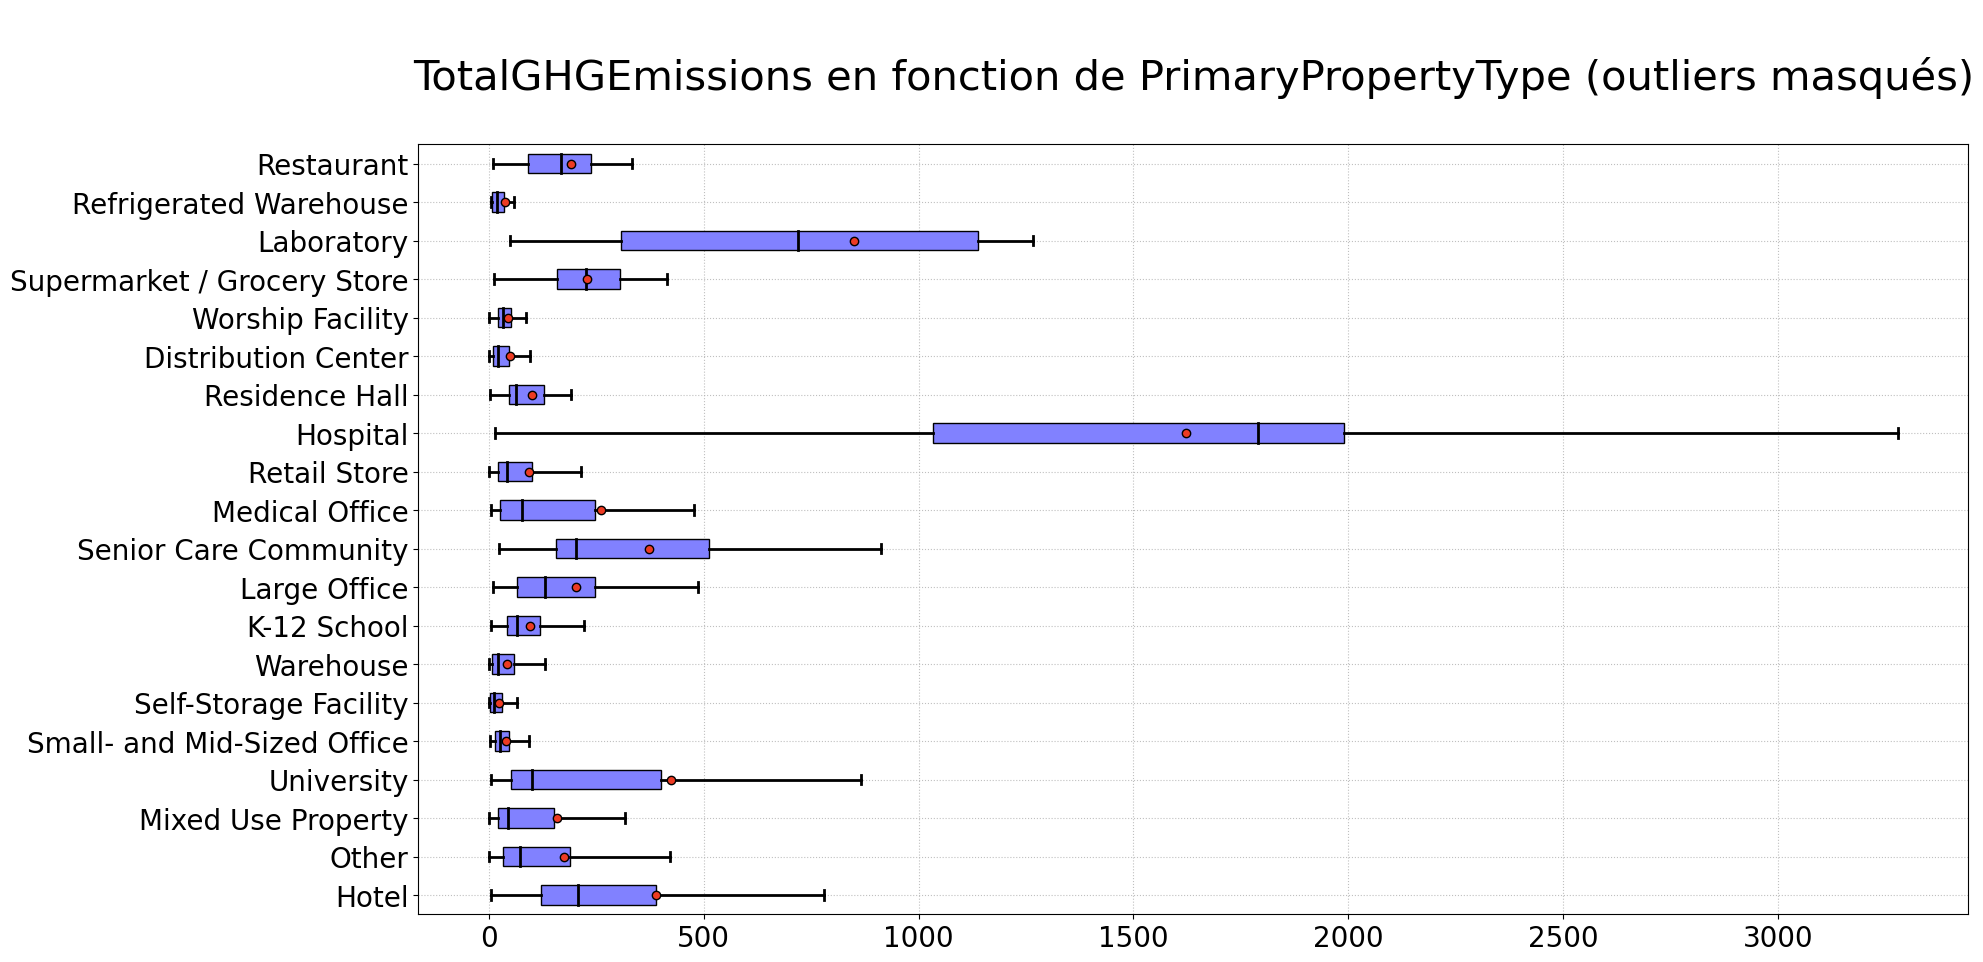

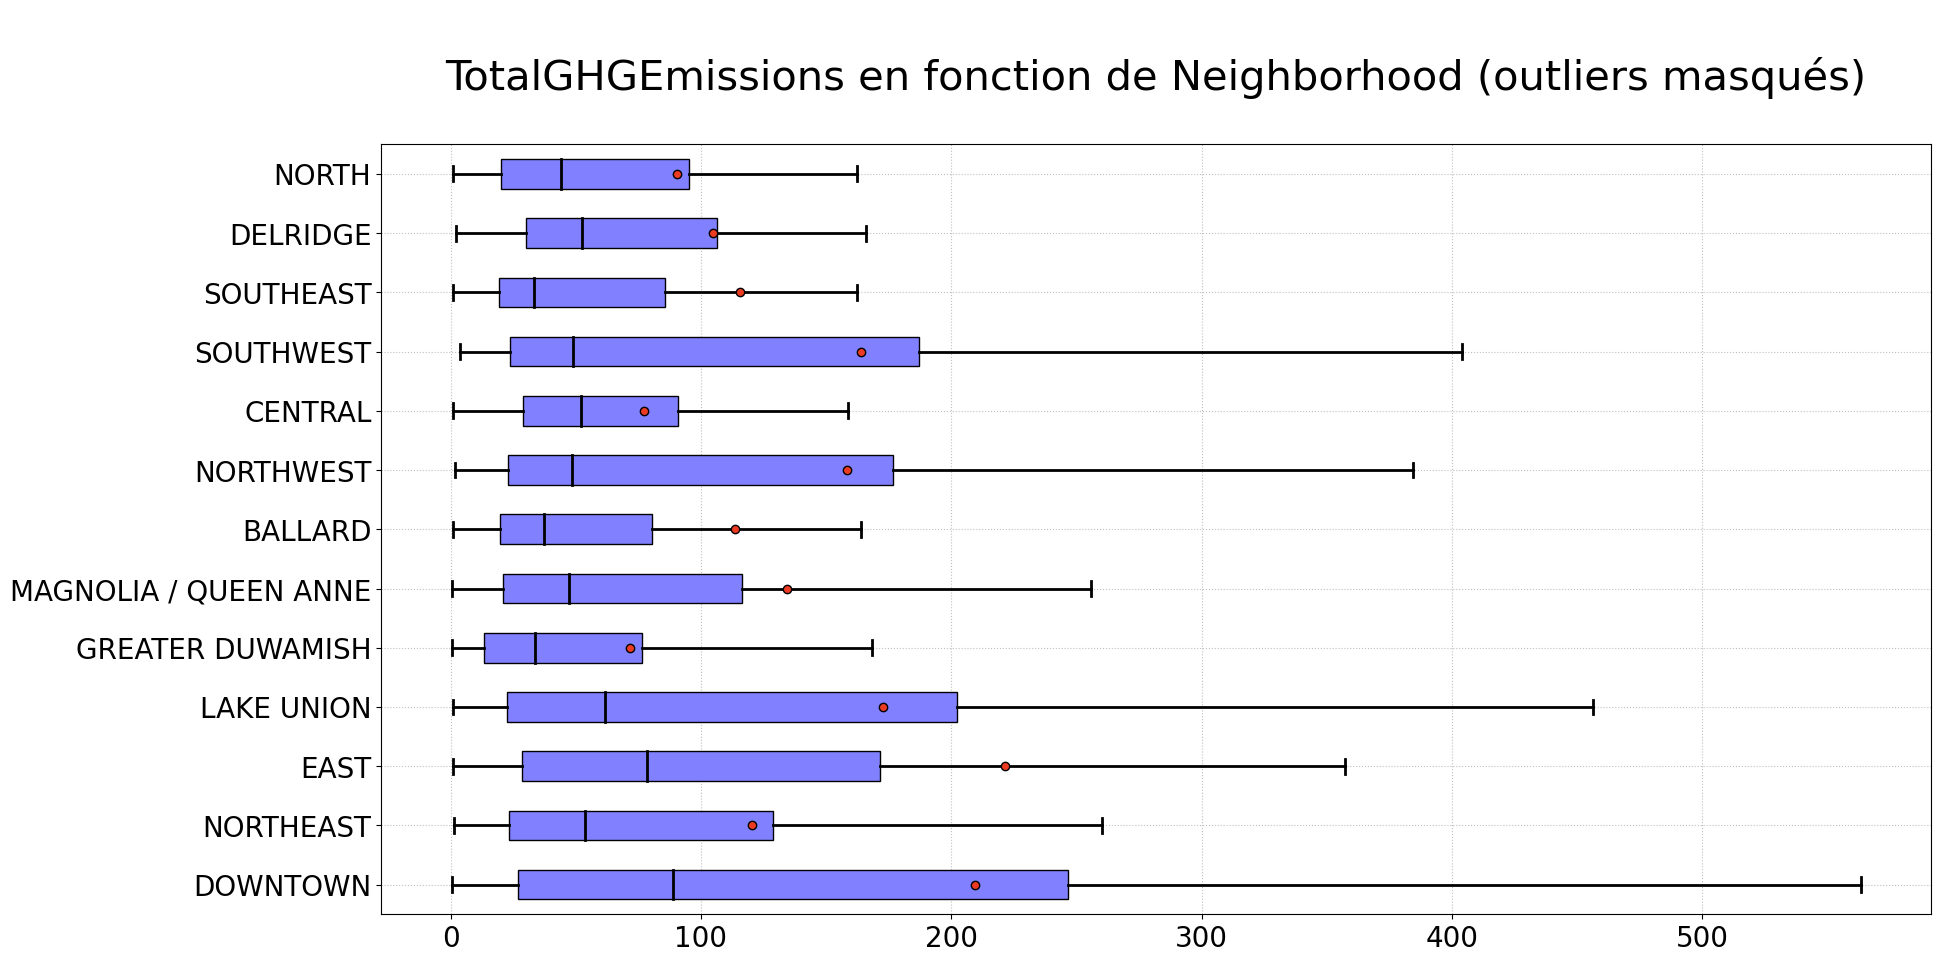

In [40]:
########################### Représentation des valeurs ###########################

for j in ['SiteEnergyUseWN_kBtu', 'TotalGHGEmissions']:

    variables_a_tester_anova = [
                            'BuildingType',
                            'PrimaryPropertyType',
                            'Neighborhood' #, 'YearBuilt' : je ne mets pas l'années, trop illisible
                            ]

    for i in variables_a_tester_anova:

        grades = data_clean[i].unique()

        grades_labels = data_clean[i].unique()

        liste_valeurs = []

        for k in grades:
            liste_valeurs.append(data_clean[j].loc[data_clean[i] == k].values)

        plt.figure(figsize=(20,10))
        plt.title(f"\n{j} en fonction de {i} (outliers masqués)\n", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        param_box_plot =  {
                    'patch_artist': True,
                    'boxprops': dict(linestyle='-', linewidth=1, color='black', facecolor='#8181FF'),
                    'capprops': dict(color='black', linewidth=2),
                    'flierprops': dict(color='#8181FF', markeredgecolor=None, markerfacecolor='#8181FF', markersize=5, marker='.', alpha=.1),
                    'medianprops': dict(linestyle='-', linewidth=2, color='black'),
                    'meanprops': dict(marker='o', markeredgecolor='black', markeredgewidth=1, markerfacecolor='#ED3B23'),
                    'whiskerprops': dict(color='black', linewidth=2)
                            }

        box = plt.boxplot(liste_valeurs, vert=False, showfliers=False, showmeans=True, labels=grades_labels, **param_box_plot); 

        """# Couleur spécifique pour chaque boîte : 
        colors = ['#118D51', '#7EC247', '#FECB27', '#F58024', '#ED3B23']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)"""

        plt.grid(alpha = 0.8, ls=':')

        plt.show()

Tableau ANOVA pour SiteEnergyUseWN_kBtu avec BuildingType:

                    sum_sq      df         F    PR(>F)
BuildingType  3.674488e+15     3.0  8.978595  0.000007
Residual      2.073532e+17  1520.0       NaN       NaN

Valeur de Eta Carré : 0.017
------------------------------
Tableau ANOVA pour SiteEnergyUseWN_kBtu avec PrimaryPropertyType:

                           sum_sq      df          F        PR(>F)
PrimaryPropertyType  5.352212e+16    19.0  26.898715  6.426969e-82
Residual             1.575056e+17  1504.0        NaN           NaN

Valeur de Eta Carré : 0.254
------------------------------
Tableau ANOVA pour SiteEnergyUseWN_kBtu avec Neighborhood:

                    sum_sq      df         F        PR(>F)
Neighborhood  1.300289e+16    12.0  8.268057  2.801074e-15
Residual      1.980248e+17  1511.0       NaN           NaN

Valeur de Eta Carré : 0.062
------------------------------
Tableau ANOVA pour SiteEnergyUseWN_kBtu avec YearBuilt:

                 sum_sq      df  

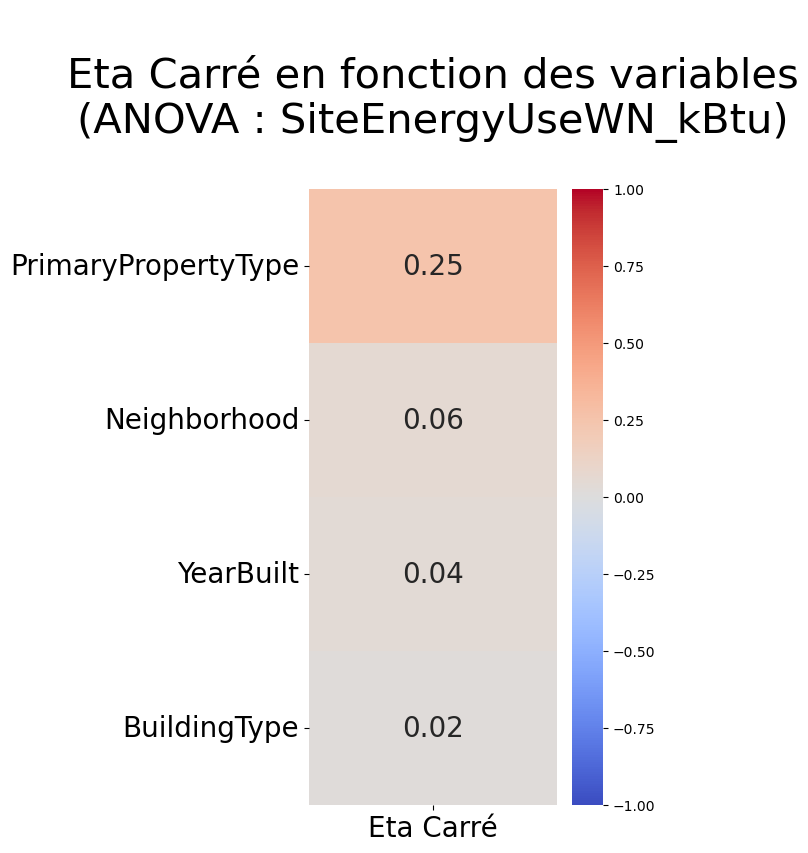

Tableau ANOVA pour TotalGHGEmissions avec BuildingType:

                    sum_sq      df         F    PR(>F)
BuildingType  2.348053e+06     3.0  9.419626  0.000004
Residual      1.262980e+08  1520.0       NaN       NaN

Valeur de Eta Carré : 0.018
------------------------------
Tableau ANOVA pour TotalGHGEmissions avec PrimaryPropertyType:

                           sum_sq      df          F        PR(>F)
PrimaryPropertyType  3.156178e+07    19.0  25.733971  1.961418e-78
Residual             9.708428e+07  1504.0        NaN           NaN

Valeur de Eta Carré : 0.245
------------------------------
Tableau ANOVA pour TotalGHGEmissions avec Neighborhood:

                    sum_sq      df         F        PR(>F)
Neighborhood  4.592649e+06    12.0  4.661629  1.729561e-07
Residual      1.240534e+08  1511.0       NaN           NaN

Valeur de Eta Carré : 0.036
------------------------------
Tableau ANOVA pour TotalGHGEmissions avec YearBuilt:

                 sum_sq      df          F   

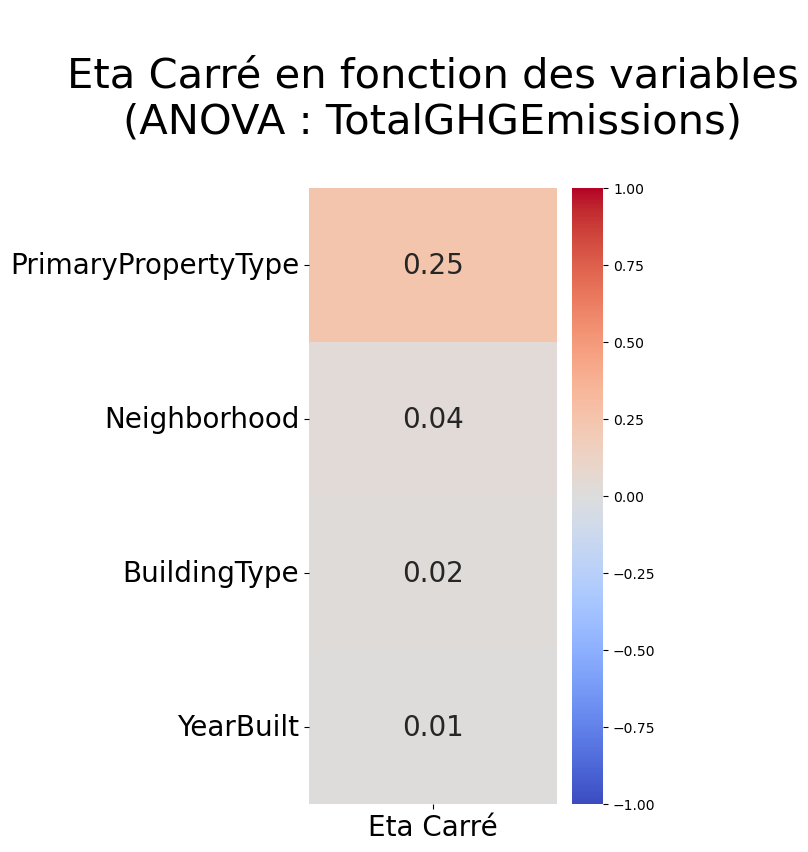

In [41]:
for j in ['SiteEnergyUseWN_kBtu', 'TotalGHGEmissions']:

    variables_a_tester_anova = [
                            'BuildingType',
                            'PrimaryPropertyType',
                            'Neighborhood',
                            'YearBuilt'
                            ]

    liste_features = []
    liste_eta = []

    for i in variables_a_tester_anova:


        mod = ols(f"{j} ~ {i}", data=data_clean).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(f"Tableau ANOVA pour {j} avec {i}:\n")
        print(aov_table)

        esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
        print("\nValeur de Eta Carré :", round(esq_sm, 3))
        print('-'*30)

        liste_features.append(i)
        liste_eta.append(esq_sm)

    # Création d'un tableau avec les valeurs de Éta Carré
    table_eta = pd.DataFrame(liste_eta, liste_features)
    table_eta.reset_index()
    table_eta = table_eta.rename(columns={0: "Eta Carré"})

    # Représentation du tableau sous forme d'une heatmap
    fig, ax = plt.subplots(figsize=(4, 8))
    sns.heatmap(table_eta.sort_values(by=['Eta Carré'], ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt="0.2f", annot_kws={"size": 20}); #vmin=-1, vmax=1, 
    plt.title(f"\nEta Carré en fonction des variables\n(ANOVA : {j})\n", fontsize=30)
    plt.xlabel("", fontsize=25)
    plt.ylabel("", fontsize=25)
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)
    plt.show()

### **ANOVA avec *SiteEnergyUseWN_kBtu* et *TotalGHGEmissions* avec transformation log**

Transformation : 

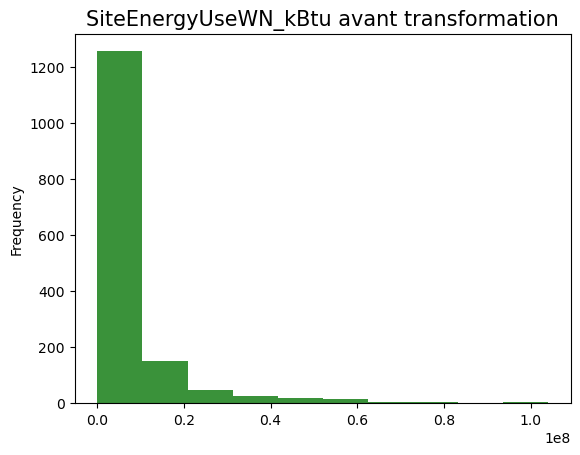

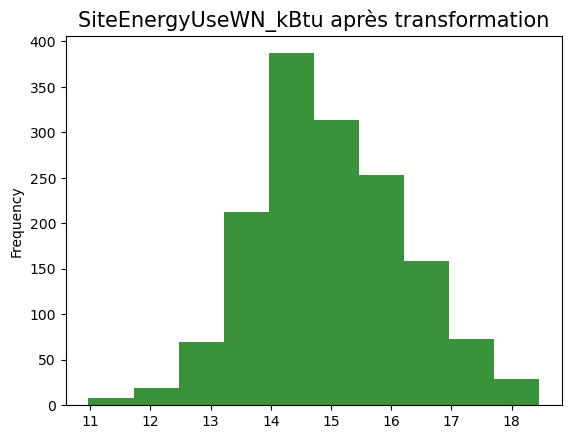

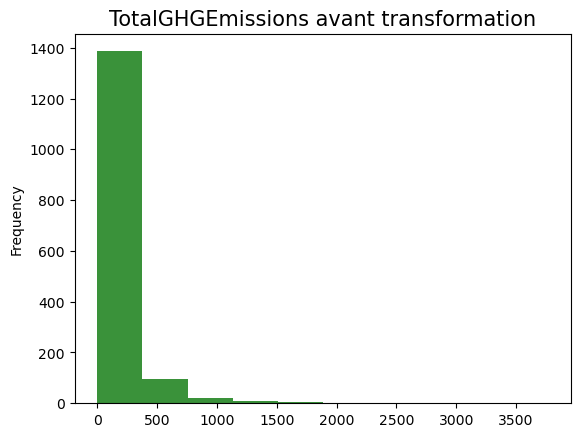

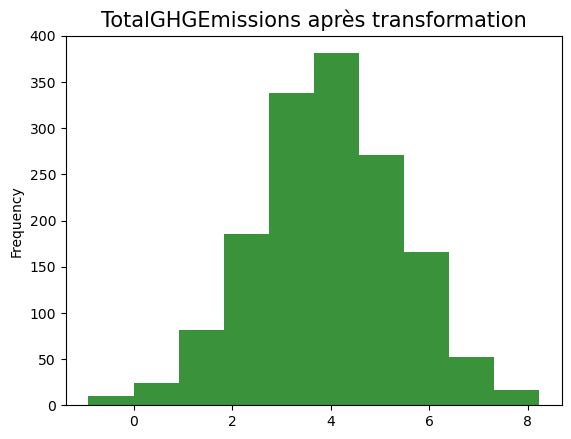

In [42]:
data_clean['SiteEnergyUseWN_kBtu'].plot.hist()
plt.title("SiteEnergyUseWN_kBtu avant transformation", fontsize=15)
plt.show()
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
NRJ_log = logtransformer.transform(data_clean['SiteEnergyUseWN_kBtu'])
NRJ_log.plot.hist()
plt.title("SiteEnergyUseWN_kBtu après transformation", fontsize=15)
plt.show()

data_clean['TotalGHGEmissions'].plot.hist()
plt.title("TotalGHGEmissions avant transformation", fontsize=15)
plt.show()
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
CO_log = logtransformer.transform(data_clean['TotalGHGEmissions'])
CO_log.plot.hist()
plt.title("TotalGHGEmissions après transformation", fontsize=15)
plt.show()

ANOVA avec les valeurs transformées : 

Tableau ANOVA pour NRJ_log avec BuildingType:

                   sum_sq      df         F    PR(>F)
BuildingType    34.244241     3.0  7.419241  0.000062
Residual      2338.570164  1520.0       NaN       NaN

Valeur de Eta Carré : 0.014
------------------------------
Tableau ANOVA pour NRJ_log avec PrimaryPropertyType:

                          sum_sq      df          F         PR(>F)
PrimaryPropertyType   938.434799    19.0  51.788608  3.897162e-149
Residual             1434.379606  1504.0        NaN            NaN

Valeur de Eta Carré : 0.395
------------------------------
Tableau ANOVA pour NRJ_log avec Neighborhood:

                   sum_sq      df          F        PR(>F)
Neighborhood   215.806555    12.0  12.597841  7.195407e-25
Residual      2157.007850  1511.0        NaN           NaN

Valeur de Eta Carré : 0.091
------------------------------
Tableau ANOVA pour NRJ_log avec YearBuilt:

                sum_sq      df           F        PR(>F)
YearBuilt   162.772442     1.0 

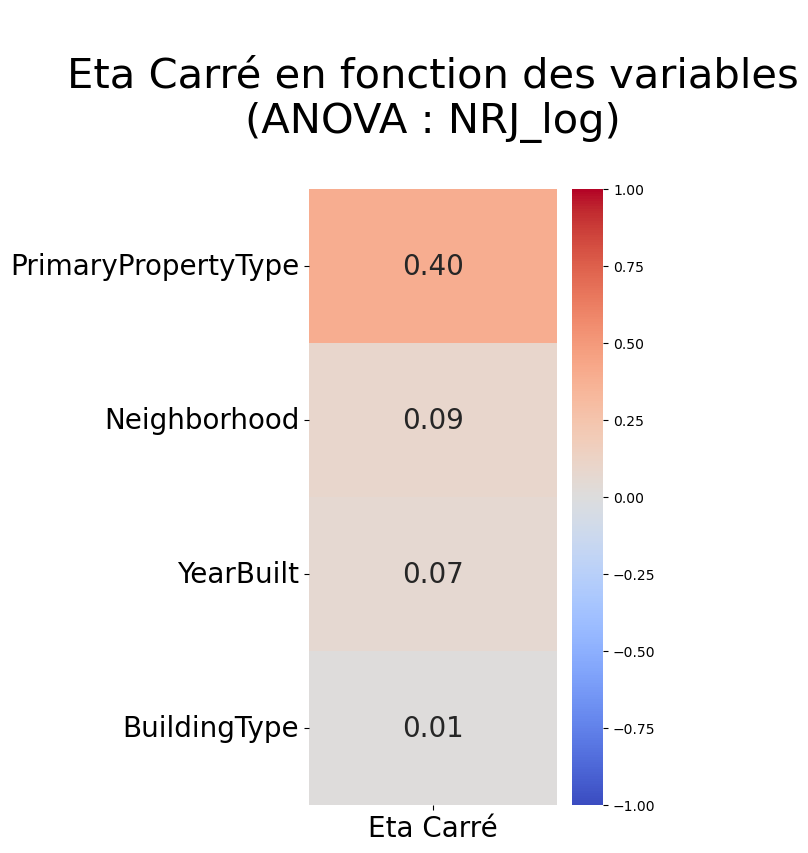

Tableau ANOVA pour CO_log avec BuildingType:

                   sum_sq      df          F        PR(>F)
BuildingType    67.162505     3.0  10.576408  6.958038e-07
Residual      3217.444108  1520.0        NaN           NaN

Valeur de Eta Carré : 0.02
------------------------------
Tableau ANOVA pour CO_log avec PrimaryPropertyType:

                          sum_sq      df          F         PR(>F)
PrimaryPropertyType  1015.452081    19.0  35.423347  1.933371e-106
Residual             2269.154531  1504.0        NaN            NaN

Valeur de Eta Carré : 0.309
------------------------------
Tableau ANOVA pour CO_log avec Neighborhood:

                   sum_sq      df         F        PR(>F)
Neighborhood   186.535184    12.0  7.581455  9.070125e-14
Residual      3098.071429  1511.0       NaN           NaN

Valeur de Eta Carré : 0.057
------------------------------
Tableau ANOVA pour CO_log avec YearBuilt:

                sum_sq      df          F        PR(>F)
YearBuilt    85.657775   

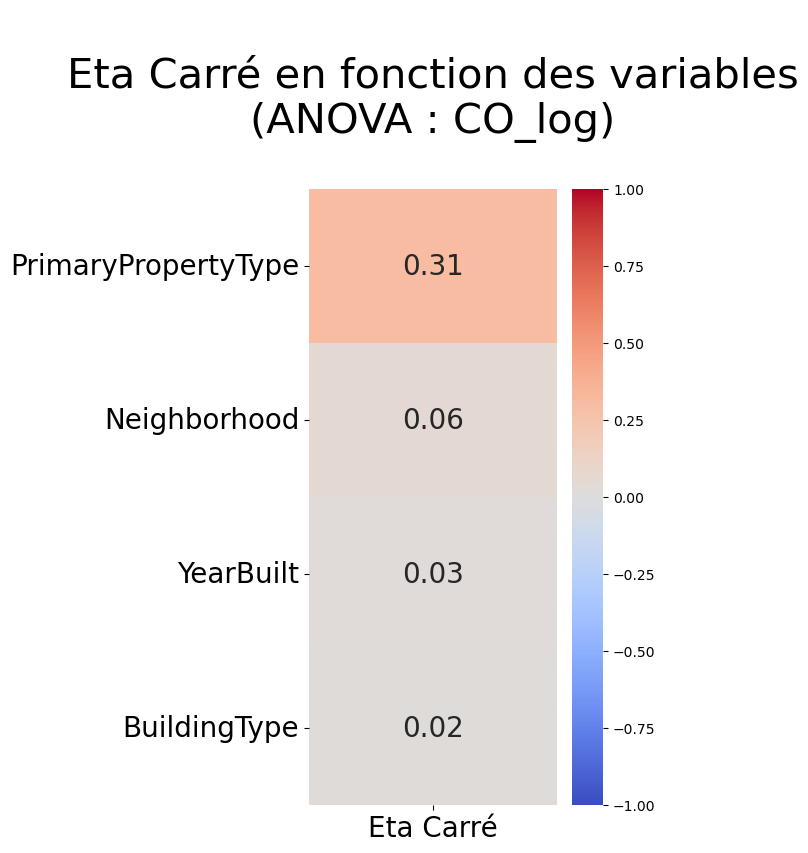

In [43]:

# Création d'un dataset temporaire dans lequel j'ajoute les variables avec transformation log
data_clean_log = data_clean.copy()
data_clean_log['NRJ_log'] = NRJ_log
data_clean_log['CO_log'] = CO_log


for j in ['NRJ_log', 'CO_log']:

    variables_a_tester_anova = [
                            'BuildingType',
                            'PrimaryPropertyType',
                            'Neighborhood',
                            'YearBuilt'
                            ]

    liste_features = []
    liste_eta = []

    for i in variables_a_tester_anova:


        mod = ols(f"{j} ~ {i}", data=data_clean_log).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(f"Tableau ANOVA pour {j} avec {i}:\n")
        print(aov_table)

        esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
        print("\nValeur de Eta Carré :", round(esq_sm, 3))
        print('-'*30)

        liste_features.append(i)
        liste_eta.append(esq_sm)

    # Création d'un tableau avec les valeurs de Éta Carré
    table_eta = pd.DataFrame(liste_eta, liste_features)
    table_eta.reset_index()
    table_eta = table_eta.rename(columns={0: "Eta Carré"})

    # Représentation du tableau sous forme d'une heatmap
    fig, ax = plt.subplots(figsize=(4, 8))
    sns.heatmap(table_eta.sort_values(by=['Eta Carré'], ascending=False), annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt="0.2f", annot_kws={"size": 20}); #vmin=-1, vmax=1, 
    plt.title(f"\nEta Carré en fonction des variables\n(ANOVA : {j})\n", fontsize=30)
    plt.xlabel("", fontsize=25)
    plt.ylabel("", fontsize=25)
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)
    plt.show()

## **Export des datasets nettoyés pour pouvoir les utiliser dans d'autres notebooks**

In [44]:
# Export du dataset data_clean
if os.path.isfile('data_clean.xlsx') == False:
    data_clean.to_excel('data_clean.xlsx', index = False)
else:
    print("Le fichier 'data_clean.xlsx' existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

# Export du dataset data_clean_score : moins de lignes mais avec la variable ENERGYSTARScore
if os.path.isfile('data_clean_score.xlsx') == False:
    data_clean_score.to_excel('data_clean_score.xlsx', index = False)
else:
    print("Le fichier 'data_clean_score.xlsx' existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

Le fichier 'data_clean.xlsx' existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.
Le fichier 'data_clean_score.xlsx' existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.
